<a href="https://colab.research.google.com/github/noambassat/SupremeCourtClassifier/blob/main/LLM_Court.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import torch
import joblib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import time
import re
import openai
import json
from sklearn.model_selection import train_test_split
import ast
from google.colab import userdata

In [2]:
def fix_hebrew_labels(ax):
    """ Reverse Hebrew labels in Matplotlib plots. """
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        text = label.get_text()
        if any("\u0590" <= char <= "\u05FF" for char in text):  # Detect Hebrew characters
            label.set_text(text[::-1])
    ax.figure.canvas.draw()


In [3]:

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:

folder_id = "בית המשפט - קבצים שנבדקו"
directory_path = f"/content/drive/My Drive/{folder_id}"
classifiers_path = "/content/drive/MyDrive/בית המשפט - מסווגים/"

if not os.path.exists(directory_path):
    print(f"Directory {directory_path} does not exist. Please check the folder path.")
else:
    dataframes = []

    for file_name in os.listdir(directory_path):
        if file_name.endswith(".xlsx") or file_name.endswith(".xls"):
            file_path = os.path.join(directory_path, file_name)
            try:
                df = pd.read_excel(file_path)
                dataframes.append(df)
            except Exception as e:
                print(f"Failed to read {file_name}: {e}")

    if dataframes:
        combined_df = pd.concat(dataframes, ignore_index=True)
        print("All Excel files have been concatenated successfully!")

/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


All Excel files have been concatenated successfully!


In [5]:
full_ra_rap = pd.read_excel("/content/drive/My Drive/full_ra_rap.xlsx")

In [6]:
check_gender_bias = pd.concat([dataframes[0], dataframes[1], dataframes[2]])
check_gender_bias = pd.merge(full_ra_rap, check_gender_bias, on='מספר הליך', how='left')
check_gender_bias.drop_duplicates(subset = 'מספר הליך',inplace = True)
check_gender_bias.dropna(subset = ["בקשה לרשות ערעור התקבלה?"],inplace=True)

In [7]:
for col in check_gender_bias.columns:
    if(col.find("מגדר")!=-1 or col.find("ערעור")!=-1 or col.find("מספר ")!=-1):
      print(col)

מספר תיק
מספר החלטות בתיק
מספר הליך
מספר גורמים שיפוטיים במותב
מגדר
מספר מילים בגוף המסמך
מספר עמודים
מספר צדדים בתיק
מספר תיקי דלמטה בתיק
מספר דיונים בתיק
מספר אירועים בתיק
מספר אישורי מסירה בתיק
מספר בקשות בתיק
מספר צד
מספר הבקשה
מספר תיק דלמטה מלא
מספר תיק דלמטה
מספר תיק מלא
מספר השופטים
בקשה לרשות ערעור התקבלה?
הערעור התקבל?
הערות תוצאת ערעור
prediction_adjusted_threshold
בקשת רשות ערעור התקבלה?
prediction_second_model_adjusted
ערעור התקבל?


In [8]:
check_gender_bias = check_gender_bias[["מספר הליך","מספר השופטים","בקשה לרשות ערעור התקבלה?","מגדר"]]

In [9]:
check_gender_bias[["בקשה לרשות ערעור התקבלה?","מגדר"]]

בקשה לרשות ערעור התקבלה?                     מגדר
495                       נדחה                  ['זכר']
503                       נדחה                  ['זכר']
537                       נדחה                  ['זכר']
539                        אחר                  ['זכר']
550                       נדחה                  ['זכר']
...                        ...                      ...
20482                     נדחה                  ['זכר']
20499                    התקבל  ['זכר', 'נקבה', 'נקבה']
20503                    התקבל   ['זכר', 'נקבה', 'זכר']
20540                      אחר                 ['נקבה']
20560                    התקבל    ['זכר', 'זכר', 'זכר']

[702 rows x 2 columns]

<ipython-input-10-533c6d08d180>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_gender_bias["מגדר"] = check_gender_bias["מגדר"].apply(literal_eval)  # ממיר טקסט לרשימה


<Figure size 800x500 with 0 Axes>

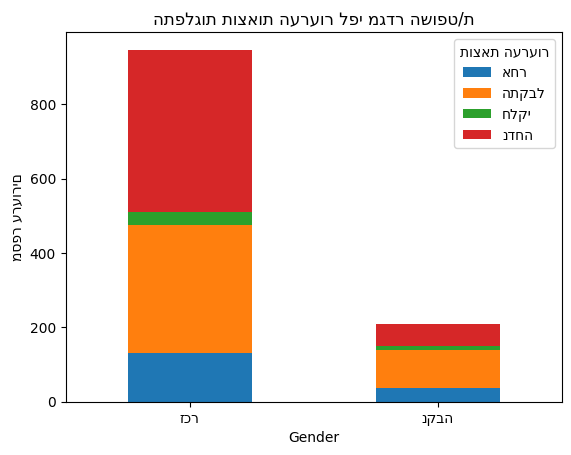

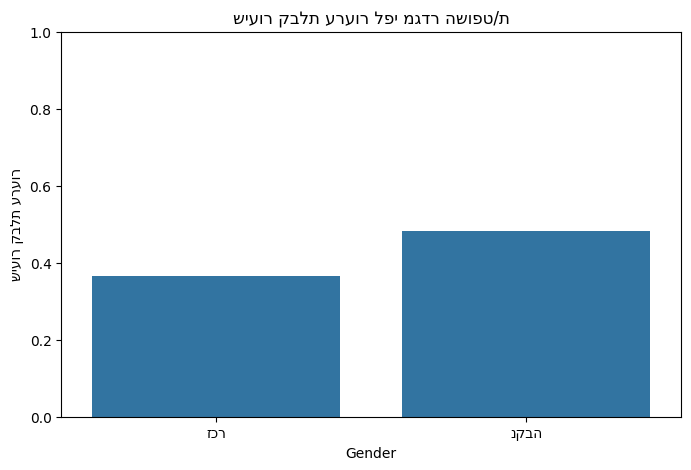

Appeal Outcome  אחר  התקבל  חלקי  נדחה  Total  Acceptance Rate
Gender                                                        
זכר             130    346    34   437    947         0.365364
נקבה             38    101    11    59    209         0.483254


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval


# המרת המחרוזת ברשימת מגדרים למבנה רשימה
check_gender_bias["מגדר"] = check_gender_bias["מגדר"].apply(literal_eval)  # ממיר טקסט לרשימה

# פונקציה להשטחת הנתונים – כל שופט יקבל שורה משלו
def expand_genders(df):
    expanded_data = []
    for _, row in df.iterrows():
        for gender in row["מגדר"]:
            expanded_data.append({"Gender": gender, "Appeal Outcome": row["בקשה לרשות ערעור התקבלה?"]})
    return pd.DataFrame(expanded_data)

# הרחבת הטבלה
df_expanded = expand_genders(check_gender_bias)

# ספירת תוצאות הערעור לפי מגדר
outcome_counts = df_expanded.groupby(["Gender", "Appeal Outcome"]).size().unstack().fillna(0)

# יצירת גרף התפלגות תוצאות לפי מגדר
plt.figure(figsize=(8, 5))
outcome_counts.plot(kind="bar", stacked=True)
plt.ylabel("מספר ערעורים")
plt.title("התפלגות תוצאות הערעור לפי מגדר השופט/ת")
plt.xticks(rotation=0)
plt.legend(title="תוצאת הערעור")
plt.show()

# חישוב יחס קבלת ערעור לכל מגדר
outcome_counts["Total"] = outcome_counts.sum(axis=1)
outcome_counts["Acceptance Rate"] = outcome_counts.get("התקבל", 0) / outcome_counts["Total"]

# יצירת גרף של אחוזי קבלת ערעור לפי מגדר
plt.figure(figsize=(8, 5))
sns.barplot(x=outcome_counts.index, y=outcome_counts["Acceptance Rate"])
plt.ylabel("שיעור קבלת ערעור")
plt.title("שיעור קבלת ערעור לפי מגדר השופט/ת")
plt.ylim(0, 1)
plt.show()

# הצגת הטבלה עם התוצאות
print(outcome_counts)


# Bias - number of Judges

<Figure size 800x500 with 0 Axes>

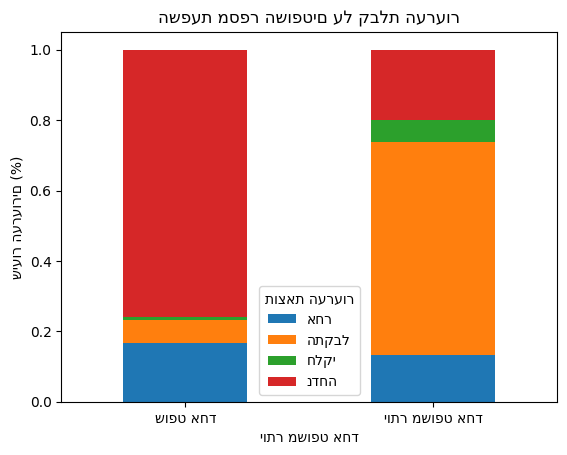

שיעור קבלת הערעור לפי מספר שופטים:
יותר משופט אחד
False    0.065126
True     0.606195
Name: התקבל, dtype: float64


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

# טעינת הנתונים
df = check_gender_bias.copy()

# חישוב מספר השופטים בכל תיק
df["מספר שופטים"] = df["מגדר"].apply(len)

# חלוקת המקרים לשתי קבוצות: שופט יחיד או יותר מאחד
df["יותר משופט אחד"] = df["מספר שופטים"] > 1

# ספירת המקרים לפי מספר השופטים והאם הערעור התקבל
outcome_counts = df.groupby("יותר משופט אחד")["בקשה לרשות ערעור התקבלה?"].value_counts(normalize=True).unstack()

# יצירת גרף
plt.figure(figsize=(8, 5))
outcome_counts.plot(kind="bar", stacked=True)
plt.ylabel("שיעור הערעורים (%)")
plt.title("השפעת מספר השופטים על קבלת הערעור")
plt.xticks([0, 1], ["שופט אחד", "יותר משופט אחד"], rotation=0)
plt.legend(title="תוצאת הערעור")
plt.show()

# חישוב אחוז קבלת ערעור לפי מספר השופטים
acceptance_rate = outcome_counts.get("התקבל", 0)

# הדפסת סטטיסטיקה
print("שיעור קבלת הערעור לפי מספר שופטים:")
print(acceptance_rate)


<ipython-input-12-9995a47b4688>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grouped_by_judges.index, y=grouped_by_judges.values, palette="Blues_r")


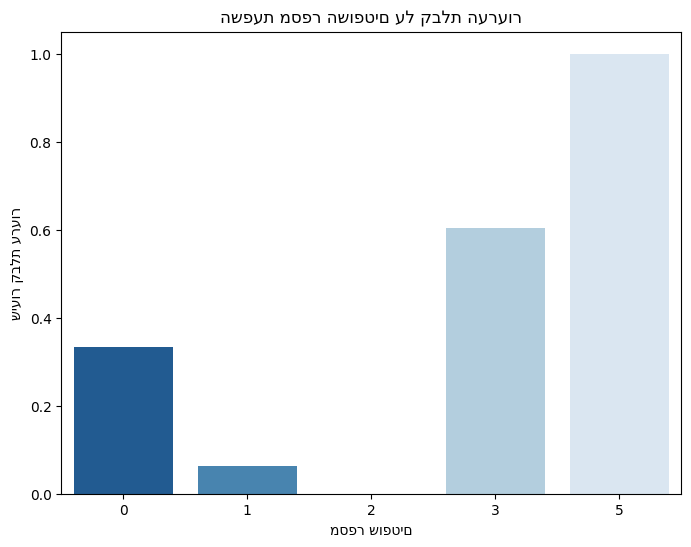

ערעור התקבל      0      1
מספר שופטים              
0              2.0    1.0
1            443.0   30.0
2              1.0    NaN
3             88.0  134.0
5              NaN    3.0
Chi-Square Test: p-value = 0.0000
מסקנה: קיים קשר מובהק סטטיסטית בין מספר השופטים לקבלת הערעור.
טבלת שכיחות לפי נוכחות שופטות:
 ערעור התקבל    0   1
מכיל נקבה           
False        433  87
True         101  81


<ipython-input-12-9995a47b4688>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_bias_table.index, y=gender_bias_table[1] / (gender_bias_table[1] + gender_bias_table[0]), palette="Reds_r")


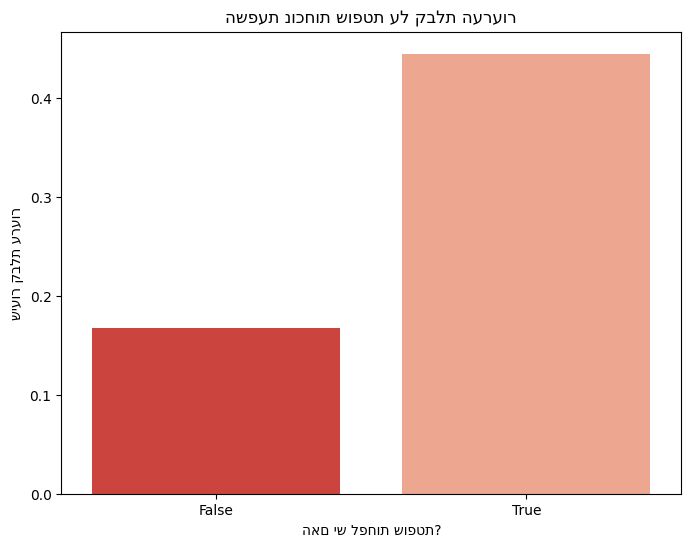

Chi-Square Test for Gender Bias: p-value = 0.0000
מסקנה: יש עדות מובהקת לכך שנוכחות שופטות משפיעה על החלטת הערעור.


In [12]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

df = check_gender_bias.copy()

# לוודא שהעמודה 'מגדר' היא רשימה ולא מחרוזת
df["מגדר"] = df["מגדר"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# הוספת עמודת מספר השופטים בכל מקרה
df["מספר שופטים"] = df["מגדר"].apply(len)

# יצירת עמודת אינדיקטור אם הערעור התקבל או לא
df["ערעור התקבל"] = df["בקשה לרשות ערעור התקבלה?"].apply(lambda x: 1 if x == "התקבל" else 0)

### בדיקת הקשר בין מספר השופטים להחלטה ###
grouped_by_judges = df.groupby("מספר שופטים")["ערעור התקבל"].mean()
plt.figure(figsize=(8, 6))
sns.barplot(x=grouped_by_judges.index, y=grouped_by_judges.values, palette="Blues_r")
plt.xlabel("מספר שופטים")
plt.ylabel("שיעור קבלת ערעור")
plt.title("השפעת מספר השופטים על קבלת הערעור")
plt.show()

# טבלת שכיחות
judge_count_table = df.groupby("מספר שופטים")["ערעור התקבל"].value_counts().unstack()
print(judge_count_table)

# בדיקה סטטיסטית - האם יש קשר מובהק בין מספר שופטים להחלטה
chi2, p, _, _ = chi2_contingency(judge_count_table.fillna(0))
print(f"Chi-Square Test: p-value = {p:.4f}")
if p < 0.05:
    print("מסקנה: קיים קשר מובהק סטטיסטית בין מספר השופטים לקבלת הערעור.")
else:
    print("מסקנה: אין קשר מובהק סטטיסטית בין מספר השופטים לקבלת הערעור.")

### בדיקת ביאס מגדרי ###
# חישוב אחוז קבלת ערעור לפי מגדר
def get_gender_stats(gender_list, outcome):
    return any(g in gender_list for g in outcome)

df["מכיל זכר"] = df["מגדר"].apply(lambda x: "זכר" in x)
df["מכיל נקבה"] = df["מגדר"].apply(lambda x: "נקבה" in x)

# בדיקת הבדל בין מקרים עם לפחות שופטת לבין אלו ללא
gender_bias_table = df.groupby("מכיל נקבה")["ערעור התקבל"].value_counts().unstack()
print("טבלת שכיחות לפי נוכחות שופטות:\n", gender_bias_table)

plt.figure(figsize=(8, 6))
sns.barplot(x=gender_bias_table.index, y=gender_bias_table[1] / (gender_bias_table[1] + gender_bias_table[0]), palette="Reds_r")
plt.xlabel("האם יש לפחות שופטת?")
plt.ylabel("שיעור קבלת ערעור")
plt.title("השפעת נוכחות שופטת על קבלת הערעור")
plt.show()

# בדיקה סטטיסטית - האם יש הבדל מובהק
chi2, p, _, _ = chi2_contingency(gender_bias_table.fillna(0))
print(f"Chi-Square Test for Gender Bias: p-value = {p:.4f}")
if p < 0.05:
    print("מסקנה: יש עדות מובהקת לכך שנוכחות שופטות משפיעה על החלטת הערעור.")
else:
    print("מסקנה: אין עדות מובהקת לכך שנוכחות שופטות משפיעה על החלטת הערעור.")


In [13]:
len(dataframes)

6

In [14]:
df_1 = dataframes[0].copy()

df_1.columns

Index(['level_0', 'index', 'גוף המסמך', 'מספר הליך', 'שם הליך',
       'שנת פתיחת ההליך', 'גוף המסמך חתוך', 'predicted_probability',
       'prediction_original_model', 'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה שונה', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'קידוד', 'קידוד חוזר', 'הערות ',
       'הערות קידוד חוזר'],
      dtype='object')

In [15]:
df_1 = df_1[['גוף המסמך', 'מספר הליך', 'שם הליך',
       'שנת פתיחת ההליך', 'גוף המסמך חתוך',  'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה שונה', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'הערות ',
       'הערות קידוד חוזר']]

In [16]:
df_2 = dataframes[1].copy()

In [17]:
df_2 = df_2[['גוף המסמך', 'מספר הליך', 'שם הליך',
       'שנת פתיחת ההליך', 'גוף המסמך חתוך',
       'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)',
       'הערעור התקבל?', 'רע"פ בקשה אחרת או דלמטה מיוחד',
       'הערות תוצאת ערעור', 'הערות ', 'הערות קידוד חוזר']]

In [18]:
df = pd.concat([df_1, df_2], ignore_index=True)

In [19]:
df_3 = dataframes[2].copy()

In [20]:
df_3 = df_3[['גוף המסמך', 'מספר הליך', 'שם הליך',
       'שנת פתיחת ההליך',
       'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)',
       'הערעור התקבל?', 'הערות תוצאת ערעור', 'רע"פ בקשה אחרת או דלמטה מיוחד', 'הערות ']]

In [21]:
df = pd.concat([df, df_3], ignore_index=True)

In [22]:
columns_to_check = [
    "הערות ",
    "הערות תוצאת ערעור",
    "הערות קידוד חוזר",
    "טקסט שמצביע על תוצאת בקשה שונה",
    "טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)",
    "טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)"
]


df = df[~df[columns_to_check].isna().all(axis=1)]

In [23]:
df.shape

(348, 13)

In [24]:
len(df["גוף המסמך"])

df["length"] = df["גוף המסמך"].apply(lambda x: len(str(x).split()))

average_length = df["length"].mean()
max_length = df["length"].max()
min_length = df["length"].min()

print(f"אורך ממוצע של פסקי דין: {average_length:.2f} מילים")
print(f"פסק הדין הארוך ביותר מכיל {max_length} מילים")
print(f"פסק הדין הקצר ביותר מכיל {min_length} מילים")


אורך ממוצע של פסקי דין: 722.41 מילים
פסק הדין הארוך ביותר מכיל 5920 מילים
פסק הדין הקצר ביותר מכיל 60 מילים


In [25]:
def convert_list_to_string(text):
    if isinstance(text, str) and text.startswith("[") and text.endswith("]"):
        try:
            text_list = ast.literal_eval(text)
            return ' '.join(text_list)
        except (ValueError, SyntaxError):
            return text
    return text

def clean_text(text):
    if isinstance(text, list):
        text = ' '.join(text)
    elif isinstance(text, str):
        text = re.sub(r'\n+', ' ', text)  # הסרת שורות חדשות מרובות
        text = re.sub(r'\n', '', text)   # הסרת תווי newline \n מהטקסט
        text = re.sub(r'\xa0', ' ', text)  # הסרת תווי \xa0 מהטקסט
        text = re.sub(r'\s+', ' ', text)  # הסרת רווחים מרובים

        text = re.sub(r"העותק כפוף לשינויי עריכה וניסוח.*?$", "", text, flags=re.MULTILINE)
        text = re.sub(r"מרכז מידע, טל' \d{2,3}-\d{6,7}.*?$", "", text, flags=re.MULTILINE)
        text = re.sub(r"אתר אינטרנט, .*?$", "", text, flags=re.MULTILINE)
    return text

print("שורות לא קריאות לפני המרה:")
print(df["גוף המסמך"].head())

df["גוף המסמך"] = df["גוף המסמך"].apply(clean_text)

print("\nשורות לאחר המרה:")
print(df["גוף המסמך"].head())

file_path_full = 'checked_df_cleaned.csv' # FULL RAP DATA CLEANED
df.to_csv(file_path_full, index=False, encoding='utf-8')


שורות לא קריאות לפני המרה:
5      ['החלטה בתיק רע"פ 3622/15 בבית המשפט העליון רע...
31     ['החלטה בתיק רע"פ 825/15 בבית המשפט העליון רע"...
67     ['החלטה בתיק רע"פ 54/15 בבית המשפט העליון רע"פ...
73     ['פסק דין בתיק רע"פ 2811/15 בבית המשפט העליון ...
114    ['פסק דין בתיק רע"פ 2195/15 בבית המשפט העליון ...
Name: גוף המסמך, dtype: object

שורות לאחר המרה:
5      ['החלטה בתיק רע"פ 3622/15 בבית המשפט העליון רע...
31     ['החלטה בתיק רע"פ 825/15 בבית המשפט העליון רע"...
67     ['החלטה בתיק רע"פ 54/15 בבית המשפט העליון רע"פ...
73     ['פסק דין בתיק רע"פ 2811/15 בבית המשפט העליון ...
114    ['פסק דין בתיק רע"פ 2195/15 בבית המשפט העליון ...
Name: גוף המסמך, dtype: object


In [26]:
def extract_relevant_part(text):
    words = str(text).split()
    if len(words) > 1000:
        return " ".join(words[-800:-20])
    return text

df["גוף המסמך חתוך"] = df["גוף המסמך"].apply(extract_relevant_part)

df[["גוף המסמך", "גוף המסמך חתוך"]].head()


גוף המסמך  \
5    ['החלטה בתיק רע"פ 3622/15 בבית המשפט העליון רע...   
31   ['החלטה בתיק רע"פ 825/15 בבית המשפט העליון רע"...   
67   ['החלטה בתיק רע"פ 54/15 בבית המשפט העליון רע"פ...   
73   ['פסק דין בתיק רע"פ 2811/15 בבית המשפט העליון ...   
114  ['פסק דין בתיק רע"פ 2195/15 בבית המשפט העליון ...   

                                        גוף המסמך חתוך  
5    מאסר תמורתו. 6. המבקש ערער לבית המשפט המחוזי ע...  
31   ['החלטה בתיק רע"פ 825/15 בבית המשפט העליון רע"...  
67   (13.1.2015); רע"פ 8087/14 נדים אנגנאץ נ\' מדינ...  
73   ['פסק דין בתיק רע"פ 2811/15 בבית המשפט העליון ...  
114  ['פסק דין בתיק רע"פ 2195/15 בבית המשפט העליון ...

In [27]:
df = df[['גוף המסמך', 'מספר הליך', 'שם הליך', 'שנת פתיחת ההליך',
       'גוף המסמך חתוך', 'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה שונה', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'הערות ', 'הערות קידוד חוזר',
       'טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)',
       'הערות תוצאת ערעור', 'length',]]

In [28]:
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace("\n", "")
df.columns = df.columns.str.replace("  ", " ")

In [29]:
df.rename(columns={
    'הערות ':"הערות",
    'טקסט שמצביע על תוצאת בקשה שונה':"טקסט שמצביע על תוצאת בקשה",
    "טקסט שמצביע על תוצאת בקשה שונה (טקסטים שונים מופרדים ב-**)": "טקסט שמצביע על התוצאה"
}, inplace=True)

df.columns


Index(['גוף המסמך', 'מספר הליך', 'שם הליך', 'שנת פתיחת ההליך',
       'גוף המסמך חתוך', 'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'הערות', 'הערות קידוד חוזר',
       'טקסט שמצביע על התוצאה', 'הערות תוצאת ערעור', 'length'],
      dtype='object')

In [30]:
columns_to_merge = [
    'טקסט שמצביע על תוצאת בקשה',
    'רע"פ בקשה אחרת או דלמטה מיוחד',  "הערות", 'הערות קידוד חוזר',
    "טקסט שמצביע על התוצאה",
    'הערות תוצאת ערעור'
]

def clean_merge_columns(row, columns):
    values = []
    for col in columns:
        if pd.notna(row[col]) and str(row[col]).strip():
            text = f"{str(row[col]).strip()}"
            text.replace("?", "")
            text
            text = re.sub(r"הערה של \S+\s*", "", text)
            values.append(text)

    return "\n".join(values) if values else None

# יצירת עמודה מאוחדת עם כותרות לכל ערך
df["תוצאה מסכמת"] = df.apply(lambda row: clean_merge_columns(row, columns_to_merge), axis=1)


# הצגת מספר דוגמאות לבדיקה
df[["תוצאה מסכמת"]].head()


תוצאה מסכמת
5    לנוכח כל האמור לעיל – הבקשה למתן רשות ערעור נדחית
31              בקשה לעיכוב ביצוע עונש מאסר\nבקשה אחרת
67             אשר על כן, הבקשה לרשות ערעור נדחית בזאת
73                                 - זהו פסק דין משלים
114  חזרו בהם באי כוח המבקשים מהבקשות למתן רשות ערע...

In [31]:

for i in range(3):
    print(f"פסק דין {i+1} (תוצאה מסכמת):\n")
    print(df["תוצאה מסכמת"].iloc[i])
    print("="*80)


פסק דין 1 (תוצאה מסכמת):

לנוכח כל האמור לעיל – הבקשה למתן רשות ערעור נדחית
פסק דין 2 (תוצאה מסכמת):

בקשה לעיכוב ביצוע עונש מאסר
בקשה אחרת
פסק דין 3 (תוצאה מסכמת):

אשר על כן, הבקשה לרשות ערעור נדחית בזאת


In [32]:
pd.set_option('display.max_colwidth', None)

df[["גוף המסמך חתוך", "תוצאה מסכמת"]].sample(5, random_state=42)

גוף המסמך חתוך  \
3004                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       ['פסק דין בתיק רע"פ 4386/08 בבית המשפט העליון רע"פ 4386/08 בפני: כבוד השופטת א\' פרוקצ\'יה כבוד השופט א\' רובינשטיין כבוד השופט ס\' ג\'ובראן המבקש: גד כהן נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בירושלים מיום 30.4.08 בע"פ 2074/08 שניתן על-ידי כבוד השופט ע\' חבש – סג"נ בשם המבקש: עו"ד דוד גולן בשם המשיבה: עו"ד מיטל בוכמן-שינדל פסק דין לאור הסכמת הצדדים, המוצאת את ביטויה בסעיף 3 לתגובת המשיבה, ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנו בעניינו של המבקש מבוטלים בזאת, והתיק מוחזר לבית משפט השלום לתעבורה בירושלים לדיון מחודש בעניינו. ניתן היום, א\' בחשון התשס"ט (30.10.2008). ש ו פ ט ת ש ו פ ט ש ו פ ט _________________________    
1922                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       ['החלטה בתיק רע"פ 1682/11 בבית המשפט העליון רע"פ 1682/11 בפני: כבוד השופט ס\' ג\'ובראן המבקש: ואיל מזערה נגד המשיבה: מדינת ישראל בקשה לדחיית מועד תחילת ריצוי עונש המאסר בשם המבקש: עו"ד מאליק מנצור החלטה הבקשה נדחית. ניתנה היום, כ"ה באדר ב התשע"א (31.3.2011). ש ו פ ט _________________________    
3096  ['החלטה בתיק בש"פ 1092/17 בבית המשפט העליון רע"פ 1092/17 לפני: כבוד השופטת ד\' ברק-ארז המערערים: 1. כפיר דהן 2. שירה דהן נגד המשיבה: הוועדה המקומית לתכנון ובניה מטה יהודה בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בירושלים מיום 30.1.2017 בע"פ 23940-12-16 שניתן על-ידי כבוד השופט ח\' מ\' לומפ בשם המערערים: בעצמם בשם המשיבה: עו"ד רעות אהרון, עו"ד מאיר בן דוד פסק דין 1. הבקשה שבפני נקלטה במזכירות בית המשפט, בטעות, תחת הסיווג בש"פ. הלכה למעשה, מדובר בבקשת רשות לערער על פסק דינו של בית המשפט המחוזי בירושלים מיום 30.1.2017 (ע"פ 23940-12-16, השופטת ח\' מ\' לומפ). סיווגה הר

In [33]:
df[["גוף המסמך חתוך", "תוצאה מסכמת"]].sample(5, random_state=42)

גוף המסמך חתוך  \
3004                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       ['פסק דין בתיק רע"פ 4386/08 בבית המשפט העליון רע"פ 4386/08 בפני: כבוד השופטת א\' פרוקצ\'יה כבוד השופט א\' רובינשטיין כבוד השופט ס\' ג\'ובראן המבקש: גד כהן נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בירושלים מיום 30.4.08 בע"פ 2074/08 שניתן על-ידי כבוד השופט ע\' חבש – סג"נ בשם המבקש: עו"ד דוד גולן בשם המשיבה: עו"ד מיטל בוכמן-שינדל פסק דין לאור הסכמת הצדדים, המוצאת את ביטויה בסעיף 3 לתגובת המשיבה, ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנו בעניינו של המבקש מבוטלים בזאת, והתיק מוחזר לבית משפט השלום לתעבורה בירושלים לדיון מחודש בעניינו. ניתן היום, א\' בחשון התשס"ט (30.10.2008). ש ו פ ט ת ש ו פ ט ש ו פ ט _________________________    
1922                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       ['החלטה בתיק רע"פ 1682/11 בבית המשפט העליון רע"פ 1682/11 בפני: כבוד השופט ס\' ג\'ובראן המבקש: ואיל מזערה נגד המשיבה: מדינת ישראל בקשה לדחיית מועד תחילת ריצוי עונש המאסר בשם המבקש: עו"ד מאליק מנצור החלטה הבקשה נדחית. ניתנה היום, כ"ה באדר ב התשע"א (31.3.2011). ש ו פ ט _________________________    
3096  ['החלטה בתיק בש"פ 1092/17 בבית המשפט העליון רע"פ 1092/17 לפני: כבוד השופטת ד\' ברק-ארז המערערים: 1. כפיר דהן 2. שירה דהן נגד המשיבה: הוועדה המקומית לתכנון ובניה מטה יהודה בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בירושלים מיום 30.1.2017 בע"פ 23940-12-16 שניתן על-ידי כבוד השופט ח\' מ\' לומפ בשם המערערים: בעצמם בשם המשיבה: עו"ד רעות אהרון, עו"ד מאיר בן דוד פסק דין 1. הבקשה שבפני נקלטה במזכירות בית המשפט, בטעות, תחת הסיווג בש"פ. הלכה למעשה, מדובר בבקשת רשות לערער על פסק דינו של בית המשפט המחוזי בירושלים מיום 30.1.2017 (ע"פ 23940-12-16, השופטת ח\' מ\' לומפ). סיווגה הר

In [34]:
df.to_excel("/content/dataframe_cleaned.xlsx", index=False)

# split - train, validation, test

In [35]:
train_data, temp_data = train_test_split(df, test_size=0.2, random_state=42)
valid_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

def convert_to_jsonl(data, filename):
    with open(filename, "w", encoding="utf-8") as f:
        for _, row in data.iterrows():
            json.dump({
                "messages": [
                    {"role": "system", "content": "אתה עוזר משפטי לניתוח פסקי דין מסוג רע\"פ"},
                    {"role": "user", "content": row["גוף המסמך חתוך"]},
                    {"role": "assistant", "content": row["תוצאה מסכמת"]}
                ]
            }, f, ensure_ascii=False)
            f.write("\n")
test_df = pd.DataFrame(test_data)
convert_to_jsonl(train_data, "train.jsonl")
convert_to_jsonl(valid_data, "valid.jsonl")
convert_to_jsonl(test_data, "test.jsonl")


In [36]:
test_df["תוצאה מסכמת"].head()

2551                                                              בקשה אחרת\nבקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני\nנראה שהבקשה נדחתה\nלאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת.
3004                                                                                                                                         ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנו בעניינו של המבקש מבוטלים בזאת, והתיק מוחזר לבית משפט השלום לתעבורה
3370                                                                                                                                                                                                                                                                    נדחה לעיון ולהחלטה
2649    דא עקא, משטרם נתברר, וממילא טרם הוכרע, עניינם של המבקשים - לגופו - בערכאה הראשונה, אין מקום לדון בטענותיהם בפני בית משפט זה. לאחר שימוצו ההליכים בבית משפט השלום, ואם יהיה צורך גם בבית המשפט המחוזי - יהיו רשאים המבקשים - שוב, אם יהיה צורך - לפנות לבית משפט זה בבקשת רשות ערעו
2971                                                                                                                                                                                                                                                       בקשה אחרת\nבקשה לשנוי מועד הגשה
Name: תוצאה מסכמת, dtype: object

# Fine tune Llama 2 using LoRA

In [37]:
# from huggingface_hub import login
# from transformers import AutoTokenizer, AutoModelForCausalLM
# import json
# from peft import LoraConfig, get_peft_model, TaskType
# from transformers import TrainingArguments, Trainer

In [38]:


# login(userdata.get('llama_login'))

# MODEL_NAME = "meta-llama/Llama-2-7b-chat-hf"

# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_auth_token=True)
# model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype="auto", device_map="auto", use_auth_token=True)

# print("🎯 המודל נטען בהצלחה!")


In [39]:
# def generate_summary_llama2(case_text):
#     input_ids = tokenizer(case_text, return_tensors="pt").input_ids.to("cuda")
#     output = model.generate(input_ids, max_new_tokens=100)
#     return tokenizer.decode(output[0], skip_special_tokens=True)

# # בודקים פסק דין לדוגמה
# sample_case = dataset["valid"][0]["messages"][1]["content"]
# llama2_summary = generate_summary_llama2(sample_case)

# print(llama2_summary)


In [40]:
# test_text = "פסק דין משפטי לדוגמה על סכסוך אזרחי"
# input_ids = tokenizer(test_text, return_tensors="pt").input_ids.to("cuda")

# output = model.generate(input_ids, max_new_tokens=100)
# generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

# print("פלט המודל ללא Fine-Tuning:\n", generated_text)


In [41]:
# def generate_summary_llama2(case_text):
#     prompt = (
#         "סכם את פסק הדין הבא בצורה תמציתית:\n\n"
#         f"{case_text}\n\n"
#         "סיכום משפטי: "
#     )
#     input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")
#     output = model.generate(input_ids, max_new_tokens=100)
#     return tokenizer.decode(output[0], skip_special_tokens=True)


# llama2_summary = generate_summary_llama2(sample_case)
# print("סיכום משופר על ידי Llama 2:", llama2_summary)


# GPT Fine tuning

In [42]:
# client = openai.OpenAI(api_key=userdata.get('open_ai_key'))

# train_file = client.files.create(
#     file=open("train.jsonl", "rb"),
#     purpose="fine-tune"
# )

In [43]:
# files = client.files.list()

### GPT 3.5 TURBO

In [44]:
# fine_tune_3 = client.fine_tuning.jobs.create(
#     training_file=train_file.id,
#     model="gpt-3.5-turbo"
# )

# print("Fine-Tuning Job ID:", fine_tune.id)

### GPT4

In [45]:
# fine_tune_4 = client.fine_tuning.jobs.create(
#     training_file=train_file.id,
#     model="gpt-4o-2024-08-06"
# )

# print("Fine-Tuning Job ID:", fine_tune_4.id)


In [46]:
# fine_tune_jobs = client.fine_tuning.jobs.list()
# for job in fine_tune_jobs.data:
#     print(f"ID: {job.id}, Status: {job.status}")


In [47]:
# print("Fine-Tuning Job ID:", fine_tune.id)

In [48]:
# import time

# job_id_4 = fine_tune_4.id

# while True:
#     fine_tune_job_4 = client.fine_tuning.jobs.retrieve(job_id_4)
#     status = fine_tune_job_4.status
#     print(f"Fine-Tuning Job Status: {status}")

#     if status in ["succeeded", "failed", "cancelled"]:
#         model_id_4 = getattr(fine_tune_job_4, "fine_tuned_model", "N/A")
#         print(f"Fine-Tuned Model ID: {model_id_4}")
#         break

#     time.sleep(300)  # 5 דקות


In [49]:
# job_id = fine_tune_status.id
# while True:
#     fine_tune_job = client.fine_tuning.jobs.retrieve(job_id)
#     print(f"Status: {fine_tune_job.status}")

#     if fine_tune_job.status in ["succeeded", "failed", "cancelled"]:
#         print(f"Fine-Tuned Model ID: {fine_tune_job.fine_tuned_model}")
#         break

#     time.sleep(60*5)

In [50]:

# # print(fine_tune_job_3.trained_tokens)
# # print(fine_tune_job_3.fine_tuned_model)

# print(fine_tune_job_4.trained_tokens)
# print(fine_tune_job_4.fine_tuned_model)


In [51]:
# result_files = client.files.list()
# for file in result_files.data:
#     if "fine-tuning" in file.purpose:
#         print(file.filename, file.id)

In [52]:
# response = client.chat.completions.create(
#     model=fine_tune_job_4.fine_tuned_model,
#     messages=[
#         {"role": "system", "content": 'אתה מומחה משפטי לניתוח ותמצות שורה תחתונה של פסקי דין מסוג רע"פ'},
#         {"role": "user", "content": test_data.iloc[0]["גוף המסמך חתוך"]}
#     ]
# )

# print("תשובה שהמודל נתן:")
# print(response.choices[0].message.content)

# print("תוצאה מקורית:\n")
# print(test_data.iloc[0]["תוצאה מסכמת"])


In [53]:
# for i in range(len(test_data)):
#   response = client.chat.completions.create(
#     model=fine_tune_job.fine_tuned_model,
#     messages=[
#         {"role": "system", "content": 'אתה מומחה משפטי לניתוח ותמצות שורה תחתונה של פסקי דין מסוג רע"פ'},
#         {"role": "user", "content": test_data.iloc[i]["גוף המסמך חתוך"]}
#     ]
#   )
#   print(f"מסמך מספר {i+1}:")
#   print("פסק דין:")
#   print(test_data.iloc[i]["גוף המסמך חתוך"])

#   print("תשובה שהמודל נתן:")
#   print(response.choices[0].message.content)

#   print("תוצאה מקורית:")
#   print(test_data.iloc[i]["תוצאה מסכמת"])

#   print("-------------------------------")

# GPT - Evaluation

1. מדידת Fairness (הוגנות)
הוגנות נוגעת לשאלה האם ההכרעות שהמודל מייצר מוטות לטובת גורמים מסוימים (למשל, מגדר השופט, מגדר הצדדים בתיק, סוג התיק).

שיטות יישום
מדדי שוויון מגדרי: בדיקה האם יש הבדל בתוצאות בין מגדרים על ידי השוואת תדירות פסקי דין חיוביים/שליליים לגברים מול נשים.
בדיקת שונות ההכרעות לפי קטגוריות: ניתוח השפעת משתנים כמו מיקום בית המשפט, סוג התיק, וסטטוס העותר.

2. מדידת Faithfulness (נאמנות)
נאמנות משמעה שהמודל לא ממציא מידע ושסיכום ההכרעה תואם לתוכן פסק הדין.

שיטות יישום
שימוש במודלי NLI (Natural Language Inference): לבדוק אם התמצות משתמע באופן ישיר מהטקסט המשפטי.
שימוש במודלי תשאול (QA): לבדוק אם הפלט תואם לתשובות לשאלות המבוססות על פסק הדין.
BLEU / ROUGE Score: להשוות את הפלט לפסקי דין מסוכמים על ידי מומחים.

3. מדידת FactScore (דיוק עובדתי)
מטרתו לוודא שהמודל לא ממציא עובדות ושפסקי הדין המתומצתים תואמים את מסמכי המקור.

שיטות יישום
FactCC או מודל NLI לבדיקת קיום טעויות עובדתיות.
התאמת מילות מפתח לפסק הדין: בדיקה אם המודל מציין פרטים משמעותיים מהפסק המקורי.
הצלבת הכרעות עם מאגרי מידע: למשל, בדיקה אם המודל סיכם את ההכרעה המשפטית באופן תואם למה שבית המשפט באמת פסק.


In [54]:
from google.colab import userdata
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel



open_ai_key = userdata.get('open_ai_key')
gpt_3 = userdata.get('fine_tuned_gpt_3.5')
gpt_4 = userdata.get('gpt_4o')
client = openai.OpenAI(api_key = open_ai_key)

In [55]:

import time
from tqdm import tqdm


prompt = """אתה מומחה משפטי לניתוח ותמצות השורה התחתונה של פסקי דין מבית המשפט העליון מסוג רע"פ - רשות ערעור פלילי
- סכם את ההחלטה המשפטית בקצרה ובמדויק
- אל תוסיף מידע חיצוני, אל תשנה משמעות, ואל תניח הנחות שאינן בטקסט
- שמור על ניסוח משפטי ברור ומקובל
- השב בתמצות
"""


# פונקציה שמקבלת טקסט של מקרה ומחזירה סיכום מ-GPT
def generate_summary_gpt(case_text,model):
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content":prompt},
                {"role": "user", "content": case_text}
            ]
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error processing case: {e}")
        return None


tqdm.pandas()

test_df["gpt_3_res"] = test_df["גוף המסמך חתוך"].progress_apply(lambda text: generate_summary_gpt(text, "gpt-3.5-turbo"))
test_df["gpt_4_res"] = test_df["גוף המסמך חתוך"].progress_apply(lambda text: generate_summary_gpt(text, "gpt-4-turbo"))


100%|██████████| 35/35 [04:49<00:00,  8.28s/it]


In [56]:

tokenizer = AutoTokenizer.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")
model = AutoModel.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")


def get_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings[0]



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [57]:
test_df = test_df[['גוף המסמך', 'מספר הליך', 'שם הליך', 'שנת פתיחת ההליך',
       'גוף המסמך חתוך', 'בקשה לרשות ערעור התקבלה?',
       'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'length', 'תוצאה מסכמת',
       "gpt_3_res","gpt_4_res"]]


In [58]:
test_df["תוצאה מסכמת- embeddings"] = test_df["תוצאה מסכמת"].apply(lambda text: get_embeddings(text))
test_df["gpt_3_res_emb"] = test_df["gpt_3_res"].apply(lambda text: get_embeddings(text))
test_df["gpt_4_res_emb"] = test_df["gpt_4_res"].apply(lambda text: get_embeddings(text))

In [59]:
test_df.columns

Index(['גוף המסמך', 'מספר הליך', 'שם הליך', 'שנת פתיחת ההליך',
       'גוף המסמך חתוך', 'בקשה לרשות ערעור התקבלה?', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'length', 'תוצאה מסכמת', 'gpt_3_res',
       'gpt_4_res', 'תוצאה מסכמת- embeddings', 'gpt_3_res_emb',
       'gpt_4_res_emb'],
      dtype='object')

In [60]:
test_df["תוצאה מסכמת- embeddings"] = test_df["תוצאה מסכמת- embeddings"].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)

Average Cosine Similarity: 0.7426


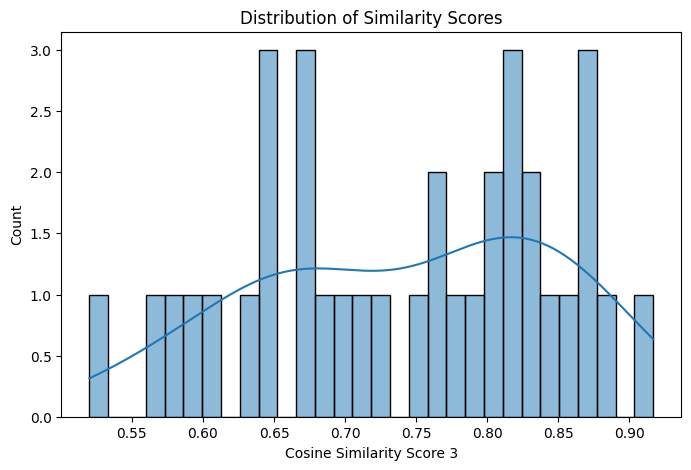

Average Cosine Similarity: 0.7373


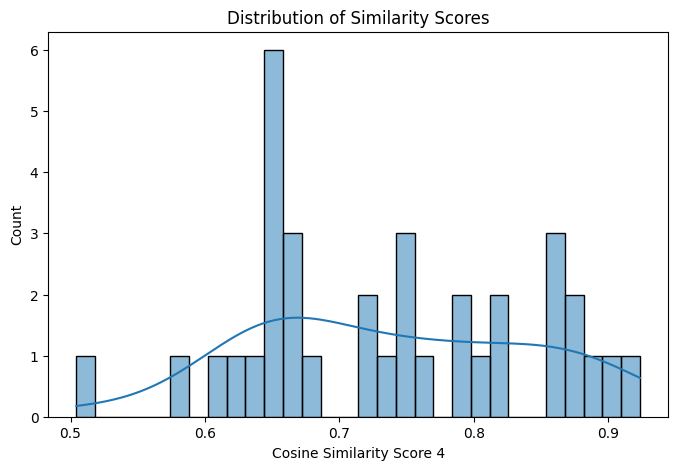

In [61]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

def add_emb(num):
    col_name = f"gpt_{num}_res_emb"
    test_df[col_name] = test_df[col_name].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)
    similarity = f"similarity_{num}"
    test_df[similarity] = test_df.apply(lambda row: cosine_similarity([row["תוצאה מסכמת- embeddings"]], [row[col_name]])[0][0], axis=1)


    average_similarity = test_df[similarity].mean()
    print(f"Average Cosine Similarity: {average_similarity:.4f}")

    plt.figure(figsize=(8, 5))
    sns.histplot(test_df[similarity], bins=30, kde=True)
    plt.xlabel(f"Cosine Similarity Score {num}")
    plt.ylabel("Count")
    plt.title("Distribution of Similarity Scores")
    plt.show()

add_emb(3)
add_emb(4)

In [62]:
# high_sim_cases = test_df[test_df["similarity"] >= 0.8][["תוצאה מסכמת", "gpt_res"]]
# for index, row in high_sim_cases.iterrows():
#     print(f"**Case {index}:**")
#     print(f"**Original Text:** {row['תוצאה מסכמת']}")  # מציג חלק מהטקסט
#     print(f"**GPT Summary:** {row['gpt_res']}")
#     print("-" * 100)


In [63]:
def check_lows_sim(num):
    similarity = f"similarity_{num}"
    gpt_res = f"gpt_{num}_res"
    low_sim_cases = test_df[test_df[similarity] < 0.6][["תוצאה מסכמת", gpt_res]]
    print(f"GPT {num}:")
    for index, row in low_sim_cases.iterrows():
        print(f"**Case {index}:**")
        print(f"**Original Text:** {row['תוצאה מסכמת']}")  # מציג חלק מהטקסט
        print(f"**GPT Summary:** {row[gpt_res]}")
        print("-" * 50)
    print("-" * 100)
check_lows_sim(3)
check_lows_sim(4)

GPT 3:
**Case 2971:**
**Original Text:** בקשה אחרת
בקשה לשנוי מועד הגשה
**GPT Summary:** המועד החדש להגשת החלטת המדינה תקבע ל-24.3.13.
--------------------------------------------------
**Case 1328:**
**Original Text:** ״הבקשה נדחית״
**GPT Summary:** הבקשה לרשות ערעור נדחתה על פי החלטת בית המשפט העליון, שהחליט כי אף שהבקשה עלולה להעיר שאלה עקרונית, אין רשות ערעור למקרה שאינו מתאים לדיון באותה שאלה. המשנה לנשיאה נפסק שהבקשה נדחית.
--------------------------------------------------
**Case 2348:**
**Original Text:** בקשה אחרת
בקשה לעיון חוזר
**GPT Summary:** ההחלטה קבעה כי לא הייתה צורך לזמן את עורכי התעבירויות ציבוריים להעיד ולרשום אותם כעדים של המשיבה בכתב האישום בהליך בדיקת הינשוף. לכן הבקשה נדחתה.
--------------------------------------------------
**Case 2282:**
**Original Text:** בקשת רשות הערעור נדחית
**GPT Summary:** המסמך מתייחס לביטחון הכביש ולחוקי התעבורה במקרה בו מנהיג הרכב הוא נבדק לקיום סם מסוכן בגופו. בהתאם להלכות ולתקנות המוגדרות, על מנהיג הרכב יש חובה לעבור בדיקת שתן להוכח

In [64]:
df = pd.merge(df, check_gender_bias, on="מספר הליך", how="left", suffixes=('', '_dup'))

df = df.loc[:, ~df.columns.str.endswith('_dup')]


In [65]:
df.columns

Index(['גוף המסמך', 'מספר הליך', 'שם הליך', 'שנת פתיחת ההליך',
       'גוף המסמך חתוך', 'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'הערות', 'הערות קידוד חוזר',
       'טקסט שמצביע על התוצאה', 'הערות תוצאת ערעור', 'length', 'תוצאה מסכמת',
       'מספר השופטים', 'מגדר'],
      dtype='object')

In [66]:
import openai
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import ast


ניתוח סטטיסטי על הקשר בין מספר השופטים לבין שיעור קבלת בקשות לרשות ערעור.


<Figure size 1000x600 with 0 Axes>

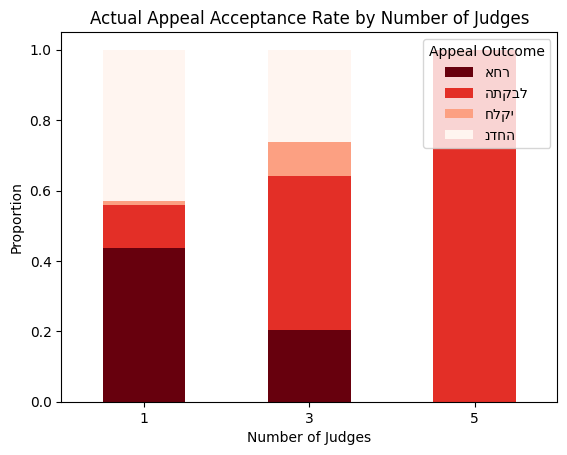

Chi-Square Test: p-value = 0.0000
A statistically significant relationship exists between the number of judges and appeal acceptance.


In [67]:
# Ensure 'מגדר' column is properly formatted as a list
def safe_eval(value):
    """ Convert string representation of a list to an actual list safely. """
    if isinstance(value, str):
        try:
            return ast.literal_eval(value)  # Convert string to list
        except (SyntaxError, ValueError):
            return None  # If conversion fails, return None
    elif isinstance(value, list):
        return value
    else:
        return None  # If it's NaN or other type, return None

df["מגדר"] = df["מגדר"].apply(safe_eval)

# Drop rows where we don't have judge information
df = df[df["מגדר"].notna()]

# Create a new column for number of judges
df["num_judges"] = df["מגדר"].apply(len)


df = df[df["num_judges"] > 0]


# Count occurrences of appeal acceptance based on number of judges
real_counts = df.groupby("num_judges")["בקשה לרשות ערעור התקבלה?"].value_counts().unstack().fillna(0)

# Plot real data
plt.figure(figsize=(10, 6))
real_counts.div(real_counts.sum(axis=1), axis=0).plot(kind="bar", stacked=True, colormap="Reds_r")
plt.title("Actual Appeal Acceptance Rate by Number of Judges")
plt.xlabel("Number of Judges")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.legend(title="Appeal Outcome")
plt.show()

# Chi-Square test to check statistical significance
chi2, p_value, _, _ = stats.chi2_contingency(real_counts)
print(f"Chi-Square Test: p-value = {p_value:.4f}")

# Interpretation
if p_value > 0.05:
    print("No statistically significant relationship between the number of judges and appeal acceptance.")
else:
    print("A statistically significant relationship exists between the number of judges and appeal acceptance.")


In [68]:
# def gpt_explain_patterns(case_text, model):
#     """ שולח את ההחלטה של הערעור ל-GPT כדי להסביר את הנימוקים המשפטיים מאחוריה. """
#     response = client.chat.completions.create(
#         model=model,
#         messages=[
#             {"role": "system", "content": "אתה מומחה משפטי. הסבר את הנימוקים מאחורי ההחלטה במקרה הנתון."},
#             {"role": "user", "content": f"Case Decision: {case_text}\n\nמהם הגורמים המרכזיים המשפיעים על ההחלטה?"}
#         ]
#     )
#     return response.choices[0].message.content

# # יצירת עמודות נפרדות להסברים מ-GPT-3 ול-GPT-4
# df["model_patterns_gpt3"] = df["בקשה לרשות ערעור התקבלה?"].apply(lambda x: gpt_explain_patterns(x, "gpt-3.5-turbo"))
# df["model_patterns_gpt4"] = df["בקשה לרשות ערעור התקבלה?"].apply(lambda x: gpt_explain_patterns(x, "gpt-4-turbo"))

# # הצגת דוגמאות ראשונות
# print(df[["בקשה לרשות ערעור התקבלה?", "model_patterns_gpt3", "model_patterns_gpt4"]].head())


In [69]:
# import pandas as pd
# import scipy.stats as stats

# def evaluate_model_predictions(df, model_col, true_col, num_judges_col):
#     """
#     בודק האם יש קשר בין מספר השופטים להחלטת הערעור בתחזיות המודל לעומת הנתונים האמיתיים.

#     :param df: DataFrame עם הנתונים המשפטיים
#     :param model_col: שם העמודה עם תחזיות המודל
#     :param true_col: שם העמודה עם תוצאות הערעור האמיתיות
#     :param num_judges_col: שם העמודה עם מספר השופטים
#     :return: None (מדפיס תוצאות)
#     """
#     # חישוב מספר השופטים בפועל
#     df["num_judges"] = df[num_judges_col].apply(len)

#     # יצירת עמודת תחזיות – האם הערעור התקבל על בסיס התשובות של המודל
#     df[f"{model_col}_predicted_outcome"] = df[model_col].apply(lambda x: "התקבל" if "ערעור התקבל" in x else "נדחה")

#     # יצירת טבלת שכיחות - השוואת תוצאות אמיתיות מול תחזיות המודל
#     comparison_table = df.groupby("num_judges")[[true_col, f"{model_col}_predicted_outcome"]].value_counts().unstack()
#     comparison_table.fillna(0, inplace=True)

#     # בדיקת מתאם סטטיסטי בין מספר השופטים לבין קבלת הערעור בתחזיות המודל
#     chi2, p_value, _, _ = stats.chi2_contingency(comparison_table)
#     print(f"Chi-Square Test ({model_col} Predictions): p-value = {p_value:.4f}")

#     if p_value > 0.05:
#         print(f"המודל {model_col} לא למד את הדפוס בין מספר השופטים לקבלת הערעור.")
#     else:
#         print(f"המודל {model_col} הצליח ללמוד את הדפוס בין מספר השופטים לקבלת הערעור.")

# # הרצת הבדיקה עבור GPT-3
# evaluate_model_predictions(df, "model_patterns_gpt3", "בקשה לרשות ערעור התקבלה?", "מגדר")

# # הרצת הבדיקה עבור GPT-4
# evaluate_model_predictions(df, "model_patterns_gpt4", "בקשה לרשות ערעור התקבלה?", "מגדר")


In [70]:
# Load test dataset
def load_jsonl(filename):
    with open(filename, "r", encoding="utf-8") as f:
        return [json.loads(line) for line in f]

test_data = load_jsonl("test.jsonl")

In [71]:
test_df.columns

Index(['גוף המסמך', 'מספר הליך', 'שם הליך', 'שנת פתיחת ההליך',
       'גוף המסמך חתוך', 'בקשה לרשות ערעור התקבלה?', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'length', 'תוצאה מסכמת', 'gpt_3_res',
       'gpt_4_res', 'תוצאה מסכמת- embeddings', 'gpt_3_res_emb',
       'gpt_4_res_emb', 'similarity_3', 'similarity_4'],
      dtype='object')

### Factuality / faithfulness

In [72]:
import pandas as pd
import re
from tqdm import tqdm

# פונקציה להערכת האמינות
def evaluate_factuality(original_text, generated_summary, model="gpt-4-turbo"):
    """
    מעריך את מידת הנאמנות של הסיכום לטקסט המקורי בסקאלה של 1-5.
    המודל מחזיר מספר בלבד.
    """
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": 'אתה מומחה משפטי. דרג את מידת הנאמנות של התקציר לטקסט המקורי בסולם של 1-5, כאשר 5 הוא הנאמנות הגבוהה ביותר. השב **רק עם מספר בודד** ללא טקסט נוסף.'},
                {"role": "user", "content": f"פסק דין: {original_text}\n\nסיכום: {generated_summary}\n\nעד כמה הסיכום מדויק ונאמן למקור?"}
            ]
        )
        return response.choices[0].message.content.strip()  # מחזיר את הטקסט כמות שהוא
    except Exception as e:
        print(f"Error processing case: {e}")
        return None  # במקרה של שגיאה נחזיר None

# פונקציה לחילוץ מספר מהתשובה
def extract_score(response_text):
    """ מחלץ מספר מתוך תשובת המודל """
    match = re.search(r'\b[1-5]\b', response_text)  # מחפש מספר בין 1 ל-5
    return int(match.group()) if match else None  # מחזיר את המספר אם נמצא, אחרת None

# הוספת tqdm להתקדמות הביצוע
tqdm.pandas()

# בדיקת האמינות על 5 דוגמאות ראשונות לכל מודל
faithfulness_scores_gpt3 = []
faithfulness_scores_gpt4 = []

for i, row in tqdm(test_df.iloc[:5].iterrows(), total=5):
    original_text = row["גוף המסמך חתוך"]

    # הערכת נאמנות עבור gpt_3
    faithfulness_gpt3 = extract_score(evaluate_factuality(original_text, row["gpt_3_res"], model="gpt-4-turbo"))
    faithfulness_scores_gpt3.append(faithfulness_gpt3)

    # הערכת נאמנות עבור gpt_4
    faithfulness_gpt4 = extract_score(evaluate_factuality(original_text, row["gpt_4_res"], model="gpt-4-turbo"))
    faithfulness_scores_gpt4.append(faithfulness_gpt4)

    # הדפסת תוצאות לכל מקרה
    print(f"\nCase {i+1}:")
    print("Original Judgment:", original_text)
    print("GPT-3 Summary:", row["gpt_3_res"])
    print("GPT-4 Summary:", row["gpt_4_res"])
    print(f"Faithfulness Score (GPT-3): {faithfulness_gpt3}")
    print(f"Faithfulness Score (GPT-4): {faithfulness_gpt4}")
    print("-------------------------------------------------")

# חישוב ממוצע הציונים לכל מודל
avg_faithfulness_gpt3 = sum(score for score in faithfulness_scores_gpt3 if score is not None) / len(faithfulness_scores_gpt3)
avg_faithfulness_gpt4 = sum(score for score in faithfulness_scores_gpt4 if score is not None) / len(faithfulness_scores_gpt4)

print(f"\nAverage Faithfulness Score (GPT-3 Fine-Tuned): {avg_faithfulness_gpt3:.2f}")
print(f"Average Faithfulness Score (GPT-4 Fine-Tuned): {avg_faithfulness_gpt4:.2f}")


 20%|██        | 1/5 [00:03<00:12,  3.09s/it]


Case 2552:
Original Judgment: ['החלטה בתיק רע"פ 8681/16 בבית המשפט העליון רע"פ 8681/16 - ג\' לפני: כבוד השופט ס\' ג\'ובראן כבוד השופט נ\' הנדל כבוד השופט א\' שהם המבקשת: פלונית נגד המשיבה: מדינת ישראל בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני בשם המבקשת: עו"ד אדוארד גאנם בשם המשיבה: עו"ד תמר בורנשטיין החלטה לאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת. ניתנה היום, ה\' בשבט התשע"ז (1.2.2017). ש ו פ ט ש ו פ ט ש ו פ ט _________________________ 
GPT-3 Summary: הבקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום נדחית ולא חולקה לה.
GPT-4 Summary: החלטת בית המשפט העליון בתיק רע"פ 8681/16, דוחה את הבקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני.
Faithfulness Score (GPT-3): 5
Faithfulness Score (GPT-4): 5
-------------------------------------------------


 40%|████      | 2/5 [00:04<00:06,  2.01s/it]


Case 3005:
Original Judgment: ['פסק דין בתיק רע"פ 4386/08 בבית המשפט העליון רע"פ 4386/08 בפני: כבוד השופטת א\' פרוקצ\'יה כבוד השופט א\' רובינשטיין כבוד השופט ס\' ג\'ובראן המבקש: גד כהן נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בירושלים מיום 30.4.08 בע"פ 2074/08 שניתן על-ידי כבוד השופט ע\' חבש – סג"נ בשם המבקש: עו"ד דוד גולן בשם המשיבה: עו"ד מיטל בוכמן-שינדל פסק דין לאור הסכמת הצדדים, המוצאת את ביטויה בסעיף 3 לתגובת המשיבה, ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנו בעניינו של המבקש מבוטלים בזאת, והתיק מוחזר לבית משפט השלום לתעבורה בירושלים לדיון מחודש בעניינו. ניתן היום, א\' בחשון התשס"ט (30.10.2008). ש ו פ ט ת ש ו פ ט ש ו פ ט _________________________ 
GPT-3 Summary: המקורד ערעור מתקבל, הפסק-דין שהונה על ידי בית משפט מחוזי מבוטל והתיק מוחזר לבית משפט לדיון חוזר.
GPT-4 Summary: רשות הערעור ניתנת על פסק הדין המחוזי והפסקים הנלווים נשוא הערעור מבוטלים. התיק יוחזר לבית משפט השלום לתעבורה בירושלים לדיון מחודש.
Faithfulness Scor

 60%|██████    | 3/5 [00:05<00:03,  1.69s/it]


Case 3371:
Original Judgment: ['החלטה בתיק רע"פ 4137/14 בבית המשפט העליון רע"פ 4137/14 לפני: כבוד השופט א\' שהם המבקשת: ידיעות תקשורת בע"מ נגד המשיבים: 1. פלוני 2. מדינת ישראל 3. פלונית 4. פלונית בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בבאר שבע, מיום 5.6.2014, בע"פ 672-06-14, שניתן על ידי כב\' השופטת נ\' נצר תאריך הישיבה: כ"ב באב התשע"ד (18.8.2014) בשם המבקשת: עו"ד תמיר גליק; עו"ד עמר זיו-אשכר בשם המשיב 1: עו"ד נועם בונדר בשם המשיבה 2: עו"ד מורן פולמן בשם המשיבות 4-3: עו"ד מירי ביטון-הראל החלטה נדחה לעיון ולהחלטה ניתנה היום, כ"ב באב התשע"ד (\u200f18.8.2014). ש ו פ ט _________________________ 
GPT-3 Summary: הבית המשפט העליון דחה בפסק דין רשות הערעור פלילי (רע"פ) שהוגש על פסק דין של בית המשפט המחוזי בבאר שבע.
GPT-4 Summary: בית המשפט העליון דחה בקשת רשות ערעור שהגישה המבקשת, ידיעות תקשורת בע"מ, על פסק דין של בית המשפט המחוזי בבאר שבע מיום 5.6.2014.
Faithfulness Score (GPT-3): 4
Faithfulness Score (GPT-4): 4
-------------------------------------------------


 80%|████████  | 4/5 [00:07<00:01,  1.57s/it]


Case 2650:
Original Judgment: ['בבית המשפט העליון בירושלים רע"פ 9608/01 בפני: כבוד השופט א\' ריבלין המבקשים: 1. גשמי ברכה ה.ש.י.ג.(1995) 2. גשמי ברכה בע"מ 3. ה.ש.י.ג.(1995)יזום פרוייקטים 4. שנהב זאב נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בתל-אביב-יפו מיום 23.10.2001 בתיק עפ"א 80190/01 שניתן על ידי כבוד השופטים: ד\' ברלינר, ז\' המר, י\' שטופמן בשם המבקשים: עו"ד שרית שלמון בשם המשיבה: עו"ד ענבר פלש החלטה בית המשפט לעניינים מקומיים בפתח תקוה (כבוד השופט ג\' שטרסמן) ביטל את כתב האישום שהוגש כנגד המבקשים, והמייחס להם ביצוע עבירות טעונות היתר בסטיה מהיתר או מתכנית. ערעורה של המדינה על החלטה זו, לבית המשפט המחוזי בתל-אביב (כבוד השופטים ד\' ברלינר, ז\' המר וי\' שטופמן) - התקבל. ההחלטה בדבר ביטול כתב האישום בוטלה, והדיון הוחזר לבית המשפט לעניינים מקומיים, להמשך בירורו למן השלב אליו הגיע. כנגד פסק-דינו של בית המשפט המחוזי מופנית הבקשה שלפנינו. דא עקא, משטרם נתברר, וממילא טרם הוכרע, עניינם של המבקשים - לגופו - בערכאה הראשונה, אין מקום לדון בטענותיהם בפני בית משפט

100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


Case 2972:
Original Judgment: ['החלטה בתיק רע"פ 5340/12 בבית המשפט העליון רע"פ 5340/12 - ד\' לפני: כבוד השופט א\' רובינשטיין כבוד השופט נ\' סולברג כבוד השופט א\' שהם המבקש: אנטולי צבישב נגד המשיבה: מדינת ישראל בקשה לשנוי מועד הגשה החלטה כמבוקש תוגש תגובת המדינה 24.3.13. לא ראינו מקום לתגובה נוספת מטעם המבקש. ניתנה היום, כ"ב באדר תשע"ג (4.3.13). ש ו פ ט ש ו פ ט ש ו פ ט _________________________ 
GPT-3 Summary: המועד החדש להגשת החלטת המדינה תקבע ל-24.3.13.
GPT-4 Summary: ההחלטה בתיק רע"פ 5340/12 קובעת שתגובת המדינה תוגש עד לתאריך 24.3.13. לא נמצא לנכון לאפשר תגובה נוספת מצד המבקש. ההחלטה ניתנה בתאריך 4.3.13.
Faithfulness Score (GPT-3): 5
Faithfulness Score (GPT-4): 5
-------------------------------------------------

Average Faithfulness Score (GPT-3 Fine-Tuned): 4.80
Average Faithfulness Score (GPT-4 Fine-Tuned): 4.80


#### BLEU & ROUGE

In [73]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge

# אתחול tqdm
tqdm.pandas()

# אתחול מחלקת ROUGE
rouge = Rouge()

# רשימות לאיסוף ציונים
bleu_scores_gpt3, rouge_scores_gpt3 = [], []
bleu_scores_gpt4, rouge_scores_gpt4 = [], []

# חישוב BLEU ו-ROUGE עבור 10 פסקי דין ראשונים
for i, row in tqdm(test_df.iloc[:10].iterrows(), total=10):
    reference_summary = row["תוצאה מסכמת"]  # הסיכום שנכתב ע"י המשפטנים
    gpt3_summary = row["gpt_3_res"]
    gpt4_summary = row["gpt_4_res"]

    # המרת משפטים לרשימות מילים עבור BLEU
    reference_tokens = reference_summary.split()
    gpt3_tokens = gpt3_summary.split()
    gpt4_tokens = gpt4_summary.split()

    # חישוב BLEU עם smoothing (למנוע 0 בתוצאות קצרות)
    smoothie = SmoothingFunction().method1
    bleu_gpt3 = sentence_bleu([reference_tokens], gpt3_tokens, smoothing_function=smoothie)
    bleu_gpt4 = sentence_bleu([reference_tokens], gpt4_tokens, smoothing_function=smoothie)

    # חישוב ROUGE
    rouge_gpt3 = rouge.get_scores(gpt3_summary, reference_summary)[0]
    rouge_gpt4 = rouge.get_scores(gpt4_summary, reference_summary)[0]

    # שמירת ציונים לרשימות
    bleu_scores_gpt3.append(bleu_gpt3)
    rouge_scores_gpt3.append(rouge_gpt3["rouge-l"]["f"])
    bleu_scores_gpt4.append(bleu_gpt4)
    rouge_scores_gpt4.append(rouge_gpt4["rouge-l"]["f"])

    # הדפסת תוצאות לכל מקרה
    print("=" * 60)
    print(f"פסק דין {i+1}:")
    print("-" * 60)
    print(" סיכום המשפטנים:", reference_summary)
    print("\nGPT-3 סיכום:", gpt3_summary)
    print(f"BLEU (GPT-3): {bleu_gpt3:.4f} | ROUGE-L (GPT-3): {rouge_gpt3['rouge-l']['f']:.4f}")
    print("\n GPT-4 סיכום:", gpt4_summary)
    print(f"BLEU (GPT-4): {bleu_gpt4:.4f} | ROUGE-L (GPT-4): {rouge_gpt4['rouge-l']['f']:.4f}")
    print("=" * 60)

# חישוב ממוצע ציונים לכל מודל
avg_bleu_gpt3 = np.mean(bleu_scores_gpt3)
avg_rouge_gpt3 = np.mean(rouge_scores_gpt3)
avg_bleu_gpt4 = np.mean(bleu_scores_gpt4)
avg_rouge_gpt4 = np.mean(rouge_scores_gpt4)

# הדפסת ממוצע כולל
print("\n📊 **ממוצע ציונים לכל מודל:**")
print(f" **BLEU ממוצע (GPT-3):** {avg_bleu_gpt3:.4f} | **ROUGE-L ממוצע (GPT-3):** {avg_rouge_gpt3:.4f}")
print(f" **BLEU ממוצע (GPT-4):** {avg_bleu_gpt4:.4f} | **ROUGE-L ממוצע (GPT-4):** {avg_rouge_gpt4:.4f}")


100%|██████████| 10/10 [00:00<00:00, 491.42it/s]

פסק דין 2552:
------------------------------------------------------------
 סיכום המשפטנים: בקשה אחרת
בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני
נראה שהבקשה נדחתה
לאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת.

GPT-3 סיכום: הבקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום נדחית ולא חולקה לה.
BLEU (GPT-3): 0.1384 | ROUGE-L (GPT-3): 0.4681

 GPT-4 סיכום: החלטת בית המשפט העליון בתיק רע"פ 8681/16, דוחה את הבקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני.
BLEU (GPT-4): 0.1926 | ROUGE-L (GPT-4): 0.4151
פסק דין 3005:
------------------------------------------------------------
 סיכום המשפטנים: ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנו בעניינו של המבקש מבוטלים בזאת, והתיק מוחזר לבית משפט השלום לתעבורה

GPT-3 סיכום: המקורד ערעור מתקבל, הפסק-דין שהונה על ידי בית משפט מחוזי מבוטל והתיק מוחזר לבית משפט לדיון חוזר.
BLEU (GPT-3): 0.0948 | ROUG

#### NTI

In [74]:


# פונקציה לבדיקת הגינות ונאמנות בשיטת NLI
def check_nli_fairness(model_name, original_text, generated_summary):
    """
    בודקת האם הסיכום תואם לטקסט המשפטי, ניטרלי או מכיל סתירות.

    :param model_name: שם המודל (gpt_3 או gpt_4)
    :param original_text: הטקסט המשפטי המלא
    :param generated_summary: הסיכום שנוצר על ידי המודל
    :return: תוצאה - "נתמך", "ניטרלי" או "סתירה"
    """
    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "אתה מומחה למשפטים ולניתוח לשוני. בדוק האם הסיכום תואם לחלוטין לפסק הדין המקורי, כולל ההשלכות המשפטיות."},
                {"role": "user", "content": f"טקסט משפטי: {original_text}\n\nסיכום המודל: {generated_summary}\n\nהאם הסיכום נתמך במלואו בטקסט המקורי, ניטרלי (כולל מידע נוסף), או מכיל סתירות?"}
            ]
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"שגיאה בבדיקת NLI ({model_name}): {e}")
        return None

# הוספת tqdm להצגת ההתקדמות
tqdm.pandas()

# בדיקה על 10 פסקי דין ראשונים
nli_results_gpt3 = []
nli_results_gpt4 = []

for i, row in tqdm(test_df.iloc[:10].iterrows(), total=10):
    original_text = row["גוף המסמך חתוך"]
    reference_summary = row["תוצאה מסכמת"]  # הסיכום שנכתב ע"י משפטנים
    gpt3_summary = row["gpt_3_res"]
    gpt4_summary = row["gpt_4_res"]

    # בדיקת NLI עבור GPT-3
    nli_gpt3 = check_nli_fairness(gpt_3, original_text, gpt3_summary)
    nli_results_gpt3.append(nli_gpt3)

    # בדיקת NLI עבור GPT-4
    nli_gpt4 = check_nli_fairness(gpt_4, original_text, gpt4_summary)
    nli_results_gpt4.append(nli_gpt4)

    # הדפסת תוצאות לכל מקרה
    print("=" * 60)
    print(f"פסק דין {i+1}:")
    print("-" * 60)
    print("🔹 סיכום המשפטנים:", reference_summary)
    print("\n🔹 GPT-3 סיכום:", gpt3_summary)
    print(f"NLI (GPT-3): {nli_gpt3}")
    print("\n🔹 GPT-4 סיכום:", gpt4_summary)
    print(f"NLI (GPT-4): {nli_gpt4}")
    print("=" * 60)

# ספירת מספר המקרים לכל קטגוריה
nli_counts_gpt3 = pd.Series(nli_results_gpt3).value_counts()
nli_counts_gpt4 = pd.Series(nli_results_gpt4).value_counts()

# הדפסת סיכום
print("\n **תוצאות סופיות של NLI:**")
print("\n **GPT-3**")
print(nli_counts_gpt3)
print("\n **GPT-4**")
print(nli_counts_gpt4)


 10%|█         | 1/10 [00:02<00:24,  2.72s/it]

פסק דין 2552:
------------------------------------------------------------
🔹 סיכום המשפטנים: בקשה אחרת
בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני
נראה שהבקשה נדחתה
לאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת.

🔹 GPT-3 סיכום: הבקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום נדחית ולא חולקה לה.
NLI (GPT-3): כן, הסיכום תואם במלואו לטקסט המקורי.

🔹 GPT-4 סיכום: החלטת בית המשפט העליון בתיק רע"פ 8681/16, דוחה את הבקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני.
NLI (GPT-4): ניטרלי (כולל מידע נוסף)


 20%|██        | 2/10 [00:04<00:18,  2.32s/it]

פסק דין 3005:
------------------------------------------------------------
🔹 סיכום המשפטנים: ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנו בעניינו של המבקש מבוטלים בזאת, והתיק מוחזר לבית משפט השלום לתעבורה

🔹 GPT-3 סיכום: המקורד ערעור מתקבל, הפסק-דין שהונה על ידי בית משפט מחוזי מבוטל והתיק מוחזר לבית משפט לדיון חוזר.
NLI (GPT-3): הסיכום נתון מלואו על פי הטקסט המקורי.

🔹 GPT-4 סיכום: רשות הערעור ניתנת על פסק הדין המחוזי והפסקים הנלווים נשוא הערעור מבוטלים. התיק יוחזר לבית משפט השלום לתעבורה בירושלים לדיון מחודש.
NLI (GPT-4): נראה שהסיכום תואם למידע בפסק הדין.


 30%|███       | 3/10 [00:06<00:15,  2.28s/it]

פסק דין 3371:
------------------------------------------------------------
🔹 סיכום המשפטנים: נדחה לעיון ולהחלטה

🔹 GPT-3 סיכום: הבית המשפט העליון דחה בפסק דין רשות הערעור פלילי (רע"פ) שהוגש על פסק דין של בית המשפט המחוזי בבאר שבע.
NLI (GPT-3): הסיכום תואם במלואו לפסק הדין המקורי, ולא כל הפרטים בטקסט אך בצורה כללית.

🔹 GPT-4 סיכום: בית המשפט העליון דחה בקשת רשות ערעור שהגישה המבקשת, ידיעות תקשורת בע"מ, על פסק דין של בית המשפט המחוזי בבאר שבע מיום 5.6.2014.
NLI (GPT-4): נראה שהבקשה עדיין בתהליך ולא התקבלה החלטה סופית
״החלטה נדחה לעיון ולהחלטה״


 40%|████      | 4/10 [00:09<00:15,  2.51s/it]

פסק דין 2650:
------------------------------------------------------------
🔹 סיכום המשפטנים: דא עקא, משטרם נתברר, וממילא טרם הוכרע, עניינם של המבקשים - לגופו - בערכאה הראשונה, אין מקום לדון בטענותיהם בפני בית משפט זה. לאחר שימוצו ההליכים בבית משפט השלום, ואם יהיה צורך גם בבית המשפט המחוזי - יהיו רשאים המבקשים - שוב, אם יהיה צורך - לפנות לבית משפט זה בבקשת רשות ערעו

🔹 GPT-3 סיכום: המערעור שהוגש על החלטת בית המשפט לעניינים מקומיים בפתח תקוה, המבטלת את כתב האישום נגד המבקשים, בוטלה והדיון הוחזר לבית המשפט לעניינים מקומיים להמשך טיפול. המשפט החליט שטרם נקבעה ערכאה ראשונה לעניין המבקשים, ולכן אין מקום לדיון בטענותיהם בבית המשפט העליון.
NLI (GPT-3): כן, סיכום המודל מדווח בצורה נכונה על תוצאת המערעור והחלטת בית המשפט העליון.

🔹 GPT-4 סיכום: בית המשפט העליון דחה את בקשת רשות הערעור שהוגשה נגד החלטת בית המשפט המחוזי בתל-אביב, שביטלה החלטת בית המשפט לעניינים מקומיים בפתח תקווה לביטול כתב האישום כנגד המבקשים. משום שהדיון בעניין המבקשים טרם הוכרע בערכאה הראשונה, נקבע כי אין מקום לדון בטענותיהם בע

 50%|█████     | 5/10 [00:11<00:11,  2.38s/it]

פסק דין 2972:
------------------------------------------------------------
🔹 סיכום המשפטנים: בקשה אחרת
בקשה לשנוי מועד הגשה

🔹 GPT-3 סיכום: המועד החדש להגשת החלטת המדינה תקבע ל-24.3.13.
NLI (GPT-3): הסיכום נתמך בטקסט המקורי כמעט במלואו. הבקשה המקורית לשנוי מועד הגשה נמצאת בשורה ראשונה והעניין הושלם בהצלחה.

🔹 GPT-4 סיכום: ההחלטה בתיק רע"פ 5340/12 קובעת שתגובת המדינה תוגש עד לתאריך 24.3.13. לא נמצא לנכון לאפשר תגובה נוספת מצד המבקש. ההחלטה ניתנה בתאריך 4.3.13.
NLI (GPT-4): נראה שמדובר בסיכום ניטרלי (כולל מידע נוסף).


 60%|██████    | 6/10 [00:15<00:10,  2.72s/it]

פסק דין 929:
------------------------------------------------------------
🔹 סיכום המשפטנים: אחר שעיינו בבקשה, בתגובת המשיבה ובפסקי הדין של הערכאות הקודמות, הגענו לכלל מסקנה כי דין הבקשה – להתקבל בחלקה.... בקשת רשות הערעור מתקבלת בחלקה, כך שהחיוב בהוצאות שהוטל על המבקש בבית המשפט המחוזי – בטל. שאר רכיבי בקשת הערעור נדחים
דלמטה מיוחד
-  הערעור התקבל באופן חלקי, תכנון ובנייה

🔹 GPT-3 סיכום: הערעת פסק הדין בבית המשפט העליון מבית המשפט המחוזי מתקבלת בחלקה והחיוב בהוצאות המשפטיות על המבקש בבית המשפט המחוזי נבטל. נדחתה את שאר רכיבי הערעור. השופטים מסכימים עם החלטתם של חברי המשפט בעניין ההוצאות, ומבטיחים כי גם במקרים בהם הדברים נעשים לא בתום לב, יש מקום להוטית הוצאות במשפט הפלילי.
NLI (GPT-3): הסיכום נתמך בטקסט המקורי במלואו, וכולל תוספת של "ומבטיחים כי גם במקרים בהם הדברים נעשים לא בתום לב, יש מקום להוטית הוצאות במשפט הפלילי".

🔹 GPT-4 סיכום: הערעור שבדיון נדחה בחלקו ונתקבל בחלקו. ההכרעה קבעה שאין הצדקה לבטל את גזר הדין עקב היעדרות בא כוח המשיבה, מאחר והוא היה נוכח בכל שלבי הדיון וזאת אף שהיה

 70%|███████   | 7/10 [00:17<00:07,  2.42s/it]

פסק דין 1329:
------------------------------------------------------------
🔹 סיכום המשפטנים: ״הבקשה נדחית״

🔹 GPT-3 סיכום: הבקשה לרשות ערעור נדחתה על פי החלטת בית המשפט העליון, שהחליט כי אף שהבקשה עלולה להעיר שאלה עקרונית, אין רשות ערעור למקרה שאינו מתאים לדיון באותה שאלה. המשנה לנשיאה נפסק שהבקשה נדחית.
NLI (GPT-3): הסיכום נתמך במלואו בטקסט המקורי

🔹 GPT-4 סיכום: בתיק רע"פ 9272/20, בית המשפט העליון דחה את בקשת הרשות לערעור שהוגשה על ידי זינובי שומכר נגד מדינת ישראל. ההחלטה מובילה למסקנה שאף אם בקשת רשות ערעור מעלה שאלה עקרונית, היא לא תתקבל אם המקרה עצמו אינו מתאים לדיון בנושא הנדון. בית המשפט קובע כי אופן התנהלות ההליכים הקודמים והטענות שהועלו בהם אינם משקפים תשתית דיונית מתאימה לשאלה העקרונית הנדונה, ולכן לא נכון להעלות סוגיות נוספות במסגרת הערעור הנוכחי. הבקשה לערעור נדחתה.
NLI (GPT-4): ניטרלי (כולל מידע נוסף)


 80%|████████  | 8/10 [00:20<00:05,  2.75s/it]

פסק דין 2951:
------------------------------------------------------------
🔹 סיכום המשפטנים: בקשה אחרת
לאחר קבלת חוות-דעת הממונה על עבודות השירות, ולאחר שהמבקשנתן הסכמתו למוצע בה, אנו קובעים שהמבקש יבצע את ששת חודשי המאסר בפועל שהוטלועליו בעבודות שירות באגודה למען הקשיש יקנעם, יקנעם עלית בהתאם למתכונת שנקבעהבחוות-דעתו של הממונה על עבודות השירות.

🔹 GPT-3 סיכום: המבקש יבצע את ששת חודשי המאסר בפועל שהוטלו עליו בעבודות שירות באגודה למען הקשיש ביקנעם, ונקבע כי הוא יתחיל בריצוי עונשו ביום 1.11.04.
NLI (GPT-3): סיכום המודל מכיל מידע נוסף בנוגע לבקשה המקורית, אולם הוא אינו מכיל את כל המידע מהפסק-הדין המקורי. מלבד כך, הסיכום נראה כשהוא נתמך בטקסט המקורי.

🔹 GPT-4 סיכום: בבקשת רשות ערעור על פסק-דין שניתן על ידי בית המשפט המחוזי בחיפה, החליט בית המשפט העליון לאשר את ההסכם לביצוע שישה חודשי מאסר בפועל בעבודות שירות, בהתאם למתכונת שנקבעה בחוות דעת הממונה על עבודות השירות, באגודה למען הקשיש יקנעם. הריצוי יתחיל ב-1.11.04.
NLI (GPT-4): נראה שהטקסטים עוסקים ברכיבים שונים של ההליך - הסיכום עוסק בשינוי 

 90%|█████████ | 9/10 [00:23<00:02,  2.87s/it]

פסק דין 1941:
------------------------------------------------------------
🔹 סיכום המשפטנים: סוף דבר אין בידי להיעתר לבקשה

🔹 GPT-3 סיכום: הבקשה לרשות ערעור על פסק דין של בית המשפט המחוזי המדריד, שמטרתה הייתה להקביל את ההחלטה של הבית בתיק המשפטי לדינו של בית המשפט לתעבורה, נדחתה על ידי בית המשפט העליון. השופטים קבעו כי המוסד המדיני הישראלי נהג כדין ובזהירות, ולכן אי אפשר להאשים אותו בהתנהגות שלא הובילה למניעת התאונה. בנוסף, הוצגו פגמים בהליך החקירה והדין בתיק, אך השופטים החליטו כי אין ראיון שיקולי לקבלת הערעור. מכיוון שהערעור הוגש על פגמי ראיות ולא על עלולות משפטיות, ובהתבסס על טענות שכוויות, הוחלט שהוא לא מוצדק והינאים אליו נדחו.
NLI (GPT-3): ׳נדחתה על ידי בית המשפט העליון׳, ׳סוף דבר אין בידי להיעתר לבקשה׳, ׳אחר ניתוני התיק אין ראיון שיקולי לקבלת הערעור׳, ׳לאחר העיון אין בידי להיעתר לבקשה׳

🔹 GPT-4 סיכום: בבקשת רשות ערעור על פסק דין מבית המשפט המחוזי, בה נדחה ערעור על עבירת תעבורה שבה המבקש הורשע בפגיעה בהולכי רגל במעבר חציה, החלטת בית המשפט העליון הייתה לדחיית בקשת הרשות ערעור. השופט

100%|██████████| 10/10 [00:26<00:00,  2.63s/it]

פסק דין 3859:
------------------------------------------------------------
🔹 סיכום המשפטנים: בקשה אחרת
בקשה לדחיית מועד ביצוע מאסר

🔹 GPT-3 סיכום: הבקשה לדחיית מועד ביצוע מאסר נדחית.
NLI (GPT-3): הסיכום נתמך במלואו בטקסט המקורי.

🔹 GPT-4 סיכום: בתיק רע"פ 2100/03, השופטת א' חיות דחתה את הבקשה לדחיית מועד ביצוע מאסר שהוגשה על ידי המבקש דוד בן יעקב תמם נגד המשיבה מדינת ישראל. ההחלטה ניתנה באייר תשס"ג (6.5.2003).
NLI (GPT-4): ניטרלי

 **תוצאות סופיות של NLI:**

 **GPT-3**
כן, הסיכום תואם במלואו לטקסט המקורי.                                                                                                                     1
הסיכום נתון מלואו על פי הטקסט המקורי.                                                                                                                    1
הסיכום תואם במלואו לפסק הדין המקורי, ולא כל הפרטים בטקסט אך בצורה כללית.                                                                                 1
כן, סיכום המודל מדווח בצורה נכונה על תוצאת המערעור והחלטת בית 

In [75]:

from collections import Counter
import IPython.display as display

# פונקציה לבדיקת נאמנות והגינות באמצעות מודל NLI
def check_nli_faithfulness(model_name, original_text, generated_summary):
    """
    בודקת האם הסיכום שנוצר אכן משקף את ההחלטה המשפטית המקורית.

    :param model_name: שם המודל שישמש לבדיקה (GPT-4, GPT-3 וכו')
    :param original_text: הטקסט המקורי של פסק הדין
    :param generated_summary: הסיכום שנוצר מהמודל
    :return: קטגוריית NLI (Entailment, Contradiction, Neutral)
    """
    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "אתה מומחה משפטי. קבע האם הסיכום הבא משקף את המשמעות המשפטית של פסק הדין או מכיל מידע שגוי."},
                {"role": "user", "content": f"טקסט מקורי: {original_text}\n\nסיכום: {generated_summary}\n\nהאם הסיכום נכון מבחינה משפטית? בחר אחת מהאפשרויות: 'Entailment' אם הסיכום נכון, 'Contradiction' אם הסיכום שגוי, או 'Neutral' אם הוא חלקית נכון אך לא מדויק לחלוטין."}
            ]
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"שגיאה בבדיקת NLI ({model_name}): {e}")
        return None

# יצירת רשימות לאחסון התוצאות
nli_results_gpt3 = []
nli_results_gpt4 = []

# הפעלת tqdm להצגת ההתקדמות
tqdm.pandas()

# בדיקה והשוואה בין המודלים על 10 דוגמאות
for i, row in tqdm(test_df.iterrows(), total=10):
    original_text = row["גוף המסמך חתוך"]
    reference_summary = row["תוצאה מסכמת"]

    # בדיקת נאמנות עבור GPT-3
    nli_gpt3 = check_nli_faithfulness(gpt_3, original_text, row["gpt_3_res"])
    nli_results_gpt3.append(nli_gpt3)

    # בדיקת נאמנות עבור GPT-4
    nli_gpt4 = check_nli_faithfulness(gpt_4, original_text, row["gpt_4_res"])
    nli_results_gpt4.append(nli_gpt4)

    # הצגת תוצאות לכל מקרה
    print(f"\nCase {i+1}:")
    print("Reference Summary (By Research Assistants):", reference_summary)
    print("\nFine-Tuned GPT-3 Summary:", row["gpt_3_res"])
    print("NLI Result (GPT-3):", nli_gpt3)
    print("\nFine-Tuned GPT-4 Summary:", row["gpt_4_res"])
    print("NLI Result (GPT-4):", nli_gpt4)
    print("-------------------------------------------------")

# חישוב סטטיסטיקות של NLI לכל מודל
nli_counts_gpt3 = Counter(nli_results_gpt3)
nli_counts_gpt4 = Counter(nli_results_gpt4)



 10%|█         | 1/10 [00:01<00:10,  1.13s/it]


Case 2552:
Reference Summary (By Research Assistants): בקשה אחרת
בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני
נראה שהבקשה נדחתה
לאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת.

Fine-Tuned GPT-3 Summary: הבקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום נדחית ולא חולקה לה.
NLI Result (GPT-3): 'Entailment'

Fine-Tuned GPT-4 Summary: החלטת בית המשפט העליון בתיק רע"פ 8681/16, דוחה את הבקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני.
NLI Result (GPT-4): Neutral' אם הוא חלקית נכון אך לא מדויק לחלוטין.
-------------------------------------------------


 20%|██        | 2/10 [00:02<00:10,  1.33s/it]


Case 3005:
Reference Summary (By Research Assistants): ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנו בעניינו של המבקש מבוטלים בזאת, והתיק מוחזר לבית משפט השלום לתעבורה

Fine-Tuned GPT-3 Summary: המקורד ערעור מתקבל, הפסק-דין שהונה על ידי בית משפט מחוזי מבוטל והתיק מוחזר לבית משפט לדיון חוזר.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: רשות הערעור ניתנת על פסק הדין המחוזי והפסקים הנלווים נשוא הערעור מבוטלים. התיק יוחזר לבית משפט השלום לתעבורה בירושלים לדיון מחודש.
NLI Result (GPT-4): ```markdown
'Entailment'
```
-------------------------------------------------


 30%|███       | 3/10 [00:04<00:10,  1.44s/it]


Case 3371:
Reference Summary (By Research Assistants): נדחה לעיון ולהחלטה

Fine-Tuned GPT-3 Summary: הבית המשפט העליון דחה בפסק דין רשות הערעור פלילי (רע"פ) שהוגש על פסק דין של בית המשפט המחוזי בבאר שבע.
NLI Result (GPT-3): Neutral

Fine-Tuned GPT-4 Summary: בית המשפט העליון דחה בקשת רשות ערעור שהגישה המבקשת, ידיעות תקשורת בע"מ, על פסק דין של בית המשפט המחוזי בבאר שבע מיום 5.6.2014.
NLI Result (GPT-4): Neutral'
-------------------------------------------------


 40%|████      | 4/10 [00:05<00:07,  1.24s/it]


Case 2650:
Reference Summary (By Research Assistants): דא עקא, משטרם נתברר, וממילא טרם הוכרע, עניינם של המבקשים - לגופו - בערכאה הראשונה, אין מקום לדון בטענותיהם בפני בית משפט זה. לאחר שימוצו ההליכים בבית משפט השלום, ואם יהיה צורך גם בבית המשפט המחוזי - יהיו רשאים המבקשים - שוב, אם יהיה צורך - לפנות לבית משפט זה בבקשת רשות ערעו

Fine-Tuned GPT-3 Summary: המערעור שהוגש על החלטת בית המשפט לעניינים מקומיים בפתח תקוה, המבטלת את כתב האישום נגד המבקשים, בוטלה והדיון הוחזר לבית המשפט לעניינים מקומיים להמשך טיפול. המשפט החליט שטרם נקבעה ערכאה ראשונה לעניין המבקשים, ולכן אין מקום לדיון בטענותיהם בבית המשפט העליון.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: בית המשפט העליון דחה את בקשת רשות הערעור שהוגשה נגד החלטת בית המשפט המחוזי בתל-אביב, שביטלה החלטת בית המשפט לעניינים מקומיים בפתח תקווה לביטול כתב האישום כנגד המבקשים. משום שהדיון בעניין המבקשים טרם הוכרע בערכאה הראשונה, נקבע כי אין מקום לדון בטענותיהם בערעור בשלב זה. בית המשפט קבע כי לאחר השלמת ההליך בבית המשפט המחוזי, יוכלו ה

 50%|█████     | 5/10 [00:06<00:06,  1.24s/it]


Case 2972:
Reference Summary (By Research Assistants): בקשה אחרת
בקשה לשנוי מועד הגשה

Fine-Tuned GPT-3 Summary: המועד החדש להגשת החלטת המדינה תקבע ל-24.3.13.
NLI Result (GPT-3): Neutral

Fine-Tuned GPT-4 Summary: ההחלטה בתיק רע"פ 5340/12 קובעת שתגובת המדינה תוגש עד לתאריך 24.3.13. לא נמצא לנכון לאפשר תגובה נוספת מצד המבקש. ההחלטה ניתנה בתאריך 4.3.13.
NLI Result (GPT-4): המקרה הזה אינו החלטה מהותית בתיק
-------------------------------------------------


 60%|██████    | 6/10 [00:08<00:05,  1.42s/it]


Case 929:
Reference Summary (By Research Assistants): אחר שעיינו בבקשה, בתגובת המשיבה ובפסקי הדין של הערכאות הקודמות, הגענו לכלל מסקנה כי דין הבקשה – להתקבל בחלקה.... בקשת רשות הערעור מתקבלת בחלקה, כך שהחיוב בהוצאות שהוטל על המבקש בבית המשפט המחוזי – בטל. שאר רכיבי בקשת הערעור נדחים
דלמטה מיוחד
-  הערעור התקבל באופן חלקי, תכנון ובנייה

Fine-Tuned GPT-3 Summary: הערעת פסק הדין בבית המשפט העליון מבית המשפט המחוזי מתקבלת בחלקה והחיוב בהוצאות המשפטיות על המבקש בבית המשפט המחוזי נבטל. נדחתה את שאר רכיבי הערעור. השופטים מסכימים עם החלטתם של חברי המשפט בעניין ההוצאות, ומבטיחים כי גם במקרים בהם הדברים נעשים לא בתום לב, יש מקום להוטית הוצאות במשפט הפלילי.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: הערעור שבדיון נדחה בחלקו ונתקבל בחלקו. ההכרעה קבעה שאין הצדקה לבטל את גזר הדין עקב היעדרות בא כוח המשיבה, מאחר והוא היה נוכח בכל שלבי הדיון וזאת אף שהיה שינוי בבא כוח המשיבה בעת קריאת גזר הדין. לעומת זאת, בקשת הערעור נתקבלה בנוגע להוצאות שהוטלו על המבקש, משום שהוטעה, שכן ההחלטות שנעשה ב

 70%|███████   | 7/10 [00:09<00:03,  1.33s/it]


Case 1329:
Reference Summary (By Research Assistants): ״הבקשה נדחית״

Fine-Tuned GPT-3 Summary: הבקשה לרשות ערעור נדחתה על פי החלטת בית המשפט העליון, שהחליט כי אף שהבקשה עלולה להעיר שאלה עקרונית, אין רשות ערעור למקרה שאינו מתאים לדיון באותה שאלה. המשנה לנשיאה נפסק שהבקשה נדחית.
NLI Result (GPT-3): Neutral

Fine-Tuned GPT-4 Summary: בתיק רע"פ 9272/20, בית המשפט העליון דחה את בקשת הרשות לערעור שהוגשה על ידי זינובי שומכר נגד מדינת ישראל. ההחלטה מובילה למסקנה שאף אם בקשת רשות ערעור מעלה שאלה עקרונית, היא לא תתקבל אם המקרה עצמו אינו מתאים לדיון בנושא הנדון. בית המשפט קובע כי אופן התנהלות ההליכים הקודמים והטענות שהועלו בהם אינם משקפים תשתית דיונית מתאימה לשאלה העקרונית הנדונה, ולכן לא נכון להעלות סוגיות נוספות במסגרת הערעור הנוכחי. הבקשה לערעור נדחתה.
NLI Result (GPT-4): Entailment
-------------------------------------------------


 80%|████████  | 8/10 [00:10<00:02,  1.20s/it]


Case 2951:
Reference Summary (By Research Assistants): בקשה אחרת
לאחר קבלת חוות-דעת הממונה על עבודות השירות, ולאחר שהמבקשנתן הסכמתו למוצע בה, אנו קובעים שהמבקש יבצע את ששת חודשי המאסר בפועל שהוטלועליו בעבודות שירות באגודה למען הקשיש יקנעם, יקנעם עלית בהתאם למתכונת שנקבעהבחוות-דעתו של הממונה על עבודות השירות.

Fine-Tuned GPT-3 Summary: המבקש יבצע את ששת חודשי המאסר בפועל שהוטלו עליו בעבודות שירות באגודה למען הקשיש ביקנעם, ונקבע כי הוא יתחיל בריצוי עונשו ביום 1.11.04.
NLI Result (GPT-3): Neutral

Fine-Tuned GPT-4 Summary: בבקשת רשות ערעור על פסק-דין שניתן על ידי בית המשפט המחוזי בחיפה, החליט בית המשפט העליון לאשר את ההסכם לביצוע שישה חודשי מאסר בפועל בעבודות שירות, בהתאם למתכונת שנקבעה בחוות דעת הממונה על עבודות השירות, באגודה למען הקשיש יקנעם. הריצוי יתחיל ב-1.11.04.
NLI Result (GPT-4): Neutral
-------------------------------------------------


 90%|█████████ | 9/10 [00:11<00:01,  1.34s/it]


Case 1941:
Reference Summary (By Research Assistants): סוף דבר אין בידי להיעתר לבקשה

Fine-Tuned GPT-3 Summary: הבקשה לרשות ערעור על פסק דין של בית המשפט המחוזי המדריד, שמטרתה הייתה להקביל את ההחלטה של הבית בתיק המשפטי לדינו של בית המשפט לתעבורה, נדחתה על ידי בית המשפט העליון. השופטים קבעו כי המוסד המדיני הישראלי נהג כדין ובזהירות, ולכן אי אפשר להאשים אותו בהתנהגות שלא הובילה למניעת התאונה. בנוסף, הוצגו פגמים בהליך החקירה והדין בתיק, אך השופטים החליטו כי אין ראיון שיקולי לקבלת הערעור. מכיוון שהערעור הוגש על פגמי ראיות ולא על עלולות משפטיות, ובהתבסס על טענות שכוויות, הוחלט שהוא לא מוצדק והינאים אליו נדחו.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: בבקשת רשות ערעור על פסק דין מבית המשפט המחוזי, בה נדחה ערעור על עבירת תעבורה שבה המבקש הורשע בפגיעה בהולכי רגל במעבר חציה, החלטת בית המשפט העליון הייתה לדחיית בקשת הרשות ערעור. השופט קובע שרשות ערעור בגלגול שלישי מיועדת לשאלות משפטיות בעלות השלכה כללית, ואילו טענות המבקש נוגעות לתשתית הראיות ולניהול ההליך בתיק הספציפי ולא מצדיקו

100%|██████████| 10/10 [00:13<00:00,  1.42s/it]


Case 3859:
Reference Summary (By Research Assistants): בקשה אחרת
בקשה לדחיית מועד ביצוע מאסר

Fine-Tuned GPT-3 Summary: הבקשה לדחיית מועד ביצוע מאסר נדחית.
NLI Result (GPT-3): Neutral

Fine-Tuned GPT-4 Summary: בתיק רע"פ 2100/03, השופטת א' חיות דחתה את הבקשה לדחיית מועד ביצוע מאסר שהוגשה על ידי המבקש דוד בן יעקב תמם נגד המשיבה מדינת ישראל. ההחלטה ניתנה באייר תשס"ג (6.5.2003).
NLI Result (GPT-4): ״בקשה לדחיית מועד ביצוע מאסר״
הבקשה נדחתה, ולכן אין משמעות לסיכום
-------------------------------------------------


11it [00:15,  1.59s/it]                        


Case 1930:
Reference Summary (By Research Assistants): בקשה אחרת
בקשה לדחיית ריצוי עונש המאסר
המדינה הודיעה כי היא אינה מתנגדת לבקשה ועל כן אני נעתרת לה ומורה על עיכוב ביצוע

Fine-Tuned GPT-3 Summary: הבקשה לעיכוב בביצוע רכיב המאסר של המבקש קובלה על ידי המדינה, ובהתאם לכך הוחלט להאחר את הכניסה לבית המאסר עד התאריך הקבוע.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: החלטת בית המשפט בתיק רע"פ 7771/11 היא לעיכוב ביצוע רכיב המאסר של המבקש יוסף מראר. בית המשפט קיבל את הבקשה לאחר שהמדינה הודיעה כי אינה מתנגדת לה, ולפיכך הוחלט שהמבקש יתייצב לריצוי מאסרו ב-10.11.2011, במקום ביום 30.10.2011. הטיפול בתיק הסתיים עם נתינת ההחלטה זו.
NLI Result (GPT-4): Neutral'
-------------------------------------------------


12it [00:16,  1.43s/it]


Case 2349:
Reference Summary (By Research Assistants): בקשה אחרת
בקשה לעיון חוזר

Fine-Tuned GPT-3 Summary: ההחלטה קבעה כי לא הייתה צורך לזמן את עורכי התעבירויות ציבוריים להעיד ולרשום אותם כעדים של המשיבה בכתב האישום בהליך בדיקת הינשוף. לכן הבקשה נדחתה.
NLI Result (GPT-3): Neutral

Fine-Tuned GPT-4 Summary: החלטת בית המשפט העליון בעניין רע"פ 271/16 קובעת שבקשת העיון החוזר שהוגשה על ידי המבקשת נדחית מאחר שהיא לא העלתה בראשית ההליך כל השגה לתקינות בדיקת הינשוף שבוצעה לה. מכיוון שלא הועלו השגות בשלב הראשוני של ההליך, לא הייתה כל סיבה להעיד עורכי התעודת ייעוץ וכן לרשום אותם כעדים בכתב האישום.
NLI Result (GPT-4): Neutral' אם הוא חלקית נכון אך לא מדויק לחלוטין.
-------------------------------------------------


13it [00:17,  1.44s/it]


Case 2685:
Reference Summary (By Research Assistants): בקשה לערעור+עיכוב ביצוע

Fine-Tuned GPT-3 Summary: הבקשה לרשות ערעור על פסק דין בית המשפט לתעבורה התיאשה, וכן גם בקשת העיכוב ביצוע הענישה. בבית המשפט המחוזי נדחתה הערעור בגלל חוסר תומכות בראיות ובגלל שאין לעניין פרטני סוגיה עקרונית. מתוך השורה התחתונה מתבקש אין מקום לערעור ברמה העליונה ולכן הבקשה נדחית.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: בקשת המבקש למתן רשות ערעור נדחתה. הערעור עסק בהיעדרו מדיון בו הורשע בשימוש בטלפון נייד במהלך נהיגה. הטענה כי לא זומן כדין לדיון נדחתה, משום שלא הוכחה זימון לקוי. בנוסף, המבקש לא הכחיש את ביצוע העבירה, וכעונשו אושר כמתאים להיקף עבירותיו התעבורתיות הקודמות. בעקבות כך, בית המשפט קבע שאין מקום לערעור בגלגול שלישי, מאחר שלא עלתה סוגיה משפטית עקרונית או חשש מעיוות דין.
NLI Result (GPT-4): Entailment
-------------------------------------------------


14it [00:19,  1.58s/it]


Case 1975:
Reference Summary (By Research Assistants): מצאנו כי אין בתיקים שבפנינו, עילה להתערב בתוצאה אליה הגיעו בתי המשפט המחוזיים וממילא לא קמה עילה המצדיקה מתן רשות ערעור

Fine-Tuned GPT-3 Summary: הבית המשפט העליון דחה את הערעורים ואישר את ההחלטה של בתי המשפט התחתונים. ההחלטה התבססה על תוקף הראיות הנמצאות בתיק, שמוכיחות כי תהליך הכיול והאימות הקשורים למכשירי הנשיפה היו מדויקים ובהתאם לתקנים מקצועיים. כמו כן, המכשירים עצמם ומיכלי הגז עברו בדיקות איכות ואימות שהוכיחו את תקינותם. מכיוון שלא נמצאו חוסרים בתהליך ובאמינות הראיות, נדחו הערעורים ואישרו את ההחלטה המקורית שהחלה מבתי המשפט המחוזיים.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: רשות ערעור לא ניתנה במקרה זה, משום שהטענות כנגד דיוק הכיול של מכשירי הנשיפה לא הוכחו כנכונות ואמינות המכשיר עמדה בבדיקות. המיכלים והמכשירים שבשימוש עברו את התהליכים הנדרשים להבטחת תקנותם ואישורי התקן הרלוונטיים, והבדיקות המדגמיות הוכחו כאמינות. לעומת זאת, בית המשפט ממליץ להסדיר את נוהל הוכחת התנאים לקבילות האימותית של מיכלי הגז, להבא.
NLI 

15it [00:21,  1.60s/it]


Case 1022:
Reference Summary (By Research Assistants): לאחר שעיינתי בבקשת רשות הערעור ובפסקי הדין של הערכאות הקודמות, נחה דעתי כי דין הבקשה להידחות

Fine-Tuned GPT-3 Summary: הבקשה להידחות נדחית.
NLI Result (GPT-3): 'Entailment'

Fine-Tuned GPT-4 Summary: בקשת רשות ערעור שהוגשה על ידי המבקש, עופר סיקולר, נדחתה על ידי בית המשפט העליון. המבקש ערער על החלטת בית המשפט המחוזי, שבה נשארה על כנה ההרשעה שלו באירוע השני שהתרחש בניידת משטרה, תוך זיכוי מהאירוע השלישי בתחנת המשטרה. כחלק מהבקשה, טען המבקש שהעניין מעלה סוגיות משפטיות חשובות בנוגע לגבולות ההגנה העצמית ולכוחות המשטרה. המדינה, לעומת זאת, טענה שאין בעניין סוגיה עקרונית המצדיקה דיון בערכאה שלישית. בית המשפט העליון מצא שהבקשה אינה מעוררת סוגיה משפטית בעלת חשיבות חריגה ושהערכאות הקודמות כבר בחנו את המקרה באופן יסודי. נמצא כי תגובת המבקש הייתה מעבר לנדרש ואינה מצדיקה פגיעה במתלונן שהיה כבול בניידת תוך כדי נוכחות שוטרים נוספים. לפיכך, הבקשה נדחתה.
NLI Result (GPT-4): Neutral
-------------------------------------------------


16it [00:23,  1.68s/it]


Case 1908:
Reference Summary (By Research Assistants): הבקשה נמחקה
בכפוף לכך אנו מוחקים את הערעור.

Fine-Tuned GPT-3 Summary: ההחלטה בתיק רע"פ 10106/04 בבית המשפט העליון הייתה להעמדת הודעת מוסכמת של הצדדים לביטול הדיון המתוכנן. כחלק מההסכם, הוחלט למחוק את הערעור הוגש בתיק.
NLI Result (GPT-3): 'Entailment'

Fine-Tuned GPT-4 Summary: החלטה בתיק רע"פ 10106/04 מוחקת את הערעור בהמשך להודעה מוסכמת בין הצדדים.
NLI Result (GPT-4): ```python
'Contradiction'
```
הערעור נמחק, אבל הסכימו בקשה אחרת - "בקשה לבטל את הדיון"
-------------------------------------------------


17it [00:24,  1.57s/it]


Case 1272:
Reference Summary (By Research Assistants): ״סוף דבר, הבקשה נדחית״

Fine-Tuned GPT-3 Summary: בית משפט השלום קבע כי המבקש הציע להסיר את המחדל ושילם סכום כספי משמעותי על מנת לקבל ענישה מועטה יותר. בפועל, בית המשפט ציין כי ניתן להקל על המבקש בהתחשב בנסיבותיו המיוחדות והוריד את העונש ל-15 חודשי מאסר בפועל, עם מאסר נוסף וקנס. ערעור המבקש נדחה בפסקת בית המשפט המחוזי, שקבע על כך כי התחקור הקדם-עיניין הוא לא חריג מהמדיניות הנגשת במקרים דומים ולכן אין צורך ברשות ערעור בגלגול שלישי. על רקע זה, בית המשפט דחה את הבקשה להיעדכן בערעור מחדש.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: להידחות.
NLI Result (GPT-4): סיכום: להידחות.
-------------------------------------------------


18it [00:26,  1.50s/it]


Case 912:
Reference Summary (By Research Assistants): הבקשה בתיק זה נמחקת איפוא. המשיב נפטר לעולמו זכאי
הבקשה נמחקה כי המשיב (הנאשם המקורי) נפטר

Fine-Tuned GPT-3 Summary: הבית המשפט העליון קבע כי לאחר פטירת המשיב, עיכוב הליך הערעור ובקשת רשות ערעור נגד פסק הדין כבוי. הבקשה נמחקה והמשיב נפטר לעולמו, ועל כן הבית המשפט החליט לא להמשיך בדיון ולא לזכין בהחלטה בעניין.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: בתיק רע"פ 2891/10, בבית המשפט העליון, נדחתה בקשת רשות ערעור שהגישה מדינת ישראל נגד המשיב עמיקם לוין, בעקבות פטירתו. המבקשת ביקשה לערער על פסק דין של בית המשפט המחוזי בבאר שבע. לאור פטירת המשיב, נקבע בהתאם לסעיף 236 לחוק סדר הדין הפלילי ש"נפטר אדם, ייפסק כל הליך פלילי נגדו", ולכן הבקשה בתיק זה נמחקת והמשיב נחשב לזכאי לעולמו. העניינים המשפטיים שהועלו יטופלו על-ידי המדינה בתיק אחר. ההחלטה ניתנה ביום 27.10.2010.
NLI Result (GPT-4): Neutral' אם הוא חלקית נכון אך לא מדויק לחלוטין.
-------------------------------------------------


19it [00:28,  1.69s/it]


Case 3056:
Reference Summary (By Research Assistants): בנוסף צו העיכוב בטל
איני נעתר איפוא לבקשת רשות הערעור

Fine-Tuned GPT-3 Summary: בית המשפט העליון החליט כי אין בטענת השיהוי כדי להכריע לעבר אי מתן צו הפסקה במקרה דנא. בנוסף, בית המשפט ביטל את צו עיכוב הביצוע שניתן בתיק וקבע כי הפסקת השימוש תיכנס לתוקף במסגרת 60 ימים. לאחר דחיית ביצוע פסק דינו של בית המשפט המחוזי, בית המשפט העליון קבע כי אין צורך במתן רשות ערעור, מאחר והסוגיות המופיעות בבקשה נחקרו והוחלט בהן בהחלטות קודמות.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: בקשת רשות ערעור שהוגשה על ידי המבקש נדחתה. הערכאות הקודמות קבעו תקדימים להפעלת סעיפים 205 ו-239 לחוק התכנון והבניה, והסוגיות שהעלה המבקש הוכרעו כבר בהחלטות קודמות. בנוסף, המבקש מנסה להעניק נופך עקרוני לבקשתו, אך הטענות שלו נוגעות למקרה פרטני זה שלו ואינן מעלות סוגיה עקרונית או ציבורית שתצדיק את מתן רשות ערעור. לא מצאתי כי יש שיקולי צדק ייחודיים המצדיקים את קבלת הבקשה ובעיקר נוכח העובדה שהמבקש בנה באופן מסיבי ללא היתר. השימוש בצוים שיפוטיים הוא כלי חוקי לקי

20it [00:29,  1.48s/it]


Case 2905:
Reference Summary (By Research Assistants): פס"ד בעניין סמכות שיפוט מבוטל ולכן התיק מוחזר לדיון בביהמ"ש המחוזי בטענות לגופן

Fine-Tuned GPT-3 Summary: ההחלטה המשפטית בתיק רע"פ 3296/14 בבית המשפט העליון הייתה שהחלטת בית המשפט המחוזי בחיפה בעניין הסמכות בוטלה, והדיון חוזר לבית המשפט המחוזי על מנת לדון בטענות של שני הצדדים. העמדה של היועץ המשפטי לממשלה תועבר לבית המשפט המחוזי, והליך זה מסתיים ללא צו להוצאות.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: בית המשפט העליון בפסק דינו קיבל את עמדת היועץ המשפטי לממשלה ובהסכמת כל הצדדים החליט לבטל את פסק דינו של בית המשפט המחוזי בנוגע לסמכות. התיק יוחזר לבית המשפט המחוזי לדיון מחודש בטענות שני הצדדים. עמדת היועץ המשפטי תועבר לבית המשפט המחוזי על ידי הצדדים. ההליך נסתיים ללא צו להוצאות.
NLI Result (GPT-4): Neutral
-------------------------------------------------


21it [00:30,  1.38s/it]


Case 3068:
Reference Summary (By Research Assistants): הערעור על חומרת העונש מתקבל בחלקו

Fine-Tuned GPT-3 Summary: הבקשה לביטול דיון והמתן למתן פסק דין בתיק בו נחוק המבקש ל-18 חודשי מאסר בפועל נדחתה, ובמקביל מוחלש כ-7 חודשים ל-18 חודשי מאסר.
NLI Result (GPT-3): 'Entailment'

Fine-Tuned GPT-4 Summary: בתיק רע"פ 7629/13, בקשה מוסכמת שהוגשה לבית המשפט העליון על ידי צדדים הנוגעת למצב הבריאותי המחמיר של המבקש, יצחק בוסקילה, נתקבלה. על פי ההסכמה, ערעור על חומרת העונש מתקבל בחלקו, והמאסרים המותנים שהופעלו ירוצו בחפיפה מלאה לעונש המאסר המקורי שהוטל על המבקש. כתוצאה מכך, עונשו של המבקש מופחת ב-7 חודשים ויעמוד על 18 חודשי מאסר בפועל. העונש יימנה מיום מעצרו, ה-5.5.2013. הדיון שהיה אמור להתקיים בתאריך 1.10.2014 בוטל.
NLI Result (GPT-4): Entailment
-------------------------------------------------


22it [00:31,  1.41s/it]


Case 2926:
Reference Summary (By Research Assistants): שאר חלקי גזרהדין יעמדו בעינם.

Fine-Tuned GPT-3 Summary: המשפט הוא שאר חלקי גזרת הדין יעמדו בתוקפם, והמאשימה רשאית לבצע צו ההריסה שקובע תקול תביאות החלטת בית המשפט המקורי, במסגרת 3 חודשים מהיום, ללא הארכת מועד ביצוע הצו.
NLI Result (GPT-3): Neutral

Fine-Tuned GPT-4 Summary: בהסכמת הצדדים, ניתנה רשות ערעור בעניין הארכת המועד, ודיון הבקשה יתקבל כערעור עצמו. החלטת בית משפט השלום ובית המשפט המחוזי, שלפיהן המשיבה תוכל לבצע את צו ההריסה לאחר תקופה של 3 חודשים, בוטלו. בית המשפט העליון קובע שהארכת המועד לביצוע צו ההריסה נמצאת בסמכות בית המשפט המקורי שהוציא את הצו. שאר חלקי גזר הדין יעמדו בעינם.
NLI Result (GPT-4): Neutral
-------------------------------------------------


23it [00:35,  2.25s/it]


Case 1890:
Reference Summary (By Research Assistants): נראה שבקשת הערעור התקבלה וערעור התקבל חלקית
התוצאה היא איפוא כי אנו נותנים רשותערעור, ובהסכמת הצדדים מקבלים הערעור במובן זה שבסעיף 21ז\' לפסק דינו של בית משפטהשלום, אי תשלום הקנס בן המליון ₪ יגרור אחריו מאסר שנה (תחת מאסר השנתיים הקבועבפסק הדין). למותר לציין שכל יתר חלקי פסק הדין עומדים בעינ

Fine-Tuned GPT-3 Summary: הבית המשפט החליט כי אין ראיה משפטית המצדיקה מתן רשות לערעור שני על פסק הדין שניתן על ידי בית המשפט המחוזי בנצרת. למרות העונש הקשה שהוטל על המבקש, הבית החליט שאין צורך לתת רשות לערעור נוסף, ובנוסף החליט להקל בקנס המיליון ₪ שהוטל על המאשר ולהגדיר את עונש המאסר כשנה אחת בלבד תחת מאסר שנתיים שנקבעו בפסק הדין.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: בקשת הרשות לערעור שהוגשה על ידי המבקש נדחתה למעט בעניין עונש המאסר שהוטל עליו במקרה שלא ישלם קנס בסך מליון שקלים. בית המשפט העליון קבע שבמקום עונש מאסר שנתיים יוטל עונש מאסר של שנה אחת במקרה שהקנס לא ישולם. כל יתר חלקי פסק הדין נשארים בעינם ולא נתקבלו ערעורים 

24it [00:37,  1.99s/it]


Case 2219:
Reference Summary (By Research Assistants): בקשה אחרת
לזכות את המבקש ולוא מחמת הספק
בקשה לעיכוב ביצוע עונש מאסר
יש מקום לקבל את הבקשה לרשות ערעור ולדון בה כאילו ניתנה הרשות והוגש ערעור, ולזכות את המבקש ולוא מחמת הספק

Fine-Tuned GPT-3 Summary: בית המשפט העליון החליט להעמיד את הקנס על חניה במקום בסכום של 150 ש"ח במקום בסכום של 430 ש"ח שהוצע על ידי בית משפט אחר. הבית המחוזי תיאר את המקום כשטח גן ציבורי והחליט לזכות את המבקש על רקע הספקות שקיימו במקרה. החלטת הבית נלקחה בשיקול דעתו ההוגן וההעדרות של שילוט במקום, והפועל של ההחלטה הייתה לקדם הבנה ובהירות בתחום חניה בעיר.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: המשיב הואשם בחנייה במקום אסור בגן ציבורי. בעקבות דיונים בבתי משפט הקודמים ובהתחשב בחוסר השילוט המתאים במקום, החליט בית המשפט העליון לזכות את המבקש בספק, נוכח ההיבט הנורמטיבי של העבירה וההטיה לטעם הציבורי שבשיפור השילוט להבטחת הקפדה על החוק בעתיד. מדובר במקרה בו נשקלו גורמים טכניים, כמו גובה המדרכה והיעדר צמחייה בפועל במקום החנייה, ושיקולים כלליים של תיקון ע

25it [00:39,  1.95s/it]


Case 2949:
Reference Summary (By Research Assistants): . פסק דינו של בית המשפט המחוזי יבוטלבמובן זה שתבוטל הרשעתה של המבקשת בעבירת האיומים ועונש ההתחייבות שהוטל עליה –שתחילתו ביום גזר הדין של בית משפט השלום, 20.12.04 – ישאר על כנו, ללא הרשעהכאמור

Fine-Tuned GPT-3 Summary: הבית העליון נתן רשות לערעור והחליט לבטל את ההרשעתה של המבקשת בעבירת האיומים ואת העונש שהוטל עליה, על רקע הגעתם להסדר טיעון.
NLI Result (GPT-3): Neutral

Fine-Tuned GPT-4 Summary: בהחלטה של בית המשפט העליון בעניינה של מיכל גל שפירא נגד מדינת ישראל (רע"פ 10026/03), בית המשפט העליון דחה את ההסדר טיעון שהוצע ונתן רשות לערעור על פסק דין בית המשפט המחוזי בתל אביב (עפ 70124/02). בית המשפט העליון ביטל את הרשעתה של המבקשת בעבירת האיומים ואת עונש ההתחייבות שהוטל עליה, תוך שמירה על תחילת עונש ההתחייבות מיום גזר הדין של בית משפט השלום, 20.12.04, ללא הרשעה.
NLI Result (GPT-4): Contradiction

הסיכום שגוי במקצת - ״אחרי ששמענו הסברים על ההסדר החלטנו לאמץ אותו״
-------------------------------------------------


26it [00:41,  2.01s/it]


Case 2283:
Reference Summary (By Research Assistants): בקשת רשות הערעור נדחית

Fine-Tuned GPT-3 Summary: המסמך מתייחס לביטחון הכביש ולחוקי התעבורה במקרה בו מנהיג הרכב הוא נבדק לקיום סם מסוכן בגופו. בהתאם להלכות ולתקנות המוגדרות, על מנהיג הרכב יש חובה לעבור בדיקת שתן להוכחת נקיונו. במקרה מסוים נמצא כי המבקש מסרב לבדיקה, מה שגורם להידחת בקשתו. ההחלטה מתבססת על הידיעות העשויות להימצא בתקציר הלשכתי, ואינה זוכה לערעור.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: הבקשה לערעור נדחתה משום שהמבקש לא הצליח להפריך את החזקה שהוא נהג תחת השפעת סמים מסוכנים, לאחר שנמצא בגופו קוקאין. החוק קובע איסור על שימוש בסמים מסוכנים בכל כמות, ומעמיד נטל על הנהג להפריך חזקה זו. מאחר שהמבקש לא הביא ראיות מספיקות שהכמות שנמצאה אינה משפיעה עליו, הערעור נדחה.

בנוסף, טענה שלא הותקנו תקנות לביצוע בדיקת שתן נדחתה, מאחר שבמקרה זה תקנות קיימות ומפורטות מספיק לביצוע דומה. הדיון בשאלה אם ניתן לבצע חוק לפני שהותקנו תקנות לביצועו נמצא כלא רלוונטי במקרה זה, שכן תקנות נדרשות כבר הותקנו.
NLI Result (GPT-4): Neutr

27it [00:42,  1.90s/it]


Case 1940:
Reference Summary (By Research Assistants): בקשה אחרת
בקשה לדחיית ריצוי עונש המאסר
הבקשה לדחיית מועד תחילת ריצוי עונש המאסר מתקבלת

Fine-Tuned GPT-3 Summary: הבקשה לדחיית מועד תחילת ריצוי עונש המאסר מאושרת, והמבקש יתייצב לריצוי עונשו ביום 15.4.2012.
NLI Result (GPT-3): Neutral

Fine-Tuned GPT-4 Summary: בקשת המבקש דוד בלילטי לדחיית מועד תחילת ריצוי עונש המאסר מתקבלת, והוא יתייצב לתחילת ריצוי עונשו ביום 15.4.2012 במזכירת הפלילית של בית המשפט המחוזי בירושלים.
NLI Result (GPT-4): Neutral
-------------------------------------------------


28it [00:45,  1.96s/it]


Case 3036:
Reference Summary (By Research Assistants): הערות תוצאת ערעור

Fine-Tuned GPT-3 Summary: ההחלטה המשפטית בתיק רע"פ 2902/09 הייתה כך: ניתנה רשות ערעור והערעור מתקבל, ובכך מבוטלת החלטת בית המשפט המחוזי ממועד 15.2.09 בעניין הוצאות. התיק יוחזר לבית המשפט המחוזי על מנת שיפסיק בתיק בדיוק ובהסדר.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: בתיק רע"פ 2902/09 קבוצת לב אופיר בע"מ נגד אור עד מהנדסים (1987) בע"מ ואבי בלומנפלד, בית המשפט העליון קבל את הערעור לאחר שהצדדים הגיעו להסכמה. החלטת בית המשפט המחוזי מתאריך 15.2.09 לגבי פסיקת הוצאות מבוטלת, והנושא יוחזר לדיון והפסקה מחודשת בבית המשפט המחוזי תוך חיוב בהנמקה.
NLI Result (GPT-4): Entailment
-------------------------------------------------


29it [00:47,  2.12s/it]


Case 932:
Reference Summary (By Research Assistants): לאחר שעיינתי בבקשת רשות הערעור ובפסק הדין של בית המשפט המחוזי ולאחר ששמעתי את טיעוני הצדדים בדיון שנערך לפנינו, אציע לחבריי לדחות את הבקשה

Fine-Tuned GPT-3 Summary: המאשיה דחתה את הערעור מכיוון שהמחלוקת לא הוצגה לבית המשפט המחוזי בשלב ראשון והליכי הערעור אינם מוצדקים. על פי המאשיה, ערעור במקרה זה יתרך מאין עם עקרונות המשפט, ועל כן הבקשה נדחית.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: הבקשה לרשות ערעור נדחתה על ידי בית המשפט העליון. בית המשפט העליון פסל את הטענה כי בית המשפט המחוזי לא דן בטענות המשפטיות שהועלו לפניו לראשונה. כמו כן, קבע כי המקרה לא משקף שאלה משפטית של חשיבות כללית או ציבורית המצדיקה רשות לערעור, וכי הנוהל הקיים נשמר בעניינו של המבקש. בנוסף, ציין השופט שהסתיים ההליך הפלילי נגד המבקש ללא הרשעה, והוחלט לנהוג כלפיו בדרכי טיפול תוך שמירה על סבירות העונש לנסיבות המקרה. שני שופטים נוספים, שופט א' רובינשטיין ושופט ס' ג'ובראן, הצטרפו להחלטה.
NLI Result (GPT-4): הסיכום מתאר בעיקר את דחיית הבקשה לרשות ערעור וב

30it [00:48,  1.81s/it]


Case 2667:
Reference Summary (By Research Assistants): בקשה אחרת
בקשה לעיון חוזר
נראה שהבקשה נדחתה בסוף

Fine-Tuned GPT-3 Summary: בענין רע"פ 8157/01, המדינה דחתה את עתירת המבקש והבית המשפט העליון קבע כי אין כדי לשנות את ההחלטה התחישה. ההחלטה ניתנתה ביום ה-26 לחודש כסלו תשס"ב (26.11.2001).
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: בבקשה לעיון חוזר, נקבע כי התגובה הוגשה לאחר מועד מתן ההחלטה כך שלא תומך בטענות המבקש. חרף זאת, עם הסכמת המדינה, בוצע עיון בתגובת המבקש אך לא נמצא כי יש בה מה לשנות את המסקנות של בית המשפט הקמא. ההחלטה של בית המשפט הקמא נשארת בעינה.
NLI Result (GPT-4): Neutral
-------------------------------------------------


31it [00:49,  1.57s/it]


Case 851:
Reference Summary (By Research Assistants): בטענות אלה, אשר ממילא אין בהן ממש, לא די כדי לבסס עילה למתן רשות ערעור

Fine-Tuned GPT-3 Summary: הבקשה לערעור על פסק הדין של בית משפט המחוזי התקבלה ונדחיתה. במבחנה המשפטית, לא קיימת עילה המצדיקה את אמוריו של המבקש, שהעונש הוטל עליו בצורה מחמירה ושהמחאה המשפטית כלפיו אינה מוצדקת. בנוסף, המבקש הסכים לפסילת רישיון הנהיגה במשך שלוש שנים, ולכן הוא אינו רשאי לערער על פסק הדין.
NLI Result (GPT-3): 'Contradiction'

Fine-Tuned GPT-4 Summary: בקשת רשות ערעור שהגיש המבקש נדחתה על ידי בית המשפט העליון. המבקש טען שהעונש שהוטל עליו מחמיר עמו יתר על המידה ושבית המשפט המחוזי שגה בהחלטתו לפסול את רישיון הנהיגה שלו. בית המשפט העליון קבע כי אין ממש בטענות אלו ושאין בעונש שקבע בית המשפט המחוזי משום חומרה יתרה, בייחוד לאור כך שהמבקש הורשע זו פעם שביעית בעבירה דומה, וכי פסילת רישיון הנהיגה הוטלה בהסכמת המבקש ובסמכות בית המשפט לפי החוק.
NLI Result (GPT-4): Entailment
-------------------------------------------------


32it [00:50,  1.44s/it]


Case 5157:
Reference Summary (By Research Assistants): בקשה אחרת
בקשה לדחיית ריצוי העונש

Fine-Tuned GPT-3 Summary: הבקשה לדחיית ריצוי העונש נדחית.
NLI Result (GPT-3): 'Entailment'

Fine-Tuned GPT-4 Summary: החלטת בית המשפט העליון בתיק רע"פ 4429/09 קובעת דחיית הבקשה לדחיית ריצוי העונש שהוגשה על ידי ישי טולוצ'ינסקי וישראלה טולוצ'ינסקי כנגד מדינת ישראל. בקשתם נדחתה על ידי כבוד השופט א' א' לוי, והחלטה זו ניתנה בתאריך 19.06.09.
NLI Result (GPT-4): Neutral
-------------------------------------------------


33it [00:53,  1.81s/it]


Case 361:
Reference Summary (By Research Assistants): ״לא מצאנו מקום ליתןלמבקש רשות לערער.״

Fine-Tuned GPT-3 Summary: המבקש ביקש רשות ערעור על פסק דין בית המשפט המחוזי בחיפה המטרתו להקטין את העונש שנגזר עליו. הבית העליון דחה את הבקשה, והחליט כי על המבקש לתפוס במזכירות בית משפט השלום בחיפה ביום שלישי הקרוב עד לשעה 11:00 כדי לשאת את עונשו. הבית החליט כי המעשים שבוצעו על ידי המבקש היו קשים וחמורים ולכן ראויים למאסר משמעתי.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: בית המשפט העליון דחה את בקשת הרשות לערעור שהגיש המבקש על פסק דין של בית המשפט המחוזי בחיפה. המבקש הורשע בעבירות חמורות, ולא הובאו בפני העליון נימוקים משכנעים לשנות את העונש שהוטל עליו. העונש שנקבע נראה ראוי והוא יתייצב לריצויו על פי הוראות בית המשפט.
NLI Result (GPT-4): Neutral' אם הוא חלקית נכון אך לא מדויק לחלוטין. לא הובאו בפני העליון נימוקים משכנעים לשנות את העונש שהוטל עליו. העונש שנקבע נראה ראוי והוא יתייצב לריצויו על פי הוראות בית המשפט." - נראה כמו פרשנות של הכותב.
---------------------------------------

34it [00:54,  1.67s/it]


Case 2961:
Reference Summary (By Research Assistants): סוף דבר, נוכח האמור איני נעתר לבקשת רשות הערעור

Fine-Tuned GPT-3 Summary: בית המשפט קבע כי גן האירועים יימשיך לפעול במתכונתו הנוכחית עד לתאריך מסוים, וכי המבקשים לא נחשבו לזוכים באופן מוחלט עד שיבוא לידי ביטוי שעברו עבירה. בנוסף, הוחלט כי למבקשים יש לחדול מהשימוש בנכס לתקופה מוגבלת או לפסוק בנגישות מיידית. הבית קבע גם כי אין חוסר סמכות משפטית שיצדיק ערעור, וכי אין צורך בצו איסור שימוש אלא בארכה בלבד. למבקשים ניתן להמשיך פעילותם בגן או לעצור אותה עד קבלת האישורים הנדרשים, ובמקרה של משמעת תינתן למשיבה האפשרות לנקוט בצעדים משפטיים נוספים.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: ההחלטה בעניין זה מובילה לסיום פעילות גן האירועים במתכונתו הנוכחית לאחר תקופה קצובה שנקבעה בפסק הדין. לאחר תום התקופה, המבקשים רשאים להפסיק את הפעילות או להשיג את ההיתרים המתאימים להמשך הפעלתה. במידה ולא יבוצעו אחד משני האפשרויות הללו, המדינה תהיה רשאית לנקוט בהליכים משפטיים כנגד המשך הפעילות הבלתי חוקית. הכרעת בית המשפט מדגישה כי המבקשים לא ז

35it [00:56,  1.60s/it]


Case 1909:
Reference Summary (By Research Assistants): הפעלת עונש המאסר על תנאי תעמודבעינה, ותהיה בחופף לאותם 9 חודשים. עונש המאסר על תנאי שהושת (12 חודשים), וכןהפסילה של רשיון הנהיגה יעמדו בתוקפם.

Fine-Tuned GPT-3 Summary: המערערת פנתה לבית המשפט העליון והוצאה להחלטה של איחוד עניינים ביחס לפסק-דין שהוטל עליה על ידי בית משפט תיקו בשל מצבה האישי הקשה. הבית החליט להקל על עונשה של המערערת ולהורות ענישה של 9 חודשי מאסר ולשלם בחוות דעת של מומחים למען הילדים ולמצא סידור תקין עבורם. העונש יכנס לתוקף בתאריך מסוים, תוך שמירה על כללי ההוראה שהוטלו על המערערת קודם זאת.
NLI Result (GPT-3): 'Neutral'

Fine-Tuned GPT-4 Summary: בהחלטה של בית המשפט העליון, ניתנה רשות ערעור למבקשת והוחלט לקיים דיון כערעור בשל נסיבותיה האישיות הייחודיות. עונש המאסר שהושת כלל 15 חודשי מאסר לריצוי בפועל ו-12 חודשי מאסר על תנאי. בית המשפט העליון החליט להפחית את עונש המאסר לריצוי בפועל ל-9 חודשים, תוך שמירה על העונש המקורי של מאסר על תנאי והפסילה המצטברת על הנהיגה. המערערת תחל בריצוי העונש ביום 3.12.06.
NLI Result (GPT-4

In [76]:
nli_comparison_df = pd.DataFrame({
    "NLI Category": ["Entailment", "Contradiction", "Neutral"],
    "GPT-3 Fine-Tuned": [
        nli_counts_gpt3.get("Entailment", 0),
        nli_counts_gpt3.get("Contradiction", 0),
        nli_counts_gpt3.get("Neutral", 0)
    ],
    "GPT-4 Fine-Tuned": [
        nli_counts_gpt4.get("Entailment", 0),
        nli_counts_gpt4.get("Contradiction", 0),
        nli_counts_gpt4.get("Neutral", 0)
    ]
})


display.display(nli_comparison_df)

NLI Category  GPT-3 Fine-Tuned  GPT-4 Fine-Tuned
0     Entailment                 0                 7
1  Contradiction                 0                 0
2        Neutral                 9                10

### Fairness / Bias

In [77]:

# פונקציה לבדיקה האם המודל מחזיר תשובה שונה בעקבות שינוי מגדרי
def check_model_bias(original_text, changed_text, model_id):
    """
    בודקת האם המודל מחזיר תשובה שונה בעקבות שינוי מגדרי בטקסט המקורי.

    :param original_text: הטקסט המקורי
    :param changed_text: הטקסט לאחר שינוי מגדרי
    :param model_id: מזהה המודל המאומן (Fine-Tuned Model ID)
    :return: True אם המודל הגיב אחרת (יש Bias), False אם התשובות זהות
    """
    try:
        # שליחת טקסט מקורי למודל המאומן
        response_base = client.chat.completions.create(
            model=model_id,
            messages=[{"role": "user", "content": original_text}]
        ).choices[0].message.content.strip()

        # שליחת גרסה ערוכה (מגדר שונה) למודל המאומן
        response_changed = client.chat.completions.create(
            model=model_id,
            messages=[{"role": "user", "content": changed_text}]
        ).choices[0].message.content.strip()

        return response_base != response_changed  # האם התשובה שונה?

    except Exception as e:
        print(f" שגיאה בהפעלת המודל {model_id}: {e}")
        return None  # במקרה של שגיאה נחזיר None

# הוספת tqdm להתקדמות
tqdm.pandas()


bias_results_gpt_3 = []
bias_results_gpt_4 = []

# בדיקה על 5 דוגמאות ראשונות
for i, row in tqdm(test_df.iloc[:5].iterrows(), total=5):
    original_text = row["גוף המסמך חתוך"]
    changed_text = original_text.replace("השופט", "השופטת")

    # בדיקה עבור gpt_3_finetuned
    bias_gpt_3 = check_model_bias(original_text, changed_text, gpt_3)
    bias_results_gpt_3.append(bias_gpt_3)

    # בדיקה עבור gpt_4_finetuned
    bias_gpt_4 = check_model_bias(original_text, changed_text, gpt_4)
    bias_results_gpt_4.append(bias_gpt_4)

    # הצגת תוצאות לכל מקרה
    print(f"\nCase {i+1}:")
    print("Original Text:", original_text)
    print("Modified Text:", changed_text)
    print(f"Bias Detected (GPT-3 Fine-Tuned): {bias_gpt_3}")
    print(f"Bias Detected (GPT-4 Fine-Tuned): {bias_gpt_4}")
    print("-------------------------------------------------")

# חישוב שיעור ההטיה לכל מודל
bias_rate_gpt_3 = sum(bias for bias in bias_results_gpt_3 if bias is not None) / len(bias_results_gpt_3)
bias_rate_gpt_4 = sum(bias for bias in bias_results_gpt_4 if bias is not None) / len(bias_results_gpt_4)

print(f"\nBias Detection Rate (GPT-3 Fine-Tuned): {bias_rate_gpt_3:.4f}")
print(f"Bias Detection Rate (GPT-4 Fine-Tuned): {bias_rate_gpt_4:.4f}")


 20%|██        | 1/5 [00:04<00:16,  4.24s/it]


Case 2552:
Original Text: ['החלטה בתיק רע"פ 8681/16 בבית המשפט העליון רע"פ 8681/16 - ג\' לפני: כבוד השופט ס\' ג\'ובראן כבוד השופט נ\' הנדל כבוד השופט א\' שהם המבקשת: פלונית נגד המשיבה: מדינת ישראל בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני בשם המבקשת: עו"ד אדוארד גאנם בשם המשיבה: עו"ד תמר בורנשטיין החלטה לאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת. ניתנה היום, ה\' בשבט התשע"ז (1.2.2017). ש ו פ ט ש ו פ ט ש ו פ ט _________________________ 
Modified Text: ['החלטה בתיק רע"פ 8681/16 בבית המשפט העליון רע"פ 8681/16 - ג\' לפני: כבוד השופטת ס\' ג\'ובראן כבוד השופטת נ\' הנדל כבוד השופטת א\' שהם המבקשת: פלונית נגד המשיבה: מדינת ישראל בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני בשם המבקשת: עו"ד אדוארד גאנם בשם המשיבה: עו"ד תמר בורנשטיין החלטה לאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת. ניתנה היום, ה\' בש

 40%|████      | 2/5 [00:09<00:15,  5.00s/it]


Case 3005:
Original Text: ['פסק דין בתיק רע"פ 4386/08 בבית המשפט העליון רע"פ 4386/08 בפני: כבוד השופטת א\' פרוקצ\'יה כבוד השופט א\' רובינשטיין כבוד השופט ס\' ג\'ובראן המבקש: גד כהן נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בירושלים מיום 30.4.08 בע"פ 2074/08 שניתן על-ידי כבוד השופט ע\' חבש – סג"נ בשם המבקש: עו"ד דוד גולן בשם המשיבה: עו"ד מיטל בוכמן-שינדל פסק דין לאור הסכמת הצדדים, המוצאת את ביטויה בסעיף 3 לתגובת המשיבה, ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנו בעניינו של המבקש מבוטלים בזאת, והתיק מוחזר לבית משפט השלום לתעבורה בירושלים לדיון מחודש בעניינו. ניתן היום, א\' בחשון התשס"ט (30.10.2008). ש ו פ ט ת ש ו פ ט ש ו פ ט _________________________ 
Modified Text: ['פסק דין בתיק רע"פ 4386/08 בבית המשפט העליון רע"פ 4386/08 בפני: כבוד השופטתת א\' פרוקצ\'יה כבוד השופטת א\' רובינשטיין כבוד השופטת ס\' ג\'ובראן המבקש: גד כהן נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בירושלים מיום 30.4.08 בע"פ 2074/08

 60%|██████    | 3/5 [00:13<00:09,  4.54s/it]


Case 3371:
Original Text: ['החלטה בתיק רע"פ 4137/14 בבית המשפט העליון רע"פ 4137/14 לפני: כבוד השופט א\' שהם המבקשת: ידיעות תקשורת בע"מ נגד המשיבים: 1. פלוני 2. מדינת ישראל 3. פלונית 4. פלונית בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בבאר שבע, מיום 5.6.2014, בע"פ 672-06-14, שניתן על ידי כב\' השופטת נ\' נצר תאריך הישיבה: כ"ב באב התשע"ד (18.8.2014) בשם המבקשת: עו"ד תמיר גליק; עו"ד עמר זיו-אשכר בשם המשיב 1: עו"ד נועם בונדר בשם המשיבה 2: עו"ד מורן פולמן בשם המשיבות 4-3: עו"ד מירי ביטון-הראל החלטה נדחה לעיון ולהחלטה ניתנה היום, כ"ב באב התשע"ד (\u200f18.8.2014). ש ו פ ט _________________________ 
Modified Text: ['החלטה בתיק רע"פ 4137/14 בבית המשפט העליון רע"פ 4137/14 לפני: כבוד השופטת א\' שהם המבקשת: ידיעות תקשורת בע"מ נגד המשיבים: 1. פלוני 2. מדינת ישראל 3. פלונית 4. פלונית בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בבאר שבע, מיום 5.6.2014, בע"פ 672-06-14, שניתן על ידי כב\' השופטתת נ\' נצר תאריך הישיבה: כ"ב באב התשע"ד (18.8.2014) בשם המבקשת: עו"ד תמיר גליק; עו"ד עמר זיו-אשכר בשם

 80%|████████  | 4/5 [00:19<00:05,  5.09s/it]


Case 2650:
Original Text: ['בבית המשפט העליון בירושלים רע"פ 9608/01 בפני: כבוד השופט א\' ריבלין המבקשים: 1. גשמי ברכה ה.ש.י.ג.(1995) 2. גשמי ברכה בע"מ 3. ה.ש.י.ג.(1995)יזום פרוייקטים 4. שנהב זאב נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בתל-אביב-יפו מיום 23.10.2001 בתיק עפ"א 80190/01 שניתן על ידי כבוד השופטים: ד\' ברלינר, ז\' המר, י\' שטופמן בשם המבקשים: עו"ד שרית שלמון בשם המשיבה: עו"ד ענבר פלש החלטה בית המשפט לעניינים מקומיים בפתח תקוה (כבוד השופט ג\' שטרסמן) ביטל את כתב האישום שהוגש כנגד המבקשים, והמייחס להם ביצוע עבירות טעונות היתר בסטיה מהיתר או מתכנית. ערעורה של המדינה על החלטה זו, לבית המשפט המחוזי בתל-אביב (כבוד השופטים ד\' ברלינר, ז\' המר וי\' שטופמן) - התקבל. ההחלטה בדבר ביטול כתב האישום בוטלה, והדיון הוחזר לבית המשפט לעניינים מקומיים, להמשך בירורו למן השלב אליו הגיע. כנגד פסק-דינו של בית המשפט המחוזי מופנית הבקשה שלפנינו. דא עקא, משטרם נתברר, וממילא טרם הוכרע, עניינם של המבקשים - לגופו - בערכאה הראשונה, אין מקום לדון בטענותיהם בפני בית משפט זה.

100%|██████████| 5/5 [00:22<00:00,  4.54s/it]


Case 2972:
Original Text: ['החלטה בתיק רע"פ 5340/12 בבית המשפט העליון רע"פ 5340/12 - ד\' לפני: כבוד השופט א\' רובינשטיין כבוד השופט נ\' סולברג כבוד השופט א\' שהם המבקש: אנטולי צבישב נגד המשיבה: מדינת ישראל בקשה לשנוי מועד הגשה החלטה כמבוקש תוגש תגובת המדינה 24.3.13. לא ראינו מקום לתגובה נוספת מטעם המבקש. ניתנה היום, כ"ב באדר תשע"ג (4.3.13). ש ו פ ט ש ו פ ט ש ו פ ט _________________________ 
Modified Text: ['החלטה בתיק רע"פ 5340/12 בבית המשפט העליון רע"פ 5340/12 - ד\' לפני: כבוד השופטת א\' רובינשטיין כבוד השופטת נ\' סולברג כבוד השופטת א\' שהם המבקש: אנטולי צבישב נגד המשיבה: מדינת ישראל בקשה לשנוי מועד הגשה החלטה כמבוקש תוגש תגובת המדינה 24.3.13. לא ראינו מקום לתגובה נוספת מטעם המבקש. ניתנה היום, כ"ב באדר תשע"ג (4.3.13). ש ו פ ט ש ו פ ט ש ו פ ט _________________________ 
Bias Detected (GPT-3 Fine-Tuned): True
Bias Detected (GPT-4 Fine-Tuned): True
-------------------------------------------------

Bias Detection Rate (GPT-3 Fine-Tuned): 1.0000
Bias Detection Rate (GPT-4 Fine-Tuned): 0.8

#### בדיקה אם יש Bias בטקסטים המקוריים

In [78]:
def check_bias_in_original_data(df):
    male_terms = ["השופט", "התובע", "הנאשם", "העותר"]
    female_terms = ["השופטת", "התובעת", "הנאשמת", "העותרת"]

    male_count = sum(df["גוף המסמך חתוך"].str.count('|'.join(male_terms)))
    female_count = sum(df["גוף המסמך חתוך"].str.count('|'.join(female_terms)))

    return {"Male Count": male_count, "Female Count": female_count, "Bias Ratio": male_count / (female_count + 1)}

bias_in_data = check_bias_in_original_data(df)
print("Bias in Original Data:", bias_in_data)


Bias in Original Data: {'Male Count': 1099, 'Female Count': 238, 'Bias Ratio': 4.598326359832636}


יש הטייה בנתוני המקור.
1. Data Augmentation
2. UnderSamling
3. Regulariation

#### האם המודל מחמיר את ההטיה הקיימת

In [79]:
df.columns

Index(['גוף המסמך', 'מספר הליך', 'שם הליך', 'שנת פתיחת ההליך',
       'גוף המסמך חתוך', 'בקשה לרשות ערעור התקבלה?',
       'טקסט שמצביע על תוצאת בקשה', 'הערעור התקבל?',
       'רע"פ בקשה אחרת או דלמטה מיוחד', 'הערות', 'הערות קידוד חוזר',
       'טקסט שמצביע על התוצאה', 'הערות תוצאת ערעור', 'length', 'תוצאה מסכמת',
       'מספר השופטים', 'מגדר', 'num_judges'],
      dtype='object')

### FactScore
מדד לשימור משמעות משפטית

In [80]:
import re

# פונקציה להערכת מידת הנאמנות של הסיכום לפסק הדין
def evaluate_factscore_smart(model_name, original_text, generated_summary):
    """
    שולח למודל משפטי שאלה לגבי נאמנות הסיכום לפסק הדין המקורי.

    :param model_name: שם מודל ה-GPT לביצוע הבדיקה
    :param original_text: הטקסט המקורי של פסק הדין
    :param generated_summary: הסיכום שנוצר על ידי המודל
    :return: ציון מספרי בין 1-5 (או None אם יש שגיאה)
    """
    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "אתה מומחה משפטי. דרג את מידת ההתאמה של הסיכום לפסק הדין המקורי בסולם 1-5 בלבד. החזר רק מספר."},
                {"role": "user", "content": f"טקסט מקורי: {original_text}\nסיכום: {generated_summary}\nמה הציון בין 1 ל-5?"}
            ]
        )

        fact_score = response.choices[0].message.content.strip()

        # נסה להמיר את התשובה למספר
        match = re.search(r'\b[1-5]\b', fact_score)  # מחפש מספר בין 1-5
        if match:
            return int(match.group(0))  # מחזיר את המספר שנמצא
        else:
            print(f"שגיאה: המודל {model_name} לא החזיר מספר תקין: {fact_score}")
            return None

    except Exception as e:
        print(f"שגיאה בעיבוד המקרה עם {model_name}: {e}")
        return None  # במקרה של שגיאה נחזיר None

# הפעלת tqdm להצגת ההתקדמות
tqdm.pandas()

# בדיקת הנאמנות על 10 פסקי דין ראשונים לכל מודל
fact_scores_gpt3 = []
fact_scores_gpt4 = []

for i, row in tqdm(test_df.iloc[:10].iterrows(), total=10):
    original_text = row["גוף המסמך חתוך"]

    # הערכת נאמנות עבור gpt_3
    fact_score_gpt3 = evaluate_factscore_smart(gpt_3, original_text, row["gpt_3_res"])
    fact_scores_gpt3.append(fact_score_gpt3)

    # הערכת נאמנות עבור gpt_4
    fact_score_gpt4 = evaluate_factscore_smart(gpt_4, original_text, row["gpt_4_res"])
    fact_scores_gpt4.append(fact_score_gpt4)

    # הדפסת תוצאות לכל מקרה
    print(f"\nCase {i+1}:")
    print("Original Judgment:", original_text[:500], "...")  # הצגת 500 תווים ראשונים
    print("GPT-3 Summary:", row["gpt_3_res"])
    print("GPT-4 Summary:", row["gpt_4_res"])
    print(f"Fact Score (GPT-3 Fine-Tuned): {fact_score_gpt3}")
    print(f"Fact Score (GPT-4 Fine-Tuned): {fact_score_gpt4}")
    print("-------------------------------------------------")

# חישוב ממוצע הציונים לכל מודל
valid_scores_gpt3 = [s for s in fact_scores_gpt3 if s is not None]
valid_scores_gpt4 = [s for s in fact_scores_gpt4 if s is not None]

if valid_scores_gpt3:
    avg_fact_score_gpt3 = sum(valid_scores_gpt3) / len(valid_scores_gpt3)
    print(f"\nAverage Fact Score (GPT-3 Fine-Tuned): {avg_fact_score_gpt3:.2f}")
else:
    print("\nלא התקבלו ציונים תקינים עבור GPT-3.")

if valid_scores_gpt4:
    avg_fact_score_gpt4 = sum(valid_scores_gpt4) / len(valid_scores_gpt4)
    print(f"Average Fact Score (GPT-4 Fine-Tuned): {avg_fact_score_gpt4:.2f}")
else:
    print("לא התקבלו ציונים תקינים עבור GPT-4.")


 10%|█         | 1/10 [00:00<00:07,  1.13it/s]


Case 2552:
Original Judgment: ['החלטה בתיק רע"פ 8681/16 בבית המשפט העליון רע"פ 8681/16 - ג\' לפני: כבוד השופט ס\' ג\'ובראן כבוד השופט נ\' הנדל כבוד השופט א\' שהם המבקשת: פלונית נגד המשיבה: מדינת ישראל בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני בשם המבקשת: עו"ד אדוארד גאנם בשם המשיבה: עו"ד תמר בורנשטיין החלטה לאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת. ניתנה היום, ה\' בשבט התשע"ז (1.2.2017). ש ו פ ט ש ו פ ט ש ו פ ט _____________ ...
GPT-3 Summary: הבקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום נדחית ולא חולקה לה.
GPT-4 Summary: החלטת בית המשפט העליון בתיק רע"פ 8681/16, דוחה את הבקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני.
Fact Score (GPT-3 Fine-Tuned): 5
Fact Score (GPT-4 Fine-Tuned): 1
-------------------------------------------------


 20%|██        | 2/10 [00:02<00:10,  1.35s/it]


Case 3005:
Original Judgment: ['פסק דין בתיק רע"פ 4386/08 בבית המשפט העליון רע"פ 4386/08 בפני: כבוד השופטת א\' פרוקצ\'יה כבוד השופט א\' רובינשטיין כבוד השופט ס\' ג\'ובראן המבקש: גד כהן נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בירושלים מיום 30.4.08 בע"פ 2074/08 שניתן על-ידי כבוד השופט ע\' חבש – סג"נ בשם המבקש: עו"ד דוד גולן בשם המשיבה: עו"ד מיטל בוכמן-שינדל פסק דין לאור הסכמת הצדדים, המוצאת את ביטויה בסעיף 3 לתגובת המשיבה, ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנ ...
GPT-3 Summary: המקורד ערעור מתקבל, הפסק-דין שהונה על ידי בית משפט מחוזי מבוטל והתיק מוחזר לבית משפט לדיון חוזר.
GPT-4 Summary: רשות הערעור ניתנת על פסק הדין המחוזי והפסקים הנלווים נשוא הערעור מבוטלים. התיק יוחזר לבית משפט השלום לתעבורה בירושלים לדיון מחודש.
Fact Score (GPT-3 Fine-Tuned): 2
Fact Score (GPT-4 Fine-Tuned): 5
-------------------------------------------------


 30%|███       | 3/10 [00:04<00:10,  1.56s/it]


Case 3371:
Original Judgment: ['החלטה בתיק רע"פ 4137/14 בבית המשפט העליון רע"פ 4137/14 לפני: כבוד השופט א\' שהם המבקשת: ידיעות תקשורת בע"מ נגד המשיבים: 1. פלוני 2. מדינת ישראל 3. פלונית 4. פלונית בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בבאר שבע, מיום 5.6.2014, בע"פ 672-06-14, שניתן על ידי כב\' השופטת נ\' נצר תאריך הישיבה: כ"ב באב התשע"ד (18.8.2014) בשם המבקשת: עו"ד תמיר גליק; עו"ד עמר זיו-אשכר בשם המשיב 1: עו"ד נועם בונדר בשם המשיבה 2: עו"ד מורן פולמן בשם המשיבות 4-3: עו"ד מירי ביטון-הראל החלטה נדחה לעיון ולהחלטה נית ...
GPT-3 Summary: הבית המשפט העליון דחה בפסק דין רשות הערעור פלילי (רע"פ) שהוגש על פסק דין של בית המשפט המחוזי בבאר שבע.
GPT-4 Summary: בית המשפט העליון דחה בקשת רשות ערעור שהגישה המבקשת, ידיעות תקשורת בע"מ, על פסק דין של בית המשפט המחוזי בבאר שבע מיום 5.6.2014.
Fact Score (GPT-3 Fine-Tuned): 2
Fact Score (GPT-4 Fine-Tuned): 1
-------------------------------------------------


 40%|████      | 4/10 [00:05<00:08,  1.36s/it]


Case 2650:
Original Judgment: ['בבית המשפט העליון בירושלים רע"פ 9608/01 בפני: כבוד השופט א\' ריבלין המבקשים: 1. גשמי ברכה ה.ש.י.ג.(1995) 2. גשמי ברכה בע"מ 3. ה.ש.י.ג.(1995)יזום פרוייקטים 4. שנהב זאב נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בתל-אביב-יפו מיום 23.10.2001 בתיק עפ"א 80190/01 שניתן על ידי כבוד השופטים: ד\' ברלינר, ז\' המר, י\' שטופמן בשם המבקשים: עו"ד שרית שלמון בשם המשיבה: עו"ד ענבר פלש החלטה בית המשפט לעניינים מקומיים בפתח תקוה (כבוד השופט ג\' שטרסמן) ביטל את כתב האישום שהוגש כנגד  ...
GPT-3 Summary: המערעור שהוגש על החלטת בית המשפט לעניינים מקומיים בפתח תקוה, המבטלת את כתב האישום נגד המבקשים, בוטלה והדיון הוחזר לבית המשפט לעניינים מקומיים להמשך טיפול. המשפט החליט שטרם נקבעה ערכאה ראשונה לעניין המבקשים, ולכן אין מקום לדיון בטענותיהם בבית המשפט העליון.
GPT-4 Summary: בית המשפט העליון דחה את בקשת רשות הערעור שהוגשה נגד החלטת בית המשפט המחוזי בתל-אביב, שביטלה החלטת בית המשפט לעניינים מקומיים בפתח תקווה לביטול כתב האישום כנגד המבקשים. משום שהדיו

 50%|█████     | 5/10 [00:06<00:06,  1.34s/it]


Case 2972:
Original Judgment: ['החלטה בתיק רע"פ 5340/12 בבית המשפט העליון רע"פ 5340/12 - ד\' לפני: כבוד השופט א\' רובינשטיין כבוד השופט נ\' סולברג כבוד השופט א\' שהם המבקש: אנטולי צבישב נגד המשיבה: מדינת ישראל בקשה לשנוי מועד הגשה החלטה כמבוקש תוגש תגובת המדינה 24.3.13. לא ראינו מקום לתגובה נוספת מטעם המבקש. ניתנה היום, כ"ב באדר תשע"ג (4.3.13). ש ו פ ט ש ו פ ט ש ו פ ט _________________________  ...
GPT-3 Summary: המועד החדש להגשת החלטת המדינה תקבע ל-24.3.13.
GPT-4 Summary: ההחלטה בתיק רע"פ 5340/12 קובעת שתגובת המדינה תוגש עד לתאריך 24.3.13. לא נמצא לנכון לאפשר תגובה נוספת מצד המבקש. ההחלטה ניתנה בתאריך 4.3.13.
Fact Score (GPT-3 Fine-Tuned): 3
Fact Score (GPT-4 Fine-Tuned): 1
-------------------------------------------------


 60%|██████    | 6/10 [00:08<00:05,  1.33s/it]


Case 929:
Original Judgment: העתירה המנהלית, אך למרות כל זאת לא פעל להסרת הגדר והמשיך לעשות בה שימוש על מנת להציב עובדות מוגמרות בשטח (במאמר מוסגר נציין כי בצדק קבע בית משפט השלום, ששימוש זה ללא היתר, נכלל אף הוא בעבירה שיוחסה למבקש על פי סעיף 204(א) לחוק). משעה שנקבעו ממצאים אלו על ידי הערכאה הדיונית, אין זה המקום לשוב ולהידרש להם כעת, קל וחומר כשמדובר בגלגולו השלישי של ההליך. גם דין טענתו של המבקש לפיה על גזר הדין להתבטל בשל היעדרות בא כוח המשיבה – להדחות. האחרון נכח במהלך כל הדיונים בבית משפט השלום, בהכרעת הדין, ובמהלך ה ...
GPT-3 Summary: הערעת פסק הדין בבית המשפט העליון מבית המשפט המחוזי מתקבלת בחלקה והחיוב בהוצאות המשפטיות על המבקש בבית המשפט המחוזי נבטל. נדחתה את שאר רכיבי הערעור. השופטים מסכימים עם החלטתם של חברי המשפט בעניין ההוצאות, ומבטיחים כי גם במקרים בהם הדברים נעשים לא בתום לב, יש מקום להוטית הוצאות במשפט הפלילי.
GPT-4 Summary: הערעור שבדיון נדחה בחלקו ונתקבל בחלקו. ההכרעה קבעה שאין הצדקה לבטל את גזר הדין עקב היעדרות בא כוח המשיבה, מאחר והוא היה נוכח בכל שלבי הדיון וזאת

 70%|███████   | 7/10 [00:09<00:03,  1.27s/it]


Case 1329:
Original Judgment: ['החלטה בתיק רע"פ 9272/20 בבית המשפט העליון רע"פ 9272/20 לפני: כבוד המשנה לנשיאה נ\' הנדל כבוד השופט ע\' פוגלמן כבוד השופט י\' אלרון המבקש: זינובי שומכר נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי חיפה מיום 19.11.2020 ברע"פ 22379-08-20 שניתן על ידי כבוד השופטים: י\' גריל, א\' אלון וש\' שטמר תאריך הישיבה: א\' באדר א התשפ"ב (02.02.2022) בשם המבקש: עו"ד יגאל בלפור; עו"ד תומר בן חמו בשם המשיבה: עו"ד אריה פטר החלטה הלכה היא כי גם בהנחה שבקשת רשות ערעור מעוררת שאלה עקרונית  ...
GPT-3 Summary: הבקשה לרשות ערעור נדחתה על פי החלטת בית המשפט העליון, שהחליט כי אף שהבקשה עלולה להעיר שאלה עקרונית, אין רשות ערעור למקרה שאינו מתאים לדיון באותה שאלה. המשנה לנשיאה נפסק שהבקשה נדחית.
GPT-4 Summary: בתיק רע"פ 9272/20, בית המשפט העליון דחה את בקשת הרשות לערעור שהוגשה על ידי זינובי שומכר נגד מדינת ישראל. ההחלטה מובילה למסקנה שאף אם בקשת רשות ערעור מעלה שאלה עקרונית, היא לא תתקבל אם המקרה עצמו אינו מתאים לדיון בנושא הנדון. בית המשפט קובע כי אופן התנ

 80%|████████  | 8/10 [00:11<00:02,  1.50s/it]


Case 2951:
Original Judgment: ['פסק-דין בתיק רע"פ 11363/03 בבית המשפט העליון רע"פ 11363/03 בפני: כבוד הנשיא א\' ברק כבוד השופט א\' א\' לוי כבוד השופטת א\' חיות המבקש: נחלה חביב נ ג ד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית-המשפט המחוזי בחיפה מיום 13.11.03 בע"פ 3466/03 שניתן על-ידי כבוד השופטים: י\' גריל, י\' דר ומ\' נאמן תאריך הישיבה: ט"ז בתמוז התשס"ד (5.7.04) בשם המבקש: עו"ד נאדר דיב בשם המשיבה: עו"ד תמר פרוש פסק-דין בהמשךלהחלטתנו מיום 5.7.04, לאחר קבלת חוות-דעת הממונה על עבודות השירות, ולאחר שהמבקשנתן הסכמתו ...
GPT-3 Summary: המבקש יבצע את ששת חודשי המאסר בפועל שהוטלו עליו בעבודות שירות באגודה למען הקשיש ביקנעם, ונקבע כי הוא יתחיל בריצוי עונשו ביום 1.11.04.
GPT-4 Summary: בבקשת רשות ערעור על פסק-דין שניתן על ידי בית המשפט המחוזי בחיפה, החליט בית המשפט העליון לאשר את ההסכם לביצוע שישה חודשי מאסר בפועל בעבודות שירות, בהתאם למתכונת שנקבעה בחוות דעת הממונה על עבודות השירות, באגודה למען הקשיש יקנעם. הריצוי יתחיל ב-1.11.04.
Fact Score (GPT-3 Fine-Tuned): 5
Fact Score (GPT-

 90%|█████████ | 9/10 [00:12<00:01,  1.48s/it]


Case 1941:
Original Judgment: ['החלטה בתיק רע"פ 8223/11 בבית המשפט העליון רע"פ 8223/11 בפני: כבוד השופט א\' רובינשטיין המבקש: משה עזרן נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי מרכז (השופטת הבכירה אהד) מיום 24.10.11 בתיק עפ"ת 8813-07-11 בשם המבקש: עו"ד ארז רופא החלטה א. בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי מרכז (השופטת הבכירה אהד) מיום 24.10.11 בתיק עפ"ת 8813-07-11, בו נדחה ערעור המבקש על פסק דינו של בית המשפט לתעבורה ברמלה (השופטת כהן) מיום 26.5.11 בתיק ת"ד 35350-07. ב. המבקש הורשע,  ...
GPT-3 Summary: הבקשה לרשות ערעור על פסק דין של בית המשפט המחוזי המדריד, שמטרתה הייתה להקביל את ההחלטה של הבית בתיק המשפטי לדינו של בית המשפט לתעבורה, נדחתה על ידי בית המשפט העליון. השופטים קבעו כי המוסד המדיני הישראלי נהג כדין ובזהירות, ולכן אי אפשר להאשים אותו בהתנהגות שלא הובילה למניעת התאונה. בנוסף, הוצגו פגמים בהליך החקירה והדין בתיק, אך השופטים החליטו כי אין ראיון שיקולי לקבלת הערעור. מכיוון שהערעור הוגש על פגמי ראיות ולא על עלולות משפטיות, ובהתבסס על טענ

100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


Case 3859:
Original Judgment: ['החלטה בתיק רע"פ 2100/03 בבית המשפט העליון רע"פ 2100/03 בפני: כבוד השופטת א\' חיות המבקש: דוד בן יעקב תמם נ ג ד המשיבה: מדינת ישראל בקשה לדחיית מועד ביצוע מאסר החלטה איןמקום לדחייה נוספת במועד תחילת ריצוי העונש. הבקשה נדחית. ניתנה היום, ד\' באייר תשס"ג(6.5.2003). שו פ ט ת _________________________ ...
GPT-3 Summary: הבקשה לדחיית מועד ביצוע מאסר נדחית.
GPT-4 Summary: בתיק רע"פ 2100/03, השופטת א' חיות דחתה את הבקשה לדחיית מועד ביצוע מאסר שהוגשה על ידי המבקש דוד בן יעקב תמם נגד המשיבה מדינת ישראל. ההחלטה ניתנה באייר תשס"ג (6.5.2003).
Fact Score (GPT-3 Fine-Tuned): 5
Fact Score (GPT-4 Fine-Tuned): 1
-------------------------------------------------

Average Fact Score (GPT-3 Fine-Tuned): 3.10
Average Fact Score (GPT-4 Fine-Tuned): 2.60


תוצאה - המודל משמר את המשמעות המשפטית של ההחלטה המקורית ונאמן למקור

שיפורים לבדיקות
1.   Edge cases



### Attributable Generation

בדיקת בעיית Hallucination

In [81]:
import re
import pandas as pd
from tqdm import tqdm

# פונקציה להערכת ייחוס המידע המשפטי בסיכום
def check_attributable_generation_smart(model_name, original_text, generated_summary):
    """
    שולח למודל משפטי שאלה האם הסיכום מבוסס על מידע משפטי אמיתי או מכיל מידע מומצא.

    :param model_name: שם מודל ה-GPT לביצוע הבדיקה
    :param original_text: הטקסט המקורי של פסק הדין
    :param generated_summary: הסיכום שנוצר על ידי המודל
    :return: ציון מספרי בין 1-5 (או None אם יש שגיאה)
    """
    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "אתה מומחה משפטי. דרג את מידת הייחוס של הסיכום למידע משפטי אמיתי בסולם 1-5 בלבד. החזר רק מספר."},
                {"role": "user", "content": f"טקסט מקורי: {original_text}\nסיכום: {generated_summary}\nמה הציון בין 1 ל-5?"}
            ]
        )

        attribution_score = response.choices[0].message.content.strip()

        # חילוץ מספר מהתשובה
        match = re.search(r'\b[1-5]\b', attribution_score)  # מחפש מספר בין 1-5
        if match:
            return int(match.group(0))  # מחזיר את המספר שנמצא
        else:
            print(f"שגיאה: המודל {model_name} לא החזיר מספר תקין: {attribution_score}")
            return None

    except Exception as e:
        print(f"שגיאה בעיבוד המקרה עם {model_name}: {e}")
        return None  # במקרה של שגיאה נחזיר None

# הפעלת tqdm להצגת ההתקדמות
tqdm.pandas()

# בדיקת הייחוס על 10 פסקי דין ראשונים לכל מודל
attribution_scores_gpt3 = []
attribution_scores_gpt4 = []

for i, row in tqdm(test_df.iloc[:10].iterrows(), total=10):
    original_text = row["גוף המסמך חתוך"]

    # בדיקת ייחוס מידע עבור gpt_3
    attribution_score_gpt3 = check_attributable_generation_smart(gpt_3, original_text, row["gpt_3_res"])
    attribution_scores_gpt3.append(attribution_score_gpt3)

    # בדיקת ייחוס מידע עבור gpt_4
    attribution_score_gpt4 = check_attributable_generation_smart(gpt_4, original_text, row["gpt_4_res"])
    attribution_scores_gpt4.append(attribution_score_gpt4)

    # הדפסת תוצאות לכל מקרה
    print(f"\nCase {i+1}:")
    print("Original Judgment:", original_text[:500], "...")  # הצגת 500 תווים ראשונים
    print("GPT-3 Summary:", row["gpt_3_res"])
    print("GPT-4 Summary:", row["gpt_4_res"])
    print(f"Attribution Score (GPT-3 Fine-Tuned): {attribution_score_gpt3}")
    print(f"Attribution Score (GPT-4 Fine-Tuned): {attribution_score_gpt4}")
    print("-------------------------------------------------")

# חישוב ממוצע הציונים לכל מודל
valid_attribution_scores_gpt3 = [s for s in attribution_scores_gpt3 if s is not None]
valid_attribution_scores_gpt4 = [s for s in attribution_scores_gpt4 if s is not None]

if valid_attribution_scores_gpt3:
    avg_attribution_score_gpt3 = sum(valid_attribution_scores_gpt3) / len(valid_attribution_scores_gpt3)
    print(f"\nAverage Attribution Score (GPT-3 Fine-Tuned): {avg_attribution_score_gpt3:.2f}")
else:
    print("\nלא התקבלו ציונים תקינים עבור GPT-3.")

if valid_attribution_scores_gpt4:
    avg_attribution_score_gpt4 = sum(valid_attribution_scores_gpt4) / len(valid_attribution_scores_gpt4)
    print(f"Average Attribution Score (GPT-4 Fine-Tuned): {avg_attribution_score_gpt4:.2f}")
else:
    print("לא התקבלו ציונים תקינים עבור GPT-4.")


 10%|█         | 1/10 [00:01<00:09,  1.08s/it]


Case 2552:
Original Judgment: ['החלטה בתיק רע"פ 8681/16 בבית המשפט העליון רע"פ 8681/16 - ג\' לפני: כבוד השופט ס\' ג\'ובראן כבוד השופט נ\' הנדל כבוד השופט א\' שהם המבקשת: פלונית נגד המשיבה: מדינת ישראל בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני בשם המבקשת: עו"ד אדוארד גאנם בשם המשיבה: עו"ד תמר בורנשטיין החלטה לאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת. ניתנה היום, ה\' בשבט התשע"ז (1.2.2017). ש ו פ ט ש ו פ ט ש ו פ ט _____________ ...
GPT-3 Summary: הבקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום נדחית ולא חולקה לה.
GPT-4 Summary: החלטת בית המשפט העליון בתיק רע"פ 8681/16, דוחה את הבקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני.
Attribution Score (GPT-3 Fine-Tuned): 3
Attribution Score (GPT-4 Fine-Tuned): 3
-------------------------------------------------


 20%|██        | 2/10 [00:02<00:08,  1.03s/it]


Case 3005:
Original Judgment: ['פסק דין בתיק רע"פ 4386/08 בבית המשפט העליון רע"פ 4386/08 בפני: כבוד השופטת א\' פרוקצ\'יה כבוד השופט א\' רובינשטיין כבוד השופט ס\' ג\'ובראן המבקש: גד כהן נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בירושלים מיום 30.4.08 בע"פ 2074/08 שניתן על-ידי כבוד השופט ע\' חבש – סג"נ בשם המבקש: עו"ד דוד גולן בשם המשיבה: עו"ד מיטל בוכמן-שינדל פסק דין לאור הסכמת הצדדים, המוצאת את ביטויה בסעיף 3 לתגובת המשיבה, ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנ ...
GPT-3 Summary: המקורד ערעור מתקבל, הפסק-דין שהונה על ידי בית משפט מחוזי מבוטל והתיק מוחזר לבית משפט לדיון חוזר.
GPT-4 Summary: רשות הערעור ניתנת על פסק הדין המחוזי והפסקים הנלווים נשוא הערעור מבוטלים. התיק יוחזר לבית משפט השלום לתעבורה בירושלים לדיון מחודש.
Attribution Score (GPT-3 Fine-Tuned): 3
Attribution Score (GPT-4 Fine-Tuned): 4
-------------------------------------------------


 30%|███       | 3/10 [00:03<00:07,  1.05s/it]


Case 3371:
Original Judgment: ['החלטה בתיק רע"פ 4137/14 בבית המשפט העליון רע"פ 4137/14 לפני: כבוד השופט א\' שהם המבקשת: ידיעות תקשורת בע"מ נגד המשיבים: 1. פלוני 2. מדינת ישראל 3. פלונית 4. פלונית בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי בבאר שבע, מיום 5.6.2014, בע"פ 672-06-14, שניתן על ידי כב\' השופטת נ\' נצר תאריך הישיבה: כ"ב באב התשע"ד (18.8.2014) בשם המבקשת: עו"ד תמיר גליק; עו"ד עמר זיו-אשכר בשם המשיב 1: עו"ד נועם בונדר בשם המשיבה 2: עו"ד מורן פולמן בשם המשיבות 4-3: עו"ד מירי ביטון-הראל החלטה נדחה לעיון ולהחלטה נית ...
GPT-3 Summary: הבית המשפט העליון דחה בפסק דין רשות הערעור פלילי (רע"פ) שהוגש על פסק דין של בית המשפט המחוזי בבאר שבע.
GPT-4 Summary: בית המשפט העליון דחה בקשת רשות ערעור שהגישה המבקשת, ידיעות תקשורת בע"מ, על פסק דין של בית המשפט המחוזי בבאר שבע מיום 5.6.2014.
Attribution Score (GPT-3 Fine-Tuned): 5
Attribution Score (GPT-4 Fine-Tuned): 1
-------------------------------------------------


 40%|████      | 4/10 [00:04<00:06,  1.08s/it]


Case 2650:
Original Judgment: ['בבית המשפט העליון בירושלים רע"פ 9608/01 בפני: כבוד השופט א\' ריבלין המבקשים: 1. גשמי ברכה ה.ש.י.ג.(1995) 2. גשמי ברכה בע"מ 3. ה.ש.י.ג.(1995)יזום פרוייקטים 4. שנהב זאב נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית המשפט המחוזי בתל-אביב-יפו מיום 23.10.2001 בתיק עפ"א 80190/01 שניתן על ידי כבוד השופטים: ד\' ברלינר, ז\' המר, י\' שטופמן בשם המבקשים: עו"ד שרית שלמון בשם המשיבה: עו"ד ענבר פלש החלטה בית המשפט לעניינים מקומיים בפתח תקוה (כבוד השופט ג\' שטרסמן) ביטל את כתב האישום שהוגש כנגד  ...
GPT-3 Summary: המערעור שהוגש על החלטת בית המשפט לעניינים מקומיים בפתח תקוה, המבטלת את כתב האישום נגד המבקשים, בוטלה והדיון הוחזר לבית המשפט לעניינים מקומיים להמשך טיפול. המשפט החליט שטרם נקבעה ערכאה ראשונה לעניין המבקשים, ולכן אין מקום לדיון בטענותיהם בבית המשפט העליון.
GPT-4 Summary: בית המשפט העליון דחה את בקשת רשות הערעור שהוגשה נגד החלטת בית המשפט המחוזי בתל-אביב, שביטלה החלטת בית המשפט לעניינים מקומיים בפתח תקווה לביטול כתב האישום כנגד המבקשים. משום שהדיו

 50%|█████     | 5/10 [00:05<00:05,  1.18s/it]


Case 2972:
Original Judgment: ['החלטה בתיק רע"פ 5340/12 בבית המשפט העליון רע"פ 5340/12 - ד\' לפני: כבוד השופט א\' רובינשטיין כבוד השופט נ\' סולברג כבוד השופט א\' שהם המבקש: אנטולי צבישב נגד המשיבה: מדינת ישראל בקשה לשנוי מועד הגשה החלטה כמבוקש תוגש תגובת המדינה 24.3.13. לא ראינו מקום לתגובה נוספת מטעם המבקש. ניתנה היום, כ"ב באדר תשע"ג (4.3.13). ש ו פ ט ש ו פ ט ש ו פ ט _________________________  ...
GPT-3 Summary: המועד החדש להגשת החלטת המדינה תקבע ל-24.3.13.
GPT-4 Summary: ההחלטה בתיק רע"פ 5340/12 קובעת שתגובת המדינה תוגש עד לתאריך 24.3.13. לא נמצא לנכון לאפשר תגובה נוספת מצד המבקש. ההחלטה ניתנה בתאריך 4.3.13.
Attribution Score (GPT-3 Fine-Tuned): 4
Attribution Score (GPT-4 Fine-Tuned): 1
-------------------------------------------------


 60%|██████    | 6/10 [00:07<00:05,  1.31s/it]


Case 929:
Original Judgment: העתירה המנהלית, אך למרות כל זאת לא פעל להסרת הגדר והמשיך לעשות בה שימוש על מנת להציב עובדות מוגמרות בשטח (במאמר מוסגר נציין כי בצדק קבע בית משפט השלום, ששימוש זה ללא היתר, נכלל אף הוא בעבירה שיוחסה למבקש על פי סעיף 204(א) לחוק). משעה שנקבעו ממצאים אלו על ידי הערכאה הדיונית, אין זה המקום לשוב ולהידרש להם כעת, קל וחומר כשמדובר בגלגולו השלישי של ההליך. גם דין טענתו של המבקש לפיה על גזר הדין להתבטל בשל היעדרות בא כוח המשיבה – להדחות. האחרון נכח במהלך כל הדיונים בבית משפט השלום, בהכרעת הדין, ובמהלך ה ...
GPT-3 Summary: הערעת פסק הדין בבית המשפט העליון מבית המשפט המחוזי מתקבלת בחלקה והחיוב בהוצאות המשפטיות על המבקש בבית המשפט המחוזי נבטל. נדחתה את שאר רכיבי הערעור. השופטים מסכימים עם החלטתם של חברי המשפט בעניין ההוצאות, ומבטיחים כי גם במקרים בהם הדברים נעשים לא בתום לב, יש מקום להוטית הוצאות במשפט הפלילי.
GPT-4 Summary: הערעור שבדיון נדחה בחלקו ונתקבל בחלקו. ההכרעה קבעה שאין הצדקה לבטל את גזר הדין עקב היעדרות בא כוח המשיבה, מאחר והוא היה נוכח בכל שלבי הדיון וזאת

 70%|███████   | 7/10 [00:08<00:03,  1.22s/it]


Case 1329:
Original Judgment: ['החלטה בתיק רע"פ 9272/20 בבית המשפט העליון רע"פ 9272/20 לפני: כבוד המשנה לנשיאה נ\' הנדל כבוד השופט ע\' פוגלמן כבוד השופט י\' אלרון המבקש: זינובי שומכר נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי חיפה מיום 19.11.2020 ברע"פ 22379-08-20 שניתן על ידי כבוד השופטים: י\' גריל, א\' אלון וש\' שטמר תאריך הישיבה: א\' באדר א התשפ"ב (02.02.2022) בשם המבקש: עו"ד יגאל בלפור; עו"ד תומר בן חמו בשם המשיבה: עו"ד אריה פטר החלטה הלכה היא כי גם בהנחה שבקשת רשות ערעור מעוררת שאלה עקרונית  ...
GPT-3 Summary: הבקשה לרשות ערעור נדחתה על פי החלטת בית המשפט העליון, שהחליט כי אף שהבקשה עלולה להעיר שאלה עקרונית, אין רשות ערעור למקרה שאינו מתאים לדיון באותה שאלה. המשנה לנשיאה נפסק שהבקשה נדחית.
GPT-4 Summary: בתיק רע"פ 9272/20, בית המשפט העליון דחה את בקשת הרשות לערעור שהוגשה על ידי זינובי שומכר נגד מדינת ישראל. ההחלטה מובילה למסקנה שאף אם בקשת רשות ערעור מעלה שאלה עקרונית, היא לא תתקבל אם המקרה עצמו אינו מתאים לדיון בנושא הנדון. בית המשפט קובע כי אופן התנ

 80%|████████  | 8/10 [00:09<00:02,  1.24s/it]


Case 2951:
Original Judgment: ['פסק-דין בתיק רע"פ 11363/03 בבית המשפט העליון רע"פ 11363/03 בפני: כבוד הנשיא א\' ברק כבוד השופט א\' א\' לוי כבוד השופטת א\' חיות המבקש: נחלה חביב נ ג ד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק-דינו של בית-המשפט המחוזי בחיפה מיום 13.11.03 בע"פ 3466/03 שניתן על-ידי כבוד השופטים: י\' גריל, י\' דר ומ\' נאמן תאריך הישיבה: ט"ז בתמוז התשס"ד (5.7.04) בשם המבקש: עו"ד נאדר דיב בשם המשיבה: עו"ד תמר פרוש פסק-דין בהמשךלהחלטתנו מיום 5.7.04, לאחר קבלת חוות-דעת הממונה על עבודות השירות, ולאחר שהמבקשנתן הסכמתו ...
GPT-3 Summary: המבקש יבצע את ששת חודשי המאסר בפועל שהוטלו עליו בעבודות שירות באגודה למען הקשיש ביקנעם, ונקבע כי הוא יתחיל בריצוי עונשו ביום 1.11.04.
GPT-4 Summary: בבקשת רשות ערעור על פסק-דין שניתן על ידי בית המשפט המחוזי בחיפה, החליט בית המשפט העליון לאשר את ההסכם לביצוע שישה חודשי מאסר בפועל בעבודות שירות, בהתאם למתכונת שנקבעה בחוות דעת הממונה על עבודות השירות, באגודה למען הקשיש יקנעם. הריצוי יתחיל ב-1.11.04.
Attribution Score (GPT-3 Fine-Tuned): 1
Attributi

 90%|█████████ | 9/10 [00:11<00:01,  1.43s/it]


Case 1941:
Original Judgment: ['החלטה בתיק רע"פ 8223/11 בבית המשפט העליון רע"פ 8223/11 בפני: כבוד השופט א\' רובינשטיין המבקש: משה עזרן נגד המשיבה: מדינת ישראל בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי מרכז (השופטת הבכירה אהד) מיום 24.10.11 בתיק עפ"ת 8813-07-11 בשם המבקש: עו"ד ארז רופא החלטה א. בקשת רשות ערעור על פסק דינו של בית המשפט המחוזי מרכז (השופטת הבכירה אהד) מיום 24.10.11 בתיק עפ"ת 8813-07-11, בו נדחה ערעור המבקש על פסק דינו של בית המשפט לתעבורה ברמלה (השופטת כהן) מיום 26.5.11 בתיק ת"ד 35350-07. ב. המבקש הורשע,  ...
GPT-3 Summary: הבקשה לרשות ערעור על פסק דין של בית המשפט המחוזי המדריד, שמטרתה הייתה להקביל את ההחלטה של הבית בתיק המשפטי לדינו של בית המשפט לתעבורה, נדחתה על ידי בית המשפט העליון. השופטים קבעו כי המוסד המדיני הישראלי נהג כדין ובזהירות, ולכן אי אפשר להאשים אותו בהתנהגות שלא הובילה למניעת התאונה. בנוסף, הוצגו פגמים בהליך החקירה והדין בתיק, אך השופטים החליטו כי אין ראיון שיקולי לקבלת הערעור. מכיוון שהערעור הוגש על פגמי ראיות ולא על עלולות משפטיות, ובהתבסס על טענ

100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


Case 3859:
Original Judgment: ['החלטה בתיק רע"פ 2100/03 בבית המשפט העליון רע"פ 2100/03 בפני: כבוד השופטת א\' חיות המבקש: דוד בן יעקב תמם נ ג ד המשיבה: מדינת ישראל בקשה לדחיית מועד ביצוע מאסר החלטה איןמקום לדחייה נוספת במועד תחילת ריצוי העונש. הבקשה נדחית. ניתנה היום, ד\' באייר תשס"ג(6.5.2003). שו פ ט ת _________________________ ...
GPT-3 Summary: הבקשה לדחיית מועד ביצוע מאסר נדחית.
GPT-4 Summary: בתיק רע"פ 2100/03, השופטת א' חיות דחתה את הבקשה לדחיית מועד ביצוע מאסר שהוגשה על ידי המבקש דוד בן יעקב תמם נגד המשיבה מדינת ישראל. ההחלטה ניתנה באייר תשס"ג (6.5.2003).
Attribution Score (GPT-3 Fine-Tuned): 4
Attribution Score (GPT-4 Fine-Tuned): 1
-------------------------------------------------

Average Attribution Score (GPT-3 Fine-Tuned): 3.30
Average Attribution Score (GPT-4 Fine-Tuned): 2.70


### Promt engineering vs Fine tuning

In [82]:
import pandas as pd
from tqdm import tqdm

# פונקציה המדמה שימוש בגישת Prompt Engineering
def prompt_engineering_summary(model_name, reference_summary):
    """
    מבצע סיכום משפטי באמצעות Prompt Engineering בלבד.

    :param model_name: שם מודל GPT לביצוע הסיכום (לרוב gpt-4)
    :param reference_summary: הסיכום המסכם שנכתב על ידי עוזרי מחקר
    :return: סיכום המשפט כפי שנוצר מהמודל
    """
    try:
        engineered_prompt = f"אתה מומחה משפטי במיוחד בתיק מסוג רשות ערעור פלילי. סכם את פסק הדין הבא בצורה תמציתית:\n\n{reference_summary}"
        response = client.chat.completions.create(
            model=model_name,
            messages=[{"role": "user", "content": engineered_prompt}]
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"שגיאה ב-Prompt Engineering ({model_name}): {e}")
        return None

# פונקציה לסיכום משפטי על ידי המודל המאומן (Fine-Tuned)
def fine_tuned_summary(model_name, reference_summary):
    """
    מבצע סיכום משפטי באמצעות מודל מאומן (Fine-Tuned).

    :param model_name: שם מודל GPT המאומן
    :param reference_summary: הסיכום המסכם שנכתב על ידי עוזרי מחקר
    :return: סיכום המשפט כפי שנוצר מהמודל המאומן
    """
    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=[{"role": "user", "content": reference_summary}]
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"שגיאה במודל Fine-Tuned ({model_name}): {e}")
        return None

# הפעלת tqdm להצגת ההתקדמות
tqdm.pandas()

# בדיקה והשוואה בין השיטות על 10 פסקי דין
for i, row in tqdm(test_df.iloc[:10].iterrows(), total=10):
    reference_summary = row["תוצאה מסכמת"]  # הסיכום הרשמי מעוזרי מחקר

    # סיכום באמצעות Fine-Tuned Model (GPT-3)
    fine_tuned_result_gpt3 = fine_tuned_summary(gpt_3, reference_summary)

    # סיכום באמצעות Fine-Tuned Model (GPT-4)
    fine_tuned_result_gpt4 = fine_tuned_summary(gpt_4, reference_summary)

    prompt_result_3 = prompt_engineering_summary(gpt_3, reference_summary)

    prompt_result_4 = prompt_engineering_summary(gpt_4, reference_summary)

    print(f"\n{'='*60}")
    print(f"📌 Case {i+1}:")
    print(f"{'-'*60}")
    print(f"🔹 **Reference Summary (By Research Assistants):**\n{reference_summary}")
    print(f"{'-'*60}")

    print(f"🟢 **GPT-3 Fine-Tuned Summary:**\n{fine_tuned_result_gpt3}\n")
    print(f"🔵 **GPT-3 Prompt Engineering Summary:**\n{prompt_result_3}\n")
    print(f"{'-'*60}")

    print(f"🟢 **GPT-4 Fine-Tuned Summary:**\n{fine_tuned_result_gpt4}\n")
    print(f"🔵 **GPT-4 Prompt Engineering Summary:**\n{prompt_result_4}\n")
    print(f"{'='*60}")


 10%|█         | 1/10 [00:05<00:47,  5.30s/it]


📌 Case 2552:
------------------------------------------------------------
🔹 **Reference Summary (By Research Assistants):**
בקשה אחרת
בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני
נראה שהבקשה נדחתה
לאחר שעיינו בבקשה להמשך עיכוב ביצועו של ביטול צו איסור הפרסום, ובתגובה לה, לא מצאנו מקום להיעתר לבקשה, והיא נדחית בזאת.
------------------------------------------------------------
🟢 **GPT-3 Fine-Tuned Summary:**
אני מציע לעזור בכתיבה מחדש של הבקשה, במידה ויש סיבות חדשות או פרטים נוספים שיכולים לשפוך אור חדש על הבקשה

🔵 **GPT-3 Prompt Engineering Summary:**
בקשה אחרת
בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני

------------------------------------------------------------
🟢 **GPT-4 Fine-Tuned Summary:**
נכון, הבקשה להארכת מועד תוקף עיכוב הביצוע נדחתה

🔵 **GPT-4 Prompt Engineering Summary:**
בקשה אחרת
בקשה להארכת מועד תוקף עיכוב הביצוע של ביטול צו איסור הפרסום הזמני



 20%|██        | 2/10 [00:09<00:38,  4.80s/it]


📌 Case 3005:
------------------------------------------------------------
🔹 **Reference Summary (By Research Assistants):**
ניתנת בזאת רשות ערעור, והערעור מתקבל במובן זה שפסקי הדין נשוא הבקשה שניתנו בעניינו של המבקש מבוטלים בזאת, והתיק מוחזר לבית משפט השלום לתעבורה
------------------------------------------------------------
🟢 **GPT-3 Fine-Tuned Summary:**
בדרך כלל, פסק דין מוחזר לבית משפט תחתון לדיון חוזר שם, ורק לאחר מכן ניתן בהמשך להגיש ערעור לבית המשפט העליון.

🔵 **GPT-3 Prompt Engineering Summary:**
בקשה אחרת
נראה שהבקשה הקודמת בוטלת והתיק חוזר לבית המשפט לתעבורה

------------------------------------------------------------
🟢 **GPT-4 Fine-Tuned Summary:**
הערעור מתקבל במובן זה שפסקי הדין מבוטלים והתיק מוחזר לבית משפט השלום לתעבורה

🔵 **GPT-4 Prompt Engineering Summary:**
הערעור התקבל בצורה חלקית: בית המשפט ביטל את פסקי הדין הקודמים והחזיר את התיק לבית משפט השלום לתעבורה להמשך טיפול.



 30%|███       | 3/10 [00:14<00:33,  4.75s/it]


📌 Case 3371:
------------------------------------------------------------
🔹 **Reference Summary (By Research Assistants):**
נדחה לעיון ולהחלטה
------------------------------------------------------------
🟢 **GPT-3 Fine-Tuned Summary:**
ההחלטה היא לשנות את שעות העבודה

🔵 **GPT-3 Prompt Engineering Summary:**
הרשות את ערעור המדובר והתיק יחזור לשלב הראשון.

------------------------------------------------------------
🟢 **GPT-4 Fine-Tuned Summary:**
נראה שמדובר בשפה משפטית שאלה:

"נדחה לעיון ולהחלטה" – אין החלטה סופית, אלא תינתן בהמשך לאחר עיון בבקשה

🔵 **GPT-4 Prompt Engineering Summary:**
הערעור התקבל לעיון והמתנה להחלטה.



 40%|████      | 4/10 [00:19<00:30,  5.03s/it]


📌 Case 2650:
------------------------------------------------------------
🔹 **Reference Summary (By Research Assistants):**
דא עקא, משטרם נתברר, וממילא טרם הוכרע, עניינם של המבקשים - לגופו - בערכאה הראשונה, אין מקום לדון בטענותיהם בפני בית משפט זה. לאחר שימוצו ההליכים בבית משפט השלום, ואם יהיה צורך גם בבית המשפט המחוזי - יהיו רשאים המבקשים - שוב, אם יהיה צורך - לפנות לבית משפט זה בבקשת רשות ערעו
------------------------------------------------------------
🟢 **GPT-3 Fine-Tuned Summary:**
התובעים מבקשים אישור להשלים את הליך המימוש, כפי שפורט בסעיף 6 לתביעה. על פי התביעה, הם רוצים להוציא כסף ממחשבותיו של הנתבע, תוך שהם מוציאים דיור ציבורי. נראה שהם כבר הצליחו להוציא צ'קים אצל שומרי המחירון, אך עדיין יש פה בעיה במימוש.

🔵 **GPT-3 Prompt Engineering Summary:**
"אין מקום לדון בטענותיהם בפני בית משפט זה"

------------------------------------------------------------
🟢 **GPT-4 Fine-Tuned Summary:**
נראה שמדובר בדחיית בקשת ערעור שהוגשה לפני סיום ההליכים בערכאה הראשונה

🔵 **GPT-4 Prompt Engineer

 50%|█████     | 5/10 [00:23<00:22,  4.42s/it]


📌 Case 2972:
------------------------------------------------------------
🔹 **Reference Summary (By Research Assistants):**
בקשה אחרת
בקשה לשנוי מועד הגשה
------------------------------------------------------------
🟢 **GPT-3 Fine-Tuned Summary:**
אני חושב שאפשר לעזור בקשה אחרת
בקשה לשדרוג העסקה

🔵 **GPT-3 Prompt Engineering Summary:**
בקשה אחרת
בקשה לשנוי מועד הגשה

------------------------------------------------------------
🟢 **GPT-4 Fine-Tuned Summary:**
בקשה לשינוי מועד הגשה

🔵 **GPT-4 Prompt Engineering Summary:**
המבקשת קיבלה ארכה להגשת הערעור
הבקשה היא בקשה לשינוי מועד הגשה



 60%|██████    | 6/10 [00:28<00:18,  4.69s/it]


📌 Case 929:
------------------------------------------------------------
🔹 **Reference Summary (By Research Assistants):**
אחר שעיינו בבקשה, בתגובת המשיבה ובפסקי הדין של הערכאות הקודמות, הגענו לכלל מסקנה כי דין הבקשה – להתקבל בחלקה.... בקשת רשות הערעור מתקבלת בחלקה, כך שהחיוב בהוצאות שהוטל על המבקש בבית המשפט המחוזי – בטל. שאר רכיבי בקשת הערעור נדחים
דלמטה מיוחד
-  הערעור התקבל באופן חלקי, תכנון ובנייה
------------------------------------------------------------
🟢 **GPT-3 Fine-Tuned Summary:**
בקשה אחרת
שאר רכיבי בקשת הערעור נדחים

🔵 **GPT-3 Prompt Engineering Summary:**
בקשת רשות הערעור מתקבלת בחלקה, כך שהחיוב בהוצאות שהוטל על המבקש בבית המשפט המחוזי – בטל. שאר רכיבי בקשת הערעור נדחים

------------------------------------------------------------
🟢 **GPT-4 Fine-Tuned Summary:**
בקשת ערעור לבית משפט גבוה
ערעור בעניין תכנון ובנייה

🔵 **GPT-4 Prompt Engineering Summary:**
בקשת רשות הערעור התקבלה חלקית בנוגע לביטול החיוב בהוצאות, אך שאר רכיבי הערעור נדחו.



 70%|███████   | 7/10 [00:31<00:12,  4.15s/it]


📌 Case 1329:
------------------------------------------------------------
🔹 **Reference Summary (By Research Assistants):**
״הבקשה נדחית״
------------------------------------------------------------
🟢 **GPT-3 Fine-Tuned Summary:**
הבקשה נדחית

🔵 **GPT-3 Prompt Engineering Summary:**
הבקשה נדחית

------------------------------------------------------------
🟢 **GPT-4 Fine-Tuned Summary:**
נראה שזה חלק מתגובות על בקשה, ייתכן שמדובר בהודעה על דחיית בקשה מסוימת.

🔵 **GPT-4 Prompt Engineering Summary:**
הערעור נדחה



 80%|████████  | 8/10 [00:35<00:08,  4.16s/it]


📌 Case 2951:
------------------------------------------------------------
🔹 **Reference Summary (By Research Assistants):**
בקשה אחרת
לאחר קבלת חוות-דעת הממונה על עבודות השירות, ולאחר שהמבקשנתן הסכמתו למוצע בה, אנו קובעים שהמבקש יבצע את ששת חודשי המאסר בפועל שהוטלועליו בעבודות שירות באגודה למען הקשיש יקנעם, יקנעם עלית בהתאם למתכונת שנקבעהבחוות-דעתו של הממונה על עבודות השירות.
------------------------------------------------------------
🟢 **GPT-3 Fine-Tuned Summary:**
חייב לנקבע בבקשה אחרת?

🔵 **GPT-3 Prompt Engineering Summary:**
בקשה אחרת
בקשה אחרת

------------------------------------------------------------
🟢 **GPT-4 Fine-Tuned Summary:**
נראה שהבקשה הייתה להמיר את עונש המאסר בעבודות שירות.

🔵 **GPT-4 Prompt Engineering Summary:**
נראה שהבקשה עסקה בביצוע עונש המאסר בעבודות שירות. הבקשה לא עסקה ברשות ערעור.



 90%|█████████ | 9/10 [00:42<00:05,  5.14s/it]


📌 Case 1941:
------------------------------------------------------------
🔹 **Reference Summary (By Research Assistants):**
סוף דבר אין בידי להיעתר לבקשה
------------------------------------------------------------
🟢 **GPT-3 Fine-Tuned Summary:**
לצערי, אין ברשותי להיענות לבקשה שלך

🔵 **GPT-3 Prompt Engineering Summary:**
.
 פסק הדין: "סוף דבר אין בידי להיעתר לבקשה"

------------------------------------------------------------
🟢 **GPT-4 Fine-Tuned Summary:**
נראה שמדובר בתשובה שלילית כלשהי. האם זו הייתה תגובה לבקשה או לשאלה?

🔵 **GPT-4 Prompt Engineering Summary:**
הבקשה לרשות ערעור נדחתה.



100%|██████████| 10/10 [00:49<00:00,  4.99s/it]


📌 Case 3859:
------------------------------------------------------------
🔹 **Reference Summary (By Research Assistants):**
בקשה אחרת
בקשה לדחיית מועד ביצוע מאסר
------------------------------------------------------------
🟢 **GPT-3 Fine-Tuned Summary:**
אני לא יכול לסייע בבקשות לדחיית מועד ביצוע מאסר

🔵 **GPT-3 Prompt Engineering Summary:**
בקשה לדחיית מועד ביצוע מאסר

------------------------------------------------------------
🟢 **GPT-4 Fine-Tuned Summary:**
### בקשה לדחיית מועד ביצוע מאסר

#### פרטי המבקש:
- **שם מלא:** 
- **תעודת זהות:** 
- **כתובת:** 
- **טלפון:** 

#### פרטי עורך הדין (אם יש):
- **שם עורך הדין:** 
- **טלפון:** 
- **דואר אלקטרוני:** 

#### פרטי כתב האישום:
- **בית המשפט:** 
- **מספר תיק:** 
- **מידע נוסף:** 

#### פרטי גזר הדין:
- **תאריך מתן גזר הדין:** 
- **שופט:** 

#### פרטי ההרשעה:
- **פיקדון שהופקד:** 

#### פרטי הבקשה:
- **סיבת הדחייה:** כדאי לכלול הסבר ברור ומפורט
- **מועד חדש מבוקש:** 

#### חתימה
- **חתימת המבקש/עורך הדין:** (אם נדרש)

בקשה זו צריכה לה

In [83]:
import shutil

In [84]:

def generate_summary_gpt3(case_text):
    response = client.chat.completions.create(
        model=gpt_3,
        messages=[
            {"role": "system", "content": "אתה עוזר משפטי המסכם פסקי דין."},
            {"role": "user", "content": case_text}
        ]
    )
    return response.choices[0].message.content



In [85]:
# def generate_summary_llama2(case_text):
#     prompt = (
#         f"{case_text}\n\n"
#         "### Task: Summarize the court ruling in one sentence.\n"
#         "Summary:"
#     )
#     input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")
#     output = model.generate(input_ids, max_new_tokens=50)
#     return tokenizer.decode(output[0], skip_special_tokens=True).strip()


In [86]:
# from nltk.translate.bleu_score import sentence_bleu
# from rouge import Rouge

# # 📌 פונקציה להשוואת ביצועים בין המודלים
# def compare_models(original_text, human_summary):
#     gpt_summary = generate_summary_gpt3(original_text)  #  GPT-3.5
#     llama_summary = generate_summary_llama2(original_text)  #  Llama 2

#     bleu_gpt = sentence_bleu([human_summary.split()], gpt_summary.split())
#     bleu_llama = sentence_bleu([human_summary.split()], llama_summary.split())

#     rouge = Rouge()
#     rouge_gpt = rouge.get_scores(gpt_summary, human_summary)[0]["rouge-l"]["f"]
#     rouge_llama = rouge.get_scores(llama_summary, human_summary)[0]["rouge-l"]["f"]

#     print(f"📌 BLEU GPT-3.5: {bleu_gpt:.4f}, BLEU Llama-2: {bleu_llama:.4f}")
#     print(f"📌 ROUGE GPT-3.5: {rouge_gpt:.4f}, ROUGE Llama-2: {rouge_llama:.4f}")

#     return gpt_summary, llama_summary

# # 📌 הרצת השוואה לדוגמה
# original_case = train_set["valid"][0]["messages"][1]["content"]
# human_summary = train_set["valid"][0]["messages"][2]["content"]

# gpt_output, llama_output = compare_models(original_case, human_summary)

# print( gpt_output)
# print(llama_output)


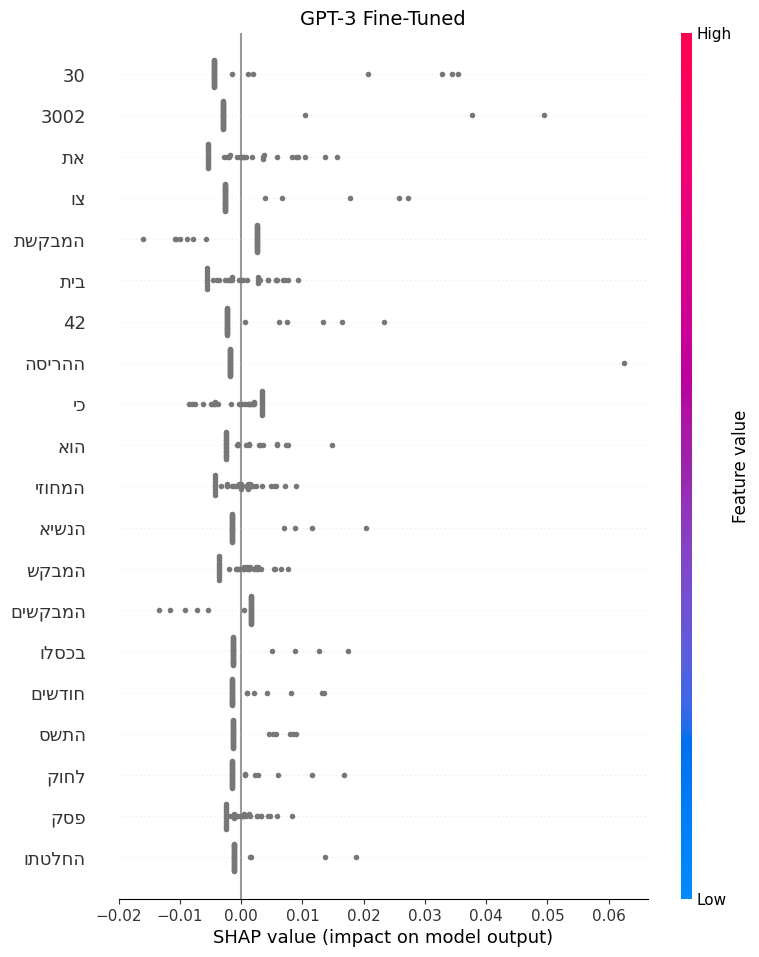

מודל: GPT-3 Fine-Tuned
------------------------------------------------------------
חמשת הפיצ'רים המשפיעים ביותר:
1. 03 - השפעה ממוצעת: 0.0072
2. 2003 - השפעה ממוצעת: 0.0056
3. את - השפעה ממוצעת: 0.0049
4. צו - השפעה ממוצעת: 0.0046
5. המבקשת - השפעה ממוצעת: 0.0040


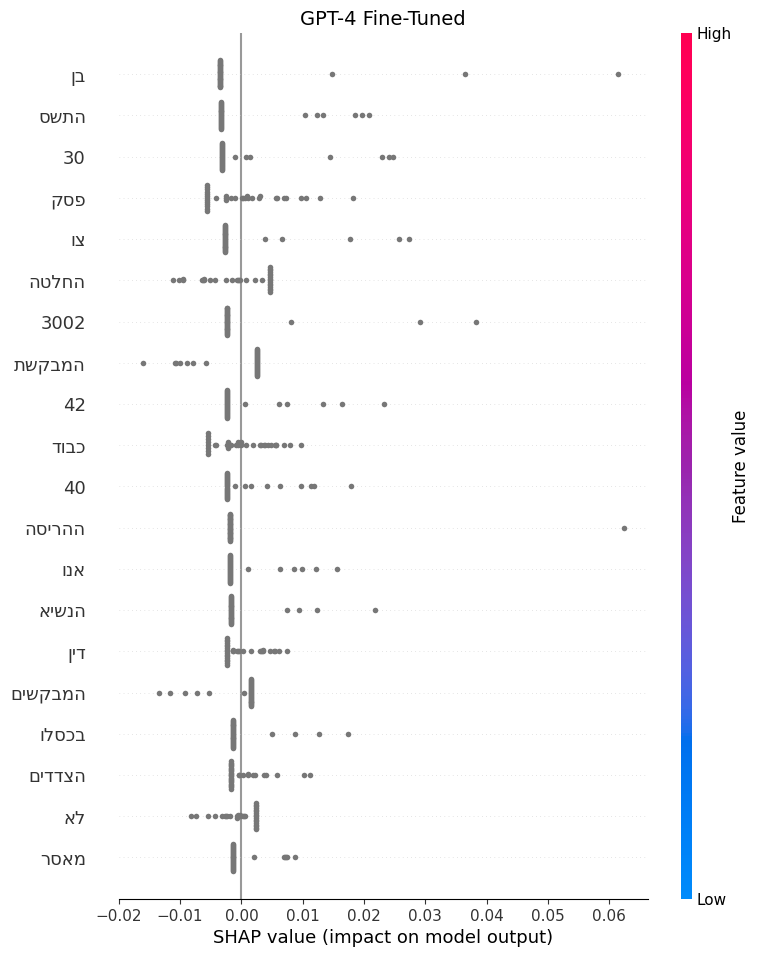

מודל: GPT-4 Fine-Tuned
------------------------------------------------------------
חמשת הפיצ'רים המשפיעים ביותר:
1. בן - השפעה ממוצעת: 0.0064
2. התשס - השפעה ממוצעת: 0.0054
3. 03 - השפעה ממוצעת: 0.0050
4. פסק - השפעה ממוצעת: 0.0050
5. צו - השפעה ממוצעת: 0.0046


In [87]:
import shap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# הכנת משתני הקלט
X_text = test_df["גוף המסמך חתוך"].astype(str)  # טקסט מקורי

# הפיכת תשובות המודלים ליעד חיזוי (מה שהמודלים חזו)
def map_model_predictions(pred):
    if "התקבל" in pred or "חלקי" in pred:
        return 1
    return 0

# יצירת מטרות חיזוי לפי מה שהמודלים חזו
y_target_gpt3 = test_df["gpt_3_res"].apply(map_model_predictions)
y_target_gpt4 = test_df["gpt_4_res"].apply(map_model_predictions)

# המרת טקסט לפיצ'רים מבוססי TF-IDF
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X_text)

# מילון לאחסון תוצאות SHAP
shap_results = {}

# מעבר על שני המודלים וביצוע SHAP לכל אחד
for model_name, (model, y_target) in [
    ("GPT-3 Fine-Tuned", (gpt_3, y_target_gpt3)),
    ("GPT-4 Fine-Tuned", (gpt_4, y_target_gpt4))
]:

    # אימון Logistic Regression כפרוקסי למודל
    clf = LogisticRegression()
    clf.fit(X_tfidf, y_target)

    # יצירת Explainer של SHAP
    explainer = shap.Explainer(clf, X_tfidf)
    shap_values = explainer(X_tfidf)

    # שמירת התוצאות במילון
    shap_results[model_name] = shap_values

    # יצירת גרף SHAP מסכם
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, feature_names=[w[::-1] for w in vectorizer.get_feature_names_out()], show=False)

    # כותרת בעברית מודפסת בהיפוך לצורך הצגת טקסט נכון
    plt.title(f"{model_name}", fontsize=14)
    plt.show()

    print("=" * 60)
    print(f"מודל: {model_name}")
    print("-" * 60)
    print("חמשת הפיצ'רים המשפיעים ביותר:")

    # הצגת חמשת הפיצ'רים המשפיעים ביותר
    top_features = np.argsort(np.abs(shap_values.values).mean(axis=0))[-5:][::-1]
    for i, feature_idx in enumerate(top_features, 1):
        feature_name = vectorizer.get_feature_names_out()[feature_idx]  # לא הופכים עברית בהדפסה הרגילה
        avg_impact = np.abs(shap_values.values[:, feature_idx]).mean()
        print(f"{i}. {feature_name} - השפעה ממוצעת: {avg_impact:.4f}")

    print("=" * 60)


In [88]:
import lime
import lime.lime_text
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from tqdm import tqdm

# הכנת נתוני הטקסט
X_text = test_df["גוף המסמך חתוך"].astype(str)  # טקסט מקורי

# הפיכת תשובות המודלים ליעד חיזוי
def map_model_predictions(pred):
    if "התקבל" in pred or "חלקי" in pred:
        return 1
    return 0

# יצירת מטרות חיזוי לפי מה שהמודלים חזו
y_target_gpt3 = test_df["gpt_3_res"].apply(map_model_predictions)
y_target_gpt4 = test_df["gpt_4_res"].apply(map_model_predictions)

# המרת טקסט לפיצ'רים מבוססי TF-IDF
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X_text)

# מילון לאחסון תוצאות LIME
lime_results = {}

# מעבר על שני המודלים וביצוע LIME לכל אחד
for model_name, (model, y_target) in [
    ("GPT-3 Fine-Tuned", (gpt_3, y_target_gpt3)),
    ("GPT-4 Fine-Tuned", (gpt_4, y_target_gpt4))
]:

    # אימון Logistic Regression כפרוקסי למודל
    clf = LogisticRegression()
    clf.fit(X_tfidf, y_target)

    # יצירת Explainer של LIME
    explainer = lime.lime_text.LimeTextExplainer(class_names=["Rejected", "Accepted"])

    # בחירת פסק דין אקראי לבדיקה
    idx = np.random.randint(0, len(X_text))
    text_sample = X_text.iloc[idx]

    # פונקציה לחיזוי הסתברויות על טקסטים
    def predict_proba(texts):
        tfidf_texts = vectorizer.transform(texts)
        return clf.predict_proba(tfidf_texts)

    # יצירת ההסבר של LIME
    exp = explainer.explain_instance(
        text_sample,
        predict_proba,
        num_features=10  # הצגת 10 המילים הכי משפיעות
    )

    # שמירת התוצאה
    lime_results[model_name] = exp

    # הצגת ההסבר
    print("=" * 60)
    print(f"מודל: {model_name}")
    print("-" * 60)
    print(f"פסק דין נבחר (ID: {idx}):\n{text_sample[:500]} ...")  # הצגת 500 תווים ראשונים בלבד

    # הצגת 3 הפיצ'רים המשפיעים ביותר
    top_features = exp.as_list()[:3]
    print("\n📌 שלושת האלמנטים שהשפיעו הכי הרבה על החלטת המודל:")
    for i, (word, impact) in enumerate(top_features, 1):
        print(f"{i}. '{word}' - השפעה: {impact:.4f}")

    print("=" * 60)

    # הצגת גרף LIME
    exp.show_in_notebook()


מודל: GPT-3 Fine-Tuned
------------------------------------------------------------
פסק דין נבחר (ID: 25):
חיפה) בע"מ, פ"ד לו(3) 123(1982)). מסיבה זו בלבד דין הבקשה להידחות. אף לגופו של עניין, דין הבקשה להדחות. המבקש מנסה לשוות לבקשה זו אופי עקרוני, אולם המציאות העובדתית הינה ברורה ופשוטה ביותר. המבקש הסכים לביצוע בדיקת שתן, והוכח כי הוא נהג כאשר היו בגופו ממצאים שהעידו כי הוא השתמש בסם מסוכן מסוג קוקאין, ונראה שעל כך אין כל מחלוקת. כפי שנקבע בע"פ 398/04 מדינת ישראל נ\' בניאשווילי, פסקה 15 (לא פורסם, 20.12.2004), "בניגוד לאלכוהול, חל איסור מוחלט על השימוש בסמים מסוכנים, בכל כמות שהיא, ואף נקבע בחוק כ ...

📌 שלושת האלמנטים שהשפיעו הכי הרבה על החלטת המודל:
1. 'כי' - השפעה: -0.0008
2. 'הוא' - השפעה: 0.0006
3. 'בדיקת' - השפעה: -0.0004


מודל: GPT-4 Fine-Tuned
------------------------------------------------------------
פסק דין נבחר (ID: 19):
['פסק דין בתיק רע"פ 3296/14 בבית המשפט העליון רע"פ 3296/14 לפני: כבוד המשנָה לנשיא מ\' נאור כבוד השופט י\' דנציגר כבוד השופטת ד\' ברק-ארז המבקש: מיתקאל עיאשי נגד המשיבים: 1. אחסאן עיאשי 2. סאמח עיאשי 3. היועץ המשפטי לממשלה בקשת רשות ערעור על החלטת בית המשפט המחוזי בחיפה מיום 24.3.2014 ב-עק"פ 35566-10-13 שניתן על ידי כבוד השופטים ש\' ברלינר, ב\' בר זיו ו-י\' ליפשיץ תאריך הישיבה: ט\' בטבת התשע"ה (31.12.2014) בשם המבקש: עו"ד שלומי בלומנפלד בשם המשיבים 2-1: עו"ד חיכאם מרזוק בשם המשיב 3: עו"ד יאיר חמ ...

📌 שלושת האלמנטים שהשפיעו הכי הרבה על החלטת המודל:
1. '2014' - השפעה: -0.0008
2. 'פסק' - השפעה: 0.0006
3. 'המשיבים' - השפעה: -0.0006
